In [1]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as kr
from IPython.display import Image, display


light_s = 2.99792458*10**18    #A * Hz
cosmo = FlatLambdaCDM(H0=100,Om0=0.3)
H0 = 100
Om0=0.3
Ode0 = 1-Om0
maglim = 23.0

In [2]:
import seaborn as sns

sns.set_theme('talk')
sns.set_style('whitegrid', {'xtick.bottom':True, 'ytick.left':True})
sns.plotting_context('talk')

{'axes.linewidth': 1.875,
 'grid.linewidth': 1.5,
 'lines.linewidth': 2.25,
 'lines.markersize': 9.0,
 'patch.linewidth': 1.5,
 'xtick.major.width': 1.875,
 'ytick.major.width': 1.875,
 'xtick.minor.width': 1.5,
 'ytick.minor.width': 1.5,
 'xtick.major.size': 9.0,
 'ytick.major.size': 9.0,
 'xtick.minor.size': 6.0,
 'ytick.minor.size': 6.0,
 'font.size': 18.0,
 'axes.labelsize': 18.0,
 'axes.titlesize': 18.0,
 'xtick.labelsize': 16.5,
 'ytick.labelsize': 16.5,
 'legend.fontsize': 16.5,
 'legend.title_fontsize': 18.0}

### Cosmological Functions

In [3]:
def lumdist(z):
    '''
    Calculates the luminosity distance based on given redshift. Uses cubic spline to approximate the result.

    Arguments:
        z: The redshift should be input as a Numpy array

    '''
    z_max = z.max()

    reds = np.linspace(0,z_max,1000)
    zez = []
    for i in reds:
        zaz = sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return (1+z) * 2.99792458*10**5/H0 * sp.interpolate.interp1d(reds, zez)(z)

def lumdist_err(z,z_err):
    '''
    Calculates the associated upper and lower luminosity distance error based on the given redshift and associated error. 
    The reason for separate errors is that since redshift isn't linearly related to luminosity distance, the transformation doesn't result in the same amount of error.

    Arguments:
        Input: Should be given as a Numpy array
        Output: Numpy array in the form [lower error, upper error]
    
    '''

    lowerr = lumdist(z) - lumdist(z-z_err)
    uperr = lumdist(z+z_err) - lumdist(z)

    return np.array([lowerr,uperr])

def z_from_dl(dl):
    '''
    Returns the redshift based on the given luminosity distance in units of Mpc.

    Arguments:
        dl: The luminosity distance should be input as a Numpy array
    
    '''
    reds = np.linspace(0,10,1000)
    zez = []
    for i in reds:
        zaz = (1+i) * 2.99792458*10**5/H0 * sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return sp.interpolate.CubicSpline(zez,reds)(dl)

def colorcorr(bandname, redshift, colv, colv1, colm, colm1):
    """
    Calculates k-corrections based on Beare-Brown (2014) paper. Is used for g, r, i, z bands.

    Arguments:
        Input: Should be Numpy arrays or float values!
        bandname: Should be a String, in the form 'x'.
    """
    from scipy.interpolate import CubicSpline
    import numpy as np
    
    bandname=str(bandname)

    z_array = np.array(np.linspace(0,0.5,51))

    coeff_dict = {      'g':np.array((np.array([0.0000,-0.0161,-0.0334,-0.0505,-0.0642,-0.0930,-0.1483,-0.2178,-0.2863,-0.2469,-0.2673, -0.2686,-0.2478,
                                               -0.2101,-0.1466,-0.0999,-0.0810,-0.0662,-0.0553,-0.0450,-0.0346,-0.0253,-0.0165,-0.0073,0.0008,0.0103,
                                                0.0195,0.0272,0.0352,0.0433,0.0498,0.0544,0.0576,0.0530,0.0336, -0.1596,-0.3490,-0.3862,-0.4522,-0.4112,
                                               -0.2755,-0.2729,-0.4159,-0.2909,-0.2102,-0.1557,-0.1158,-0.0963,-0.0869,-0.0689,-0.0515]),
                                     np.array([1.0000,0.9609,0.9318,0.9121,0.8932,0.8968,0.9413,1.0152,1.0950,1.0078,1.0099,0.9839,0.9220,0.8327,0.7121,
                                               0.6052,0.5368,0.4767,0.4237,0.3743,0.3263,0.2819,0.2402,0.1981,0.1578,0.1139,0.0695,0.0270,-0.0163,-0.0588,
                                               -0.0972,-0.1296,-0.1585,-0.1635,-0.1229,1.0195,1.1784,1.1818,1.2146,1.1259,0.9552,0.8673,0.9411,0.7830,0.6659,
                                               0.5740,0.4960,0.4440,0.4000,0.3441,0.2927]),
                                     np.array([0.0000,0.0146,0.0243,0.0279,0.0292,0.0227,0.0009,-0.0347,-0.0753,-0.0544,-0.0641,-0.0638,-0.0493,-0.0229,
                                               0.0087,0.0436,0.0697,0.0928,0.1142,0.1345,0.1551,0.1749,0.1936,0.2134,0.2334,0.2559,0.2795,0.3032,0.3283,
                                               0.3538,0.3784,0.3999,0.4195,0.4210,0.3873,0.2986,0.2528,0.2437,0.2282,0.2466,0.2786,0.3045,0.2938,0.3268,
                                               0.3523,0.3734,0.3927,0.4057,0.4169,0.4330,0.4475]))),

                        'r':np.array((np.array([-0.0910, -0.0938, -0.0946, -0.0911, -0.0826, -0.0609, -0.0361, -0.0090, -0.0103,-0.0112, -0.0148, -0.0141,
                                                -0.0156, -0.0193, -0.0170, -0.0236, -0.0558, -0.0356,-0.0162, -0.0146, -0.0115, -0.0093, -0.0074, -0.0078,
                                                -0.0148, -0.0360, 0.0184,0.0653, 0.0985, 0.1173, 0.1263, 0.1274, 0.1221, 0.1106, 0.0937, 0.0690, 0.0291,
                                                -0.0337, -0.0442, -0.0621, -0.0626, -0.0637, -0.1234, -0.1298, -0.1229, -0.1148,-0.1050, -0.0889, -0.0796,
                                                -0.0852, -0.0819]),
                                     np.array([0.5390, 0.5250, 0.5045, 0.4742, 0.4325, 0.3587, 0.2782, 0.1915, 0.1717, 0.1553,0.1479,0.1297,0.1183,0.1174,
                                                0.1024, 0.1181, 0.2072, 0.1366, 0.0696, 0.0593,0.0465, 0.0369, 0.0282, 0.0277, 0.0515, 0.1261, 0.2922, 0.1758,
                                                0.0850, 0.0219,-0.0214, -0.0476, -0.0599, -0.0574, -0.0431, -0.0151, 0.0483, 0.1584, 0.1685, 0.1963, 0.1862,
                                                0.1849, 0.3061, 0.3129, 0.2957, 0.2770, 0.2525, 0.2133, 0.1930, 0.2053, 0.1973]),
                                     np.array([-0.1256, -0.1223, -0.1114, -0.0927, -0.0652, -0.0155, 0.0381, 0.0949, 0.1103, 0.1200, 0.1225, 0.1324, 0.1383,
                                                0.1363, 0.1448, 0.1279, 0.0577, 0.1118, 0.1616, 0.1663, 0.1724, 0.1763, 0.1794, 0.1736, 0.1437, 0.0672, 0.2477,
                                                0.3068, 0.3544,0.3891, 0.4145, 0.4303, 0.4376, 0.4358, 0.4273, 0.4136, 0.3800, 0.3236, 0.3161, 0.2983, 0.3020,
                                                0.2960, 0.2260, 0.2200, 0.2245, 0.2294, 0.2388, 0.2569, 0.2615, 0.2486, 0.2473]))),

                        'i':np.array((np.array([0.0584,0.0531,0.0483,0.0280,-0.0154,-0.0483,-0.0520,-0.0532,-0.0518,-0.0394,-0.0177,0.0045,0.0193,0.0237,
                                               0.0222,0.0183,0.0136,0.0089,0.0044,0.0007,-0.0027,-0.0049,-0.0037,0.0070,0.0325,0.0780,0.1457,0.1765,0.2327,
                                               0.2633,0.2812,0.2876,0.3302,0.3467,0.4001,0.4973,0.5611,0.4876,0.4757,0.4459,0.4466,0.4382,0.3434,0.3134,0.3047,
                                               0.2978,0.2941,0.3018,0.2944,0.2588,0.2414]),
                                     np.array([0.2701,0.2604,0.2614,0.2841,0.3320,0.3548,0.3359,0.3140,0.2890,0.2501,0.1989,0.1474,0.1070,0.0809,0.0634,0.0497,
                                               0.0376,0.0264,0.0154,0.0036,-0.0088,-0.0243,-0.0472,-0.0886,-0.1582,-0.2640,-0.4124,-0.5175,-0.6439,-0.7231,-0.7765,
                                               -0.8052,-0.8873,-0.9233,-1.0185,-1.1916,-1.3055,-1.1735,-1.1600,-1.1105,-1.1270,-1.1115,-0.9172,-0.8648,-0.8536,-0.8452,
                                               -0.8466,-0.8742,-0.8621,-0.7868,-0.7528]),
                                     np.array([0.0916,0.0941,0.0885,0.0748,0.0549,0.0477,0.0555,0.0646,0.0753,0.0916,0.1124,0.1330,0.1495,0.1609,0.1688,0.1744,0.1789,
                                               0.1831,0.1867,0.1906,0.1954,0.2021,0.2134,0.2345,0.2703,0.3249,0.4014,0.4707,0.5386,0.5844,0.6167,0.6346,0.6683,0.6807,
                                               0.7154,0.7848,0.8272,0.7628,0.7577,0.7342,0.7478,0.7369,0.6328,0.6104,0.6078,0.6060,0.6116,0.6322,0.6258,0.5852,0.5675]))),

                        'z':np.array((np.array([0.0000,-0.0022,-0.0037,-0.0031,0.0045,0.0158,0.0230,0.0299,0.0373,0.0396,0.0322,0.0151,-0.0043,-0.0178,-0.0256,
                                               -0.0294,-0.0318,-0.0324,-0.0318,-0.0310,-0.0304,-0.0281,-0.0223,-0.0067,0.0254,0.0142,0.0793,0.1746,0.2307,0.3376,
                                               0.3667,0.4445,0.3563,0.3882,0.4764,0.6360,0.7203,0.6956,0.7300,0.7033,0.7120,0.7995,0.7383,0.6581,0.6363,0.6142,
                                               0.5944,0.5962,0.5671,0.4863,0.4051]),
                                     np.array([0.0000,-0.0134,-0.0282,-0.0487,-0.0795,-0.1135,-0.1408,-0.1673,-0.1930,-0.2078,-0.2064,-0.1914,-0.1731,-0.1634,-0.1620,
                                               -0.1660,-0.1727,-0.1811,-0.1906,-0.2015,-0.2130,-0.2290,-0.2538,-0.2998,-0.3781,-0.4159,-0.5587,-0.7536,-0.8915,-1.0772,
                                               -1.1461,-1.2830,-1.1652,-1.2202,-1.3660,-1.6372,-1.7760,-1.7140,-1.7856,-1.7380,-1.7696,-1.8883,-1.7210,-1.5900,-1.5690,
                                               -1.5461,-1.5253,-1.5502,-1.5021,-1.3411,-1.1830]),
                                     np.array([0.0000,0.0057,0.0124,0.0221,0.0362,0.0501,0.0608,0.0718,0.0828,0.0904,0.0923,0.0891,0.0846,0.0821,0.0816,0.0819,0.0826,
                                               0.0841,0.0853,0.0873,0.0905,0.0963,0.1077,0.1310,0.1716,0.2116,0.2891,0.3912,0.4724,0.5552,0.5947,0.6529,0.6160,0.6344,
                                               0.6875,0.7952,0.8446,0.8033,0.8382,0.8153,0.8378,0.8695,0.7570,0.7078,0.7095,0.7099,0.7109,0.7354,0.7167,0.6413,0.5701]))) }
    
    if bandname in coeff_dict.keys():
        a1 = CubicSpline(z_array, coeff_dict[bandname][0])
        a = a1(redshift)
        
        b1 = CubicSpline(z_array, coeff_dict[bandname][1])
        b = b1(redshift)
        
        c1 = CubicSpline(z_array, coeff_dict[bandname][2])
        c = c1(redshift)
    else:
        print(f'{bandname} not recognised')
    
    if type(redshift)==np.ndarray:
        kc = np.zeros(len(redshift))
        
        if bandname == 'g':
            
            selection_low = (redshift <= 0.34)
            
            if type(colv)==np.ndarray:
                kc[selection_low] = a[selection_low]*(colv[selection_low])**2 + b[selection_low]*colv[selection_low] + c[selection_low] - colm[selection_low]
                kc[~selection_low] = a[~selection_low]*(colv1[~selection_low])**2 + b[~selection_low]*colv1[~selection_low] + c[~selection_low] - colm1[~selection_low]
            
            elif (type(colv)==np.float64) or (type(redshift)==np.float32):
                    kc[selection_low] = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
                    kc[~selection_low] = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
            
            else:
                raise Exception('No valid color values entered')
    
        elif bandname =='r':
            
            selection_low = (redshift <= 0.25)
            
            if type(colv)==np.ndarray:
                kc[selection_low] = a[selection_low]*(colv[selection_low])**2 + b[selection_low]*colv[selection_low] + c[selection_low] - colm[selection_low]
                kc[~selection_low] = a[~selection_low]*(colv1[~selection_low])**2 + b[~selection_low]*colv1[~selection_low] + c[~selection_low] - colm1[~selection_low]
                
            elif (type(colv)==np.float64) or (type(redshift)==np.float32):
                    kc[selection_low] = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
                    kc[~selection_low] = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1

            else:
                raise Exception('No valid color values entered')
    
        elif bandname=='i':
            kc = a*(colv)**2 + b*(colv) + c - colm
        
        elif bandname=='z':
            kc = a*(colv)**2 + b*(colv) + c
    
        else:
            raise Exception(f'{bandname} not recognised')
            
    elif (type(redshift)==np.float64) or (type(redshift)==np.float32):
        if bandname == 'g':
        
            selection_low = (redshift <= 0.34)
            
            if redshift <= 0.34:
                kc = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
            else:
                kc = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
    
        elif bandname =='r':
            
            selection_low = (redshift <= 0.25)
            
            if redshift <= 0.25:
                kc = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
            else:
                kc = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
    
        elif bandname=='i':
            kc = a*(colv)**2 + b*(colv) + c - colm
        
        elif bandname=='z':
            kc = a*(colv)**2 + b*(colv) + c
    
        else:
            raise Exception(f'{bandname} not recognised')
    else:
        raise Exception('Invalid Redshift')
    
    return kc

def absmag(redshift, appmag_g, appmag_r, appmag_i, appmag_z):
    '''
    Calculates the absolute magnitudes from the given redshift values.
    
    Arguments:
        Input: Should be Numpy arrays!
        Returns: Four arrays, each containing absolute magnitudes in the bands g,r,i,z respectively.

    '''
    # g-band
    colv = appmag_g - appmag_r
    colv1 = appmag_r - appmag_i
    colm = colv
    colm1 = appmag_g - appmag_i
    
    abs_g = colorcorr('g', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_g 

    # r-band
    colv = appmag_g - appmag_i
    colv1 = appmag_r - appmag_z
    colm = appmag_r - appmag_i
    colm1 = appmag_r - appmag_z
    
    abs_r = colorcorr('r', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_r

    # i-band
    colv = appmag_r - appmag_z
    colv1 = 0
    colm = appmag_i - appmag_z
    colm1 = 0
    
    abs_i = colorcorr('i', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_i

    # z-band
    colv = appmag_r - appmag_z
    colv1 = 0
    colm = 0
    colm1 = 0
    abs_z = colorcorr('z', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_z
         
    absmag = np.array([abs_g,abs_r,abs_i,abs_z])

    return absmag


def decam_to_sdss(m_g, m_r, m_i, m_z):
    # https://arxiv.org/abs/1708.01531
    g_sdss = m_g + 0.060 * (m_g - m_i) - 0.005
    r_sdss = m_r + 0.150 * (m_r - m_i) + 0.014
    i_sdss = m_i + 0.167 * (m_r - m_i) - 0.027
    z_sdss = m_z + 0.054 * (m_r - m_i) - 0.024
    return g_sdss, r_sdss, i_sdss, z_sdss

def sdss_to_decam(m_g, m_r, m_i, m_z):
    g_des = m_g - 0.104 * (m_g - m_r) + 0.01
    r_des = m_r - 0.102 * (m_g - m_r) + 0.02
    i_des = m_i - 0.256 * (m_i - m_z) + 0.02
    z_des = m_z - 0.086 * (m_i - m_z) + 0.01
    return g_des, r_des, i_des, z_des

### Data Loading

In [4]:
path = '~/Desktop/MT'
f = os.path.join(path, 'desxsdss_check.csv')
# gets column names
pd.read_csv(f).columns

Index(['id1', 'id2', 'z', 'zerr', 'class', 'ra', 'dec', 'cmodelmag_u',
       'cmodelmag_g', 'cmodelmag_r', 'cmodelmag_i', 'cmodelmag_z',
       'cmodelmagerr_u', 'cmodelmagerr_g', 'cmodelmagerr_r', 'cmodelmagerr_i',
       'cmodelmagerr_z', 'dnf_zmean_sof', 'dnf_zsigma_sof', 'alphawin_j2000',
       'deltawin_j2000', 'mag_auto_g', 'mag_auto_r', 'mag_auto_i',
       'mag_auto_z', 'mag_auto_y', 'magerr_auto_g', 'magerr_auto_r',
       'magerr_auto_i', 'magerr_auto_z', 'magerr_auto_y'],
      dtype='object')

In [5]:
df = pd.read_csv(f)

In [6]:
magmaskg = df["mag_auto_g"] < 40
magmaskr = df["mag_auto_r"] < 40
magmaski = df["mag_auto_i"] < 40
magmaskz = df["mag_auto_z"] < 40
magmasky = df["mag_auto_y"] < 40

magmaskg1 = df["mag_auto_g"] > 0
magmaskr1 = df["mag_auto_r"] > 0
magmaski1 = df["mag_auto_i"] > 0
magmaskz1 = df["mag_auto_z"] > 0
magmasky1 = df["mag_auto_y"] > 0

zmask1h = df['dnf_zmean_sof'] > 0
zmask1l = df['dnf_zmean_sof'] <= 0.5

zmask2h = df['z'] > 0
zmask2l = df['z'] <= 0.5

fluxmask_u = df['cmodelmag_u'] < 40
fluxmask_g = df['cmodelmag_g'] < 40
fluxmask_r = df['cmodelmag_r'] < 40
fluxmask_i = df['cmodelmag_i'] < 40
fluxmask_z = df['cmodelmag_z'] < 40

fluxmask_u1= df['cmodelmag_u'] > 0
fluxmask_g1= df['cmodelmag_g'] > 0
fluxmask_r1= df['cmodelmag_r'] > 0
fluxmask_i1= df['cmodelmag_i'] > 0
fluxmask_z1= df['cmodelmag_z'] > 0

mask_total = magmaskg & magmaskr &  magmaski &  magmaskz & magmasky & zmask1h & zmask1l & zmask2h & zmask2l & fluxmask_u & fluxmask_g & fluxmask_r & fluxmask_i & fluxmask_z & magmaskg1 & magmaskr1 &  magmaski1 &  magmaskz1 & magmasky1 & fluxmask_u1 & fluxmask_g1 & fluxmask_r1 & fluxmask_i1 & fluxmask_z1

In [7]:
# data loading for objects
df = df[mask_total]
mrows = df.shape

In [8]:
x = len(df)

DESS_mag = df[[f'mag_auto_{i}' for i in 'griz']]
DES_mag = DESS_mag.to_numpy()
DES_magerr = df[[f'magerr_auto_{i}' for i in 'griz']]

SDSS_mag = df[[f'cmodelmag_{i}' for i in 'griz']].to_numpy()
SDSS_magerr = df[[f'cmodelmagerr_{i}' for i in 'griz']].to_numpy()

phot_z = df['dnf_zmean_sof'].to_numpy()
spec_z = df['z'].to_numpy()

phot_z_err = df['dnf_zsigma_sof'].to_numpy()
spec_z_err = df['zerr'].to_numpy()

d_L_phot = lumdist(phot_z)
d_L_spec = lumdist(spec_z)


DM_phot = 25 + 5*np.log10(d_L_phot)
DM_phot = np.broadcast_to(DM_phot.reshape(-1,1), (x,4))

DM_spec = 25 + 5*np.log10(d_L_spec)
DM_spec = np.broadcast_to(DM_spec.reshape(-1,1), (x,4))

In [9]:
newmags = decam_to_sdss(DES_mag[:,0],DES_mag[:,1],DES_mag[:,2],DES_mag[:,3])
m_g = newmags[0]
m_r = newmags[1]
m_i = newmags[2]
m_z = newmags[3]

In [10]:
susmag_DES  = absmag(phot_z, m_g,m_r,m_i,m_z)
susmag_SDSS = absmag(spec_z, SDSS_mag[:,0],SDSS_mag[:,1],SDSS_mag[:,2],SDSS_mag[:,3])
susmag_SDES =  absmag(spec_z, m_g,m_r,m_i,m_z)

In [11]:
ra = df['alphawin_j2000']
ra[ra > 180.] -= 360.
dec = df['deltawin_j2000']

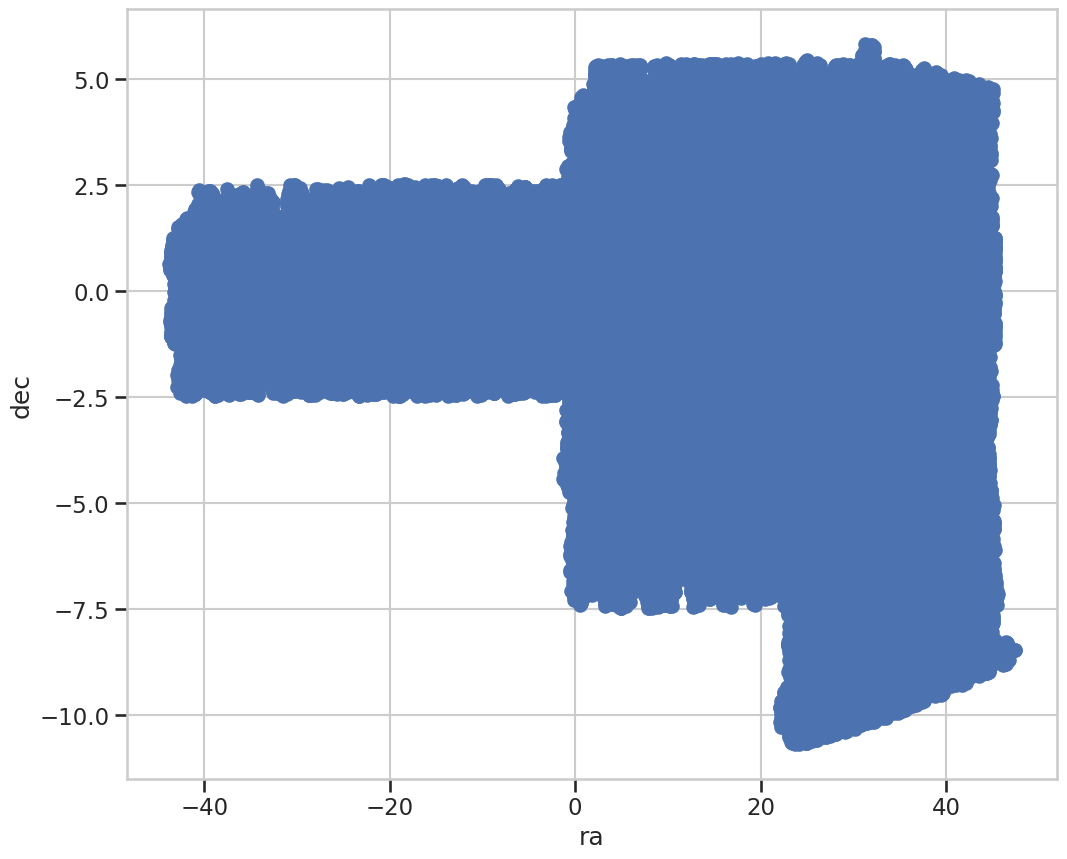

In [12]:
# visualizing the galaxies on the sky
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(ra, dec)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
plt.show()

In [13]:
y = dec
x = ra
from scipy.stats import gaussian_kde
# Perform a kernel density estimate on the data
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Evaluate the KDE on a grid
xmin, xmax = x.min()-1, x.max()+1
ymin, ymax = y.min()-1, y.max()+1
X, Y = np.meshgrid(np.linspace(xmin, xmax, 100),
                   np.linspace(ymin, ymax, 100))
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

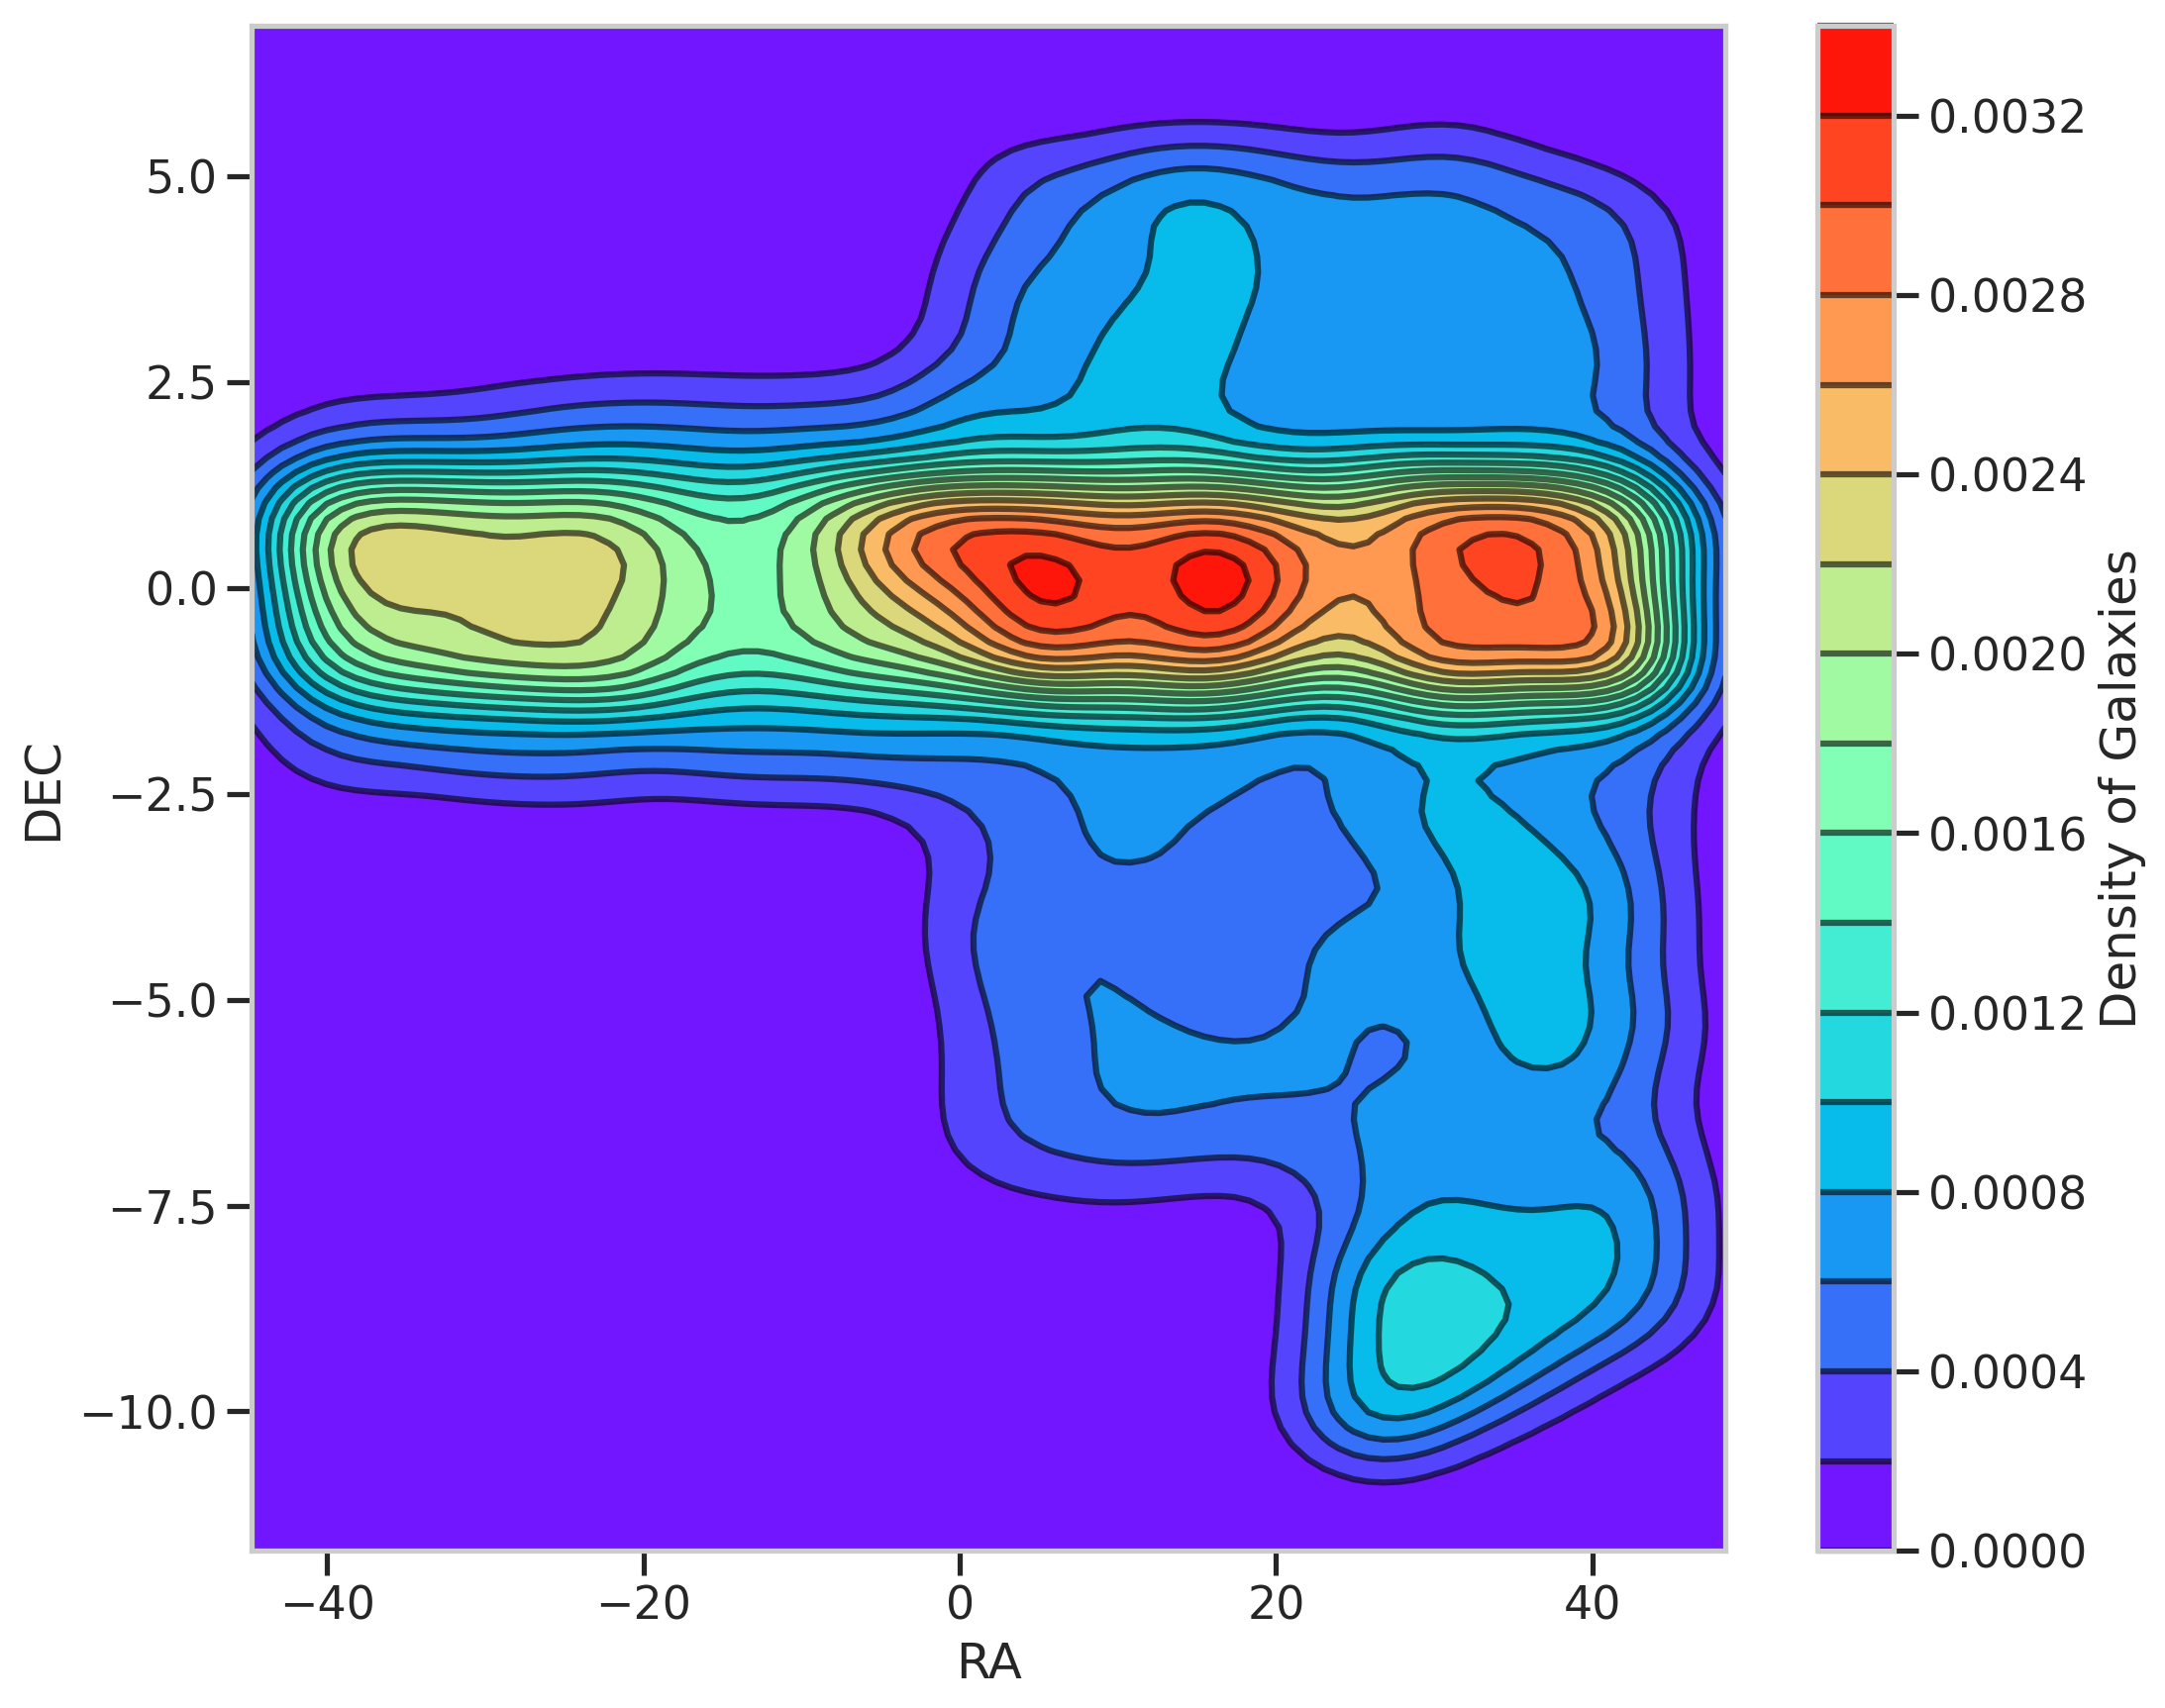

In [14]:
# Plot contour lines + filled contours
fig,ax = plt.subplots(figsize=(12,10),dpi=200)
#ax.scatter(ra,dec, s=1, alpha=0.8, color='orange')
cntf = ax.contourf(X, Y, Z, levels=20, cmap="rainbow")
cnt = ax.contour(X, Y, Z, levels=20, colors="black", alpha=0.6)
cbar = fig.colorbar(cntf)
cbar.ax.set_ylabel('Density of Galaxies')
cbar.add_lines(cnt)

ax.set_xlabel("RA")
ax.set_ylabel("DEC")
fig.savefig('/home/yavuz/Desktop/MT/SDSSxDES_skypos_color.png')
plt.show()

# Data Processing

DES mag to flux

In [15]:
DES_flux = 10**(-0.4*np.array([m_g,m_r,m_i,m_z]).T)

# from std error propagation
DES_fluxerr = DES_magerr * 0.4 * np.log(10) * 10**(-0.4*DES_mag) # from f_err**2 = |df/dm|**2 m_err**2, this is the standard deviation of the flux
    
DES_fluxivar = DES_fluxerr**(-2)

SDSS mag to flux

In [16]:
SDSS_flux = 10**(-0.4*SDSS_mag)

# from std error propagation
SDSS_fluxerr = SDSS_magerr * 0.4 * np.log(10) * 10**(-0.4*SDSS_mag) # from f_err**2 = |df/dm|**2 m_err**2, this is the standard deviation of the flux

SDSS_fluxivar = SDSS_fluxerr**(-2)

# K correction

DES

In [17]:
# getting k correction values
responses1 = ['sdss_g0','sdss_r0','sdss_i0','sdss_z0']
kz = kcorrect.kcorrect.Kcorrect(responses=responses1, cosmo=cosmo)

coeffs1 = kz.fit_coeffs(redshift=phot_z, maggies=DES_flux, ivar=DES_fluxivar)

K_DES = kz.kcorrect(redshift=phot_z, coeffs=coeffs1)       # we have k values to clean out redshift effects from the appmag

SDSS

In [18]:
# getting k correction values
responses2 = ['sdss_g0','sdss_r0','sdss_i0','sdss_z0']
kz = kcorrect.kcorrect.Kcorrect(responses=responses2, cosmo=cosmo)

coeffs2 = kz.fit_coeffs(redshift=spec_z, maggies=SDSS_flux, ivar=SDSS_fluxivar)

K_SDSS = kz.kcorrect(redshift=spec_z, coeffs=coeffs2)       # we have k values to clean out redshift effects from the appmag

Absmag calc

In [19]:
M_DES = np.array([m_g,m_r,m_i,m_z]).T -DM_phot -K_DES
M_SDSS = -2.5*np.log10(SDSS_flux) -DM_spec -K_SDSS

# Visualisation

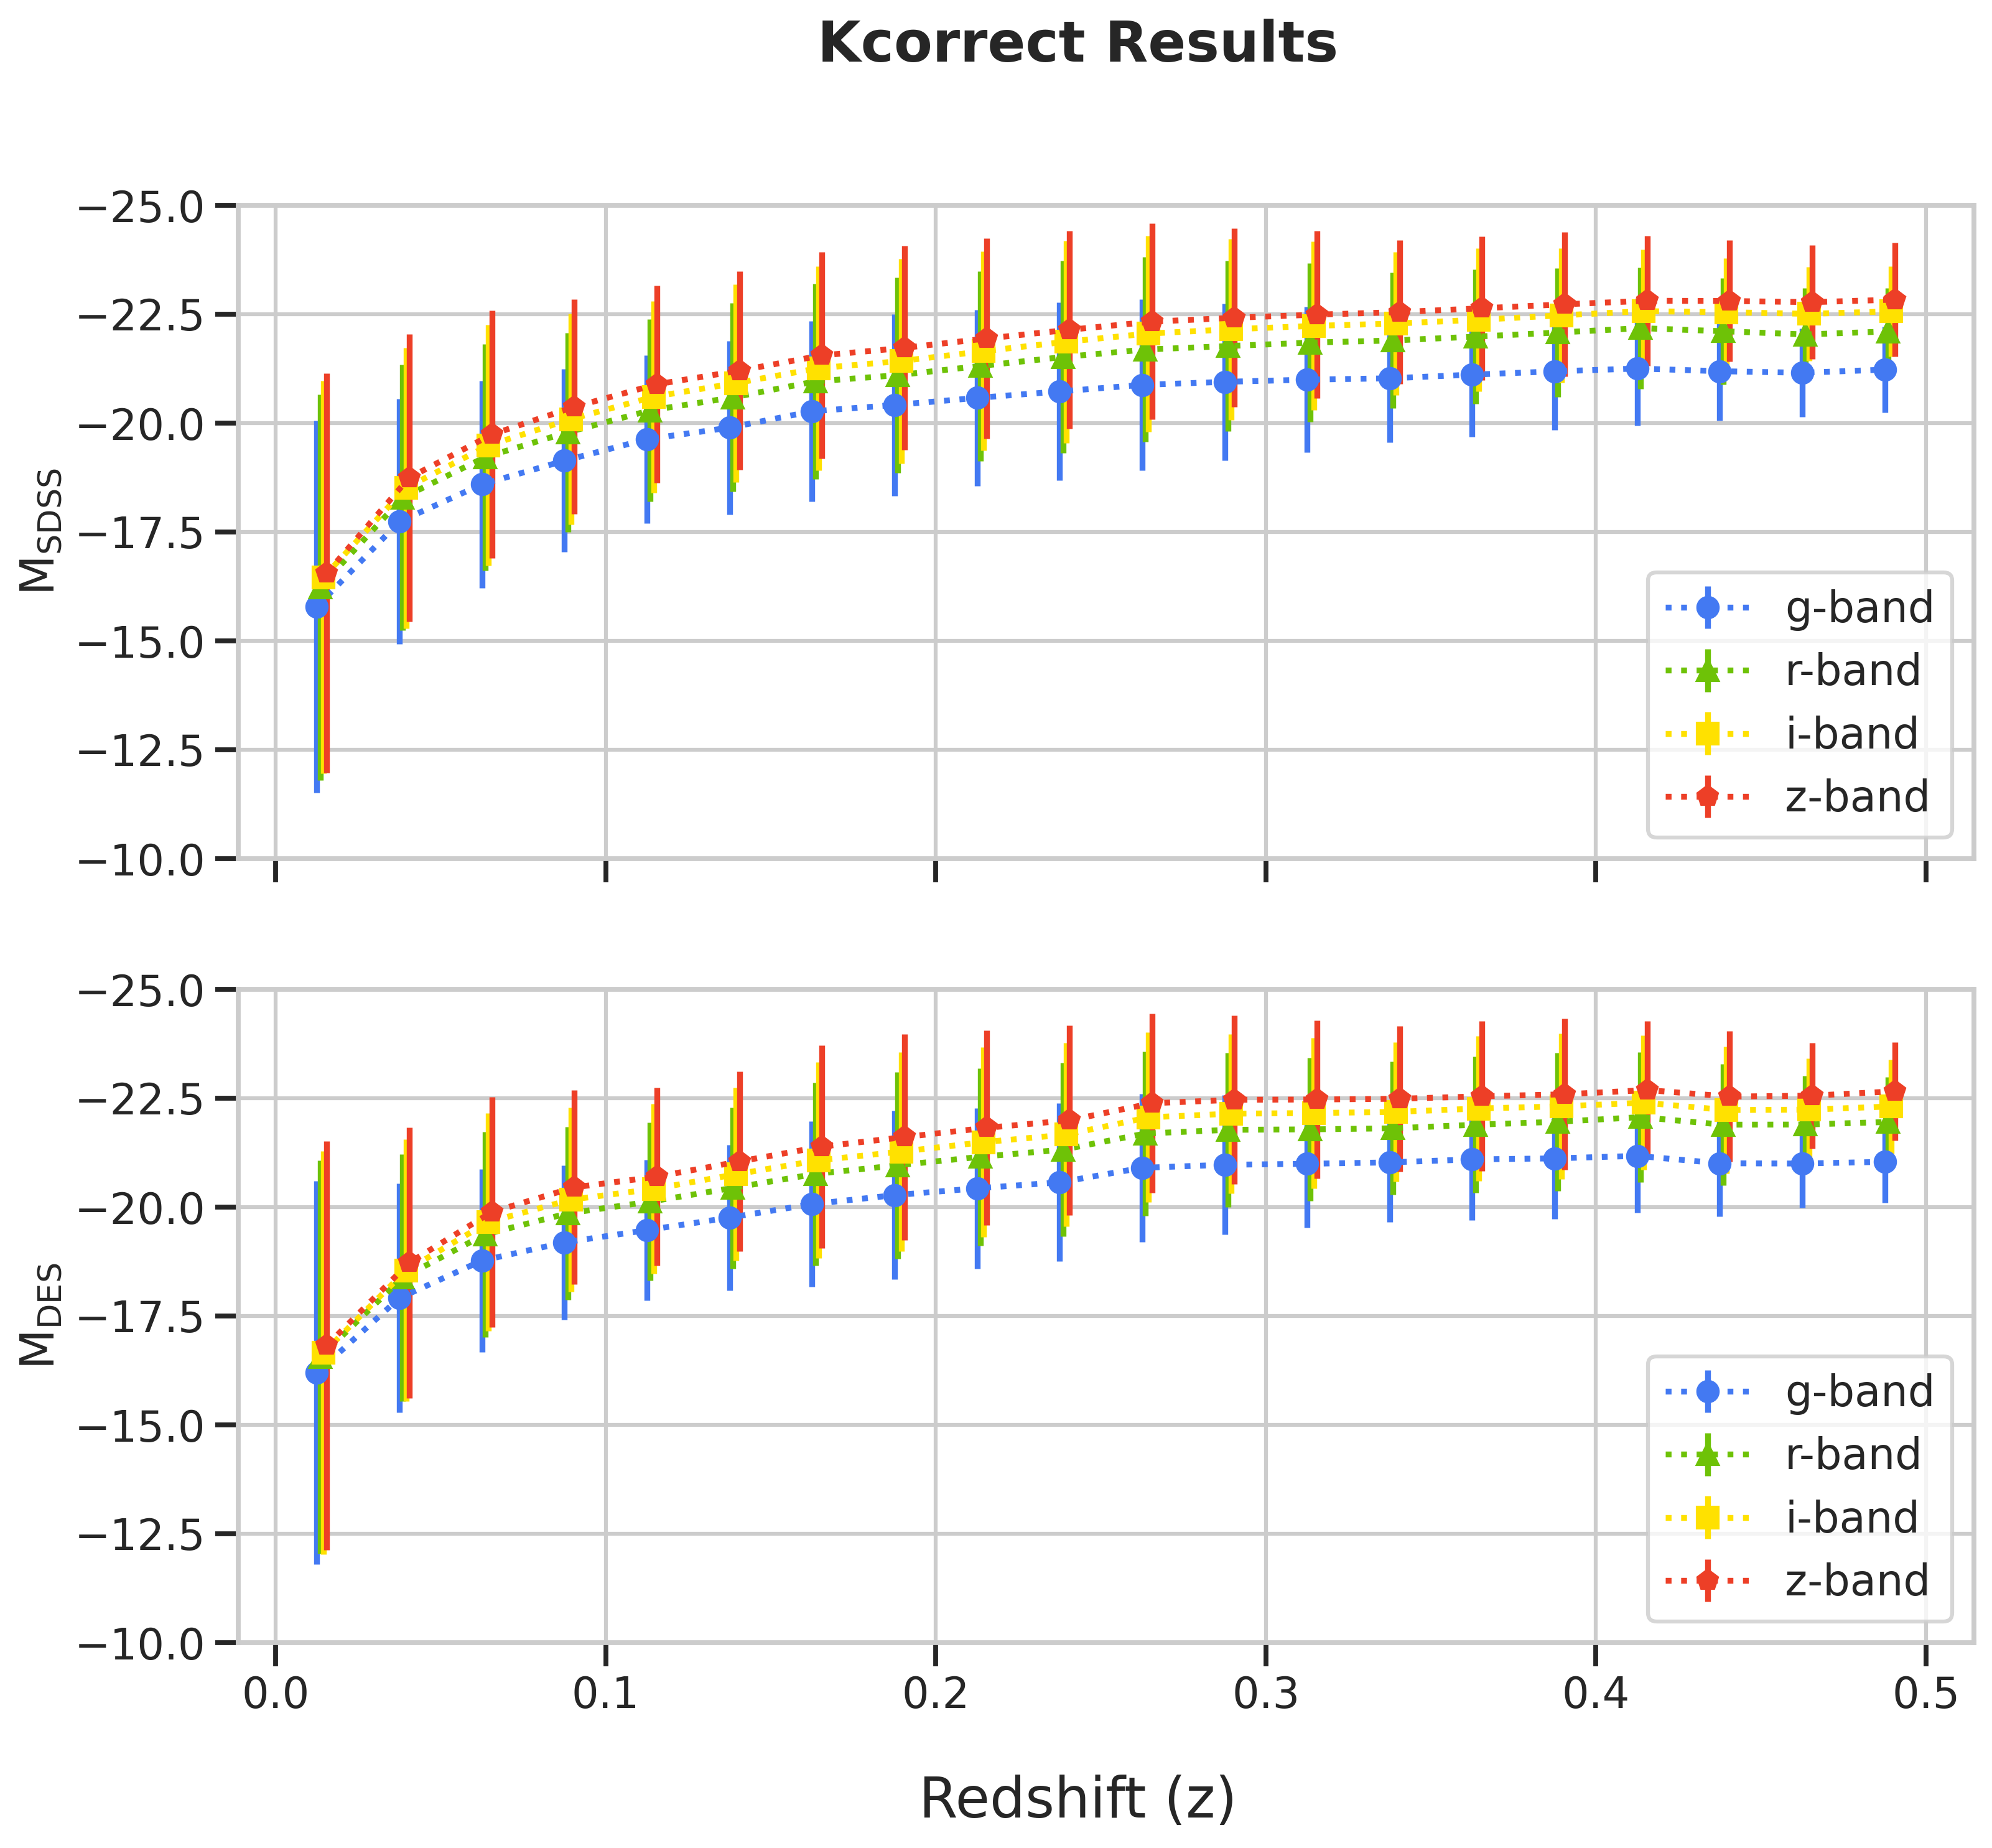

In [20]:
gedges = np.linspace(0,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,10),dpi=300,nrows=2,sharey=True,sharex=True)
names = ['g','r','i','z']
colors = ['#4379F2','#6EC207','#FFE100','#ED3F27']
markers = ['o','^','s','p']

for j in range(4):
    med=[]
    std=[]
    for i in range(20):
        ranger = (spec_z > gedges[i]) & (spec_z <= gedges[i+1])
        med.append(np.median(M_SDSS.T[j][ranger]))
        std.append(2*np.std(M_SDSS.T[j][ranger]))

    ax[0].errorbar(hedges+j/1000,med, yerr=std,c=colors[j],marker=markers[j],markersize=8,label=f'{names[j]}-band',ls=':')
ax[0].set_ylabel(r'M$_{\text{SDSS}}$')
ax[0].legend(loc='lower right')
ax[0].set_ylim(-10,-25)

for j in range(4):
    med=[]
    std=[]
    for i in range(20):
        ranger = (phot_z > gedges[i]) & (phot_z <= gedges[i+1])
        med.append(np.median(M_DES.T[j][ranger]))
        std.append(2*np.std(M_DES.T[j][ranger]))

    ax[1].errorbar(hedges+j/1000,med, yerr=std,c=colors[j],marker=markers[j],markersize=8,label=f'{names[j]}-band',ls=':')
ax[1].set_ylabel(r'M$_{\text{DES}}$')
ax[1].legend(loc='lower right')

fig.supxlabel('Redshift (z)')
fig.suptitle('Kcorrect Results',weight=600)
fig.savefig('abs_kcorr.png')
plt.show()

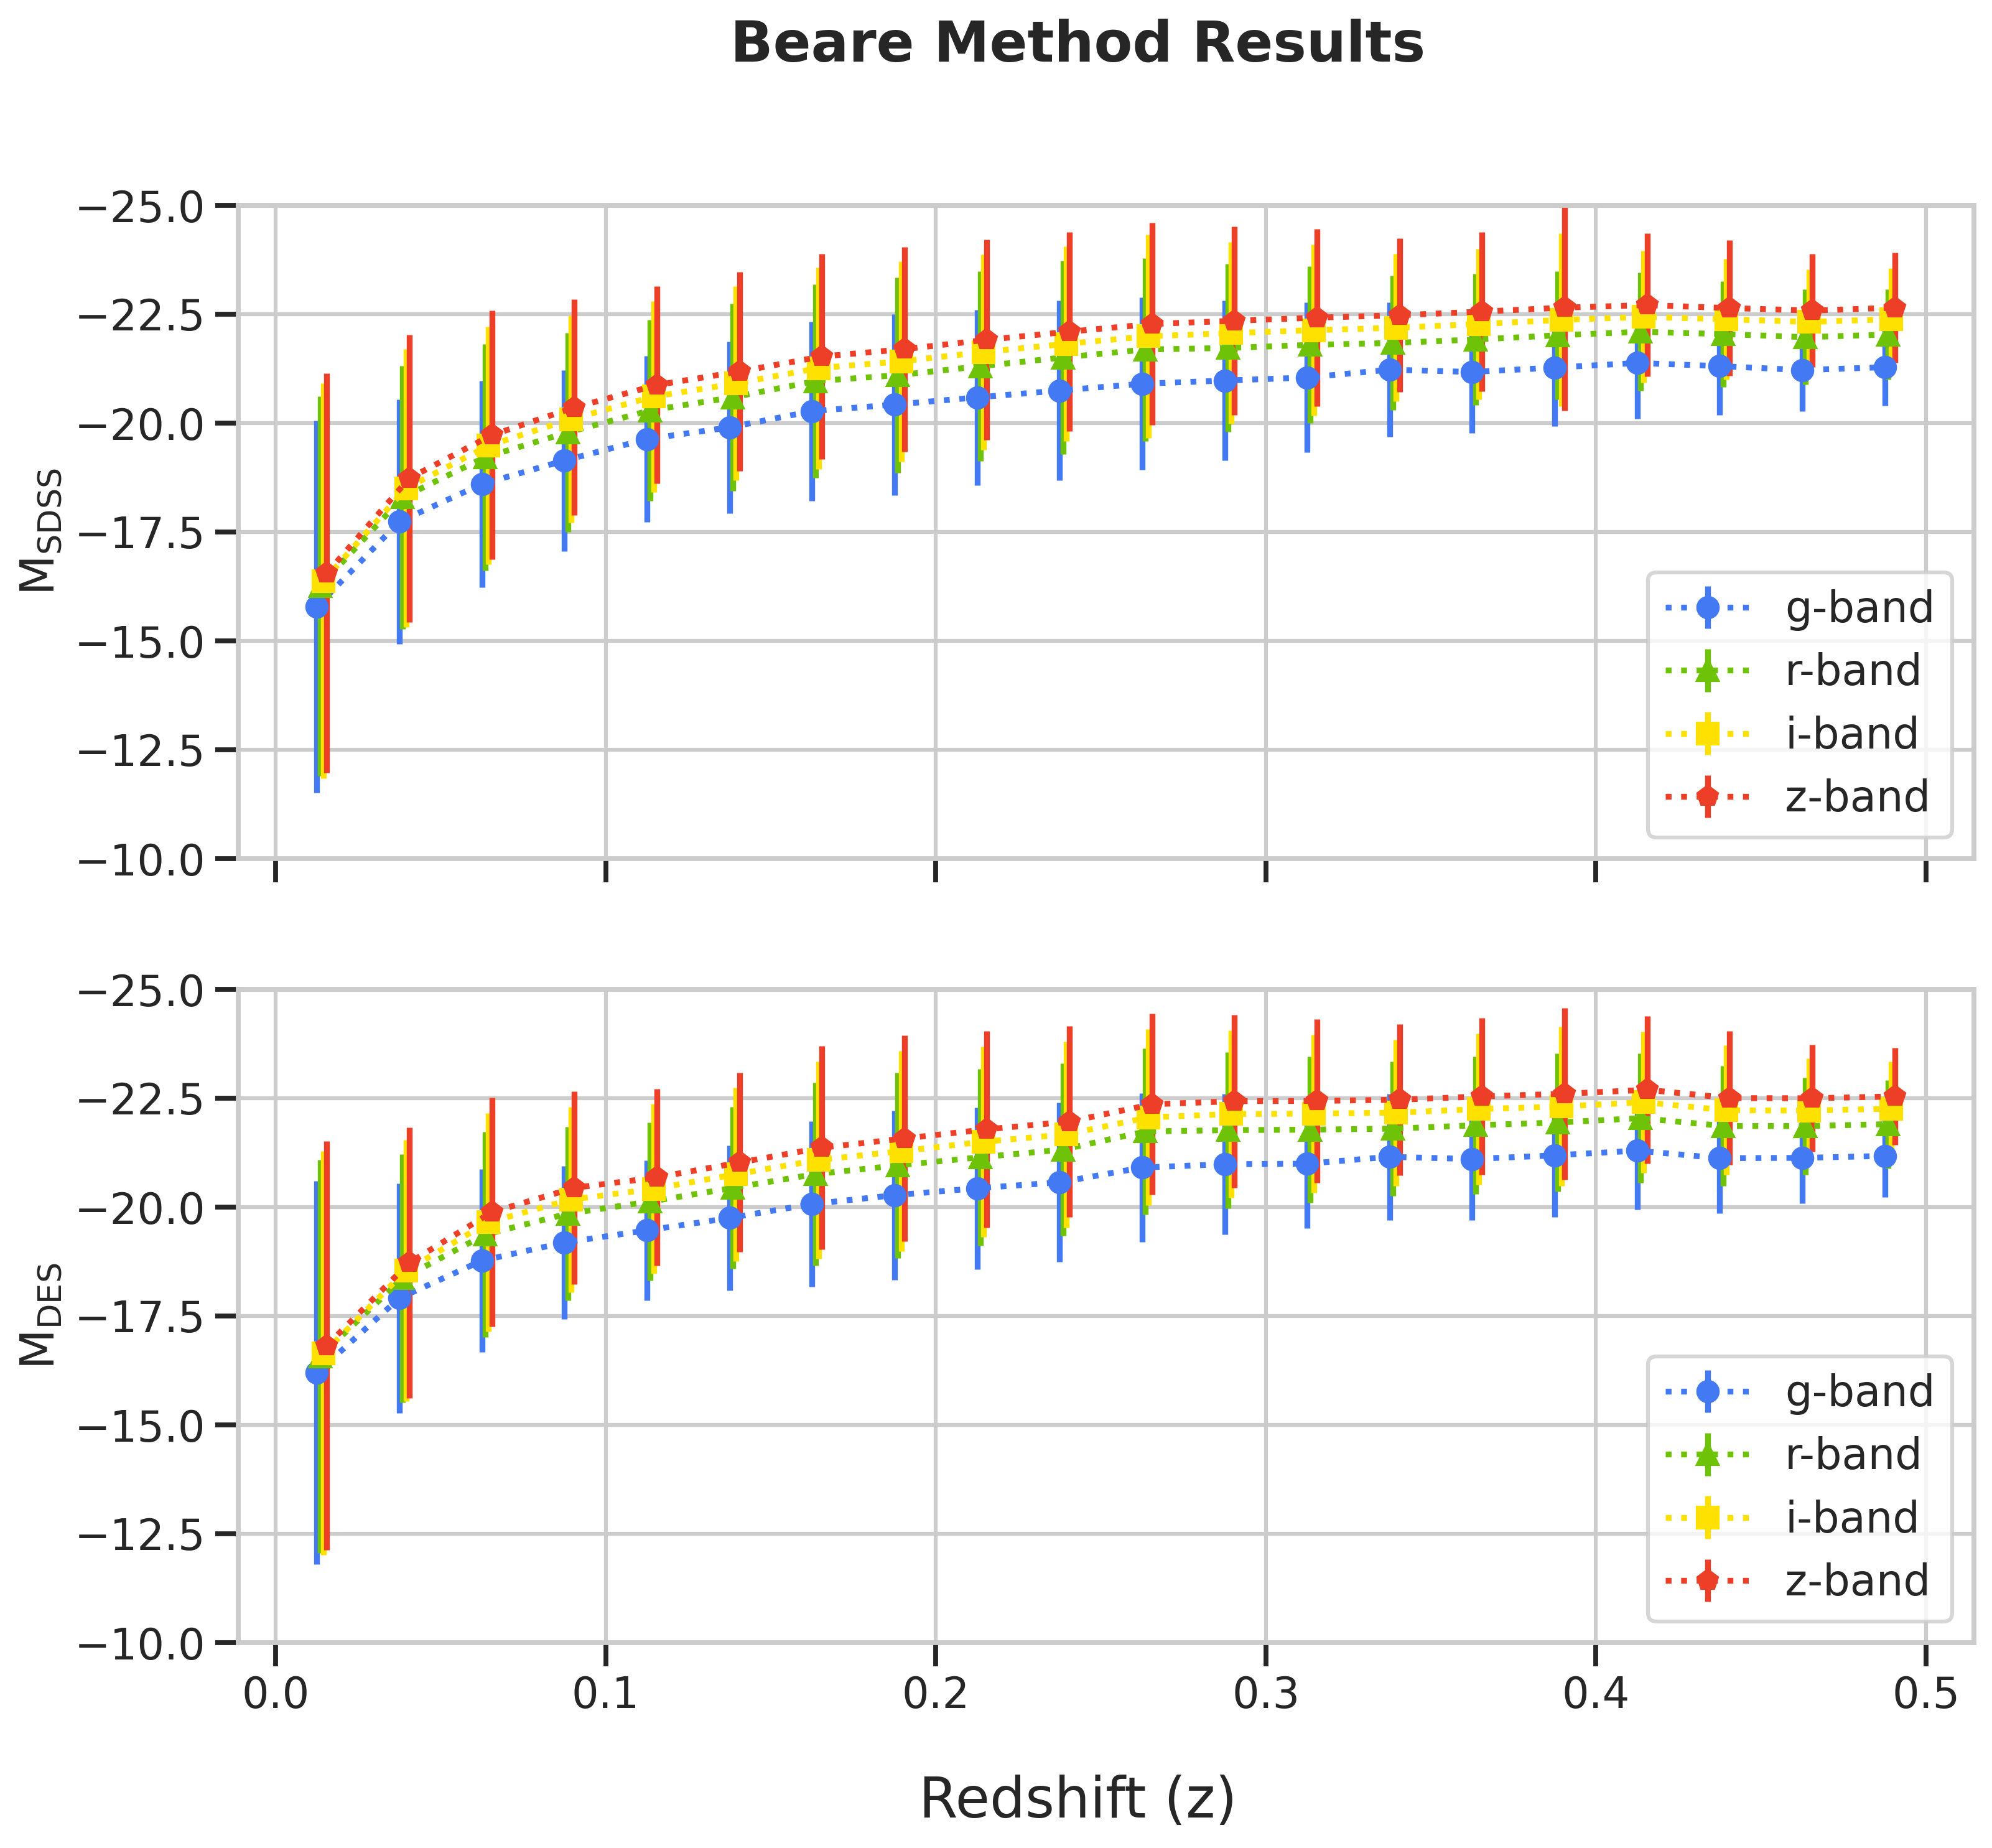

In [21]:
gedges = np.linspace(0,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,10),dpi=300,nrows=2,sharey=True,sharex=True)
names = ['g','r','i','z']
colors = ['#4379F2','#6EC207','#FFE100','#ED3F27']
markers = ['o','^','s','p']

for j in range(4):
    med=[]
    std=[]
    for i in range(20):
        ranger = (spec_z > gedges[i]) & (spec_z <= gedges[i+1])
        med.append(np.median(susmag_SDSS[j][ranger]))
        std.append(2*np.std(susmag_SDSS[j][ranger]))

    ax[0].errorbar(hedges+j/1000,med, yerr=std,c=colors[j],marker=markers[j],markersize=8,label=f'{names[j]}-band',ls=':')
ax[0].set_ylabel(r'M$_{\text{SDSS}}$')
ax[0].legend(loc='lower right')
ax[0].set_ylim(-10,-25)

for j in range(4):
    med=[]
    std=[]
    for i in range(20):
        ranger = (phot_z > gedges[i]) & (phot_z <= gedges[i+1])
        med.append(np.median(susmag_DES[j][ranger]))
        std.append(2*np.std(susmag_DES[j][ranger]))

    ax[1].errorbar(hedges+j/1000,med, yerr=std,c=colors[j],marker=markers[j],markersize=8,label=f'{names[j]}-band',ls=':')
ax[1].set_ylabel(r'M$_{\text{DES}}$')
ax[1].legend(loc='lower right')

fig.supxlabel('Redshift (z)')
fig.suptitle('Beare Method Results',weight=600)
fig.savefig('abs_beare.png')
plt.show()

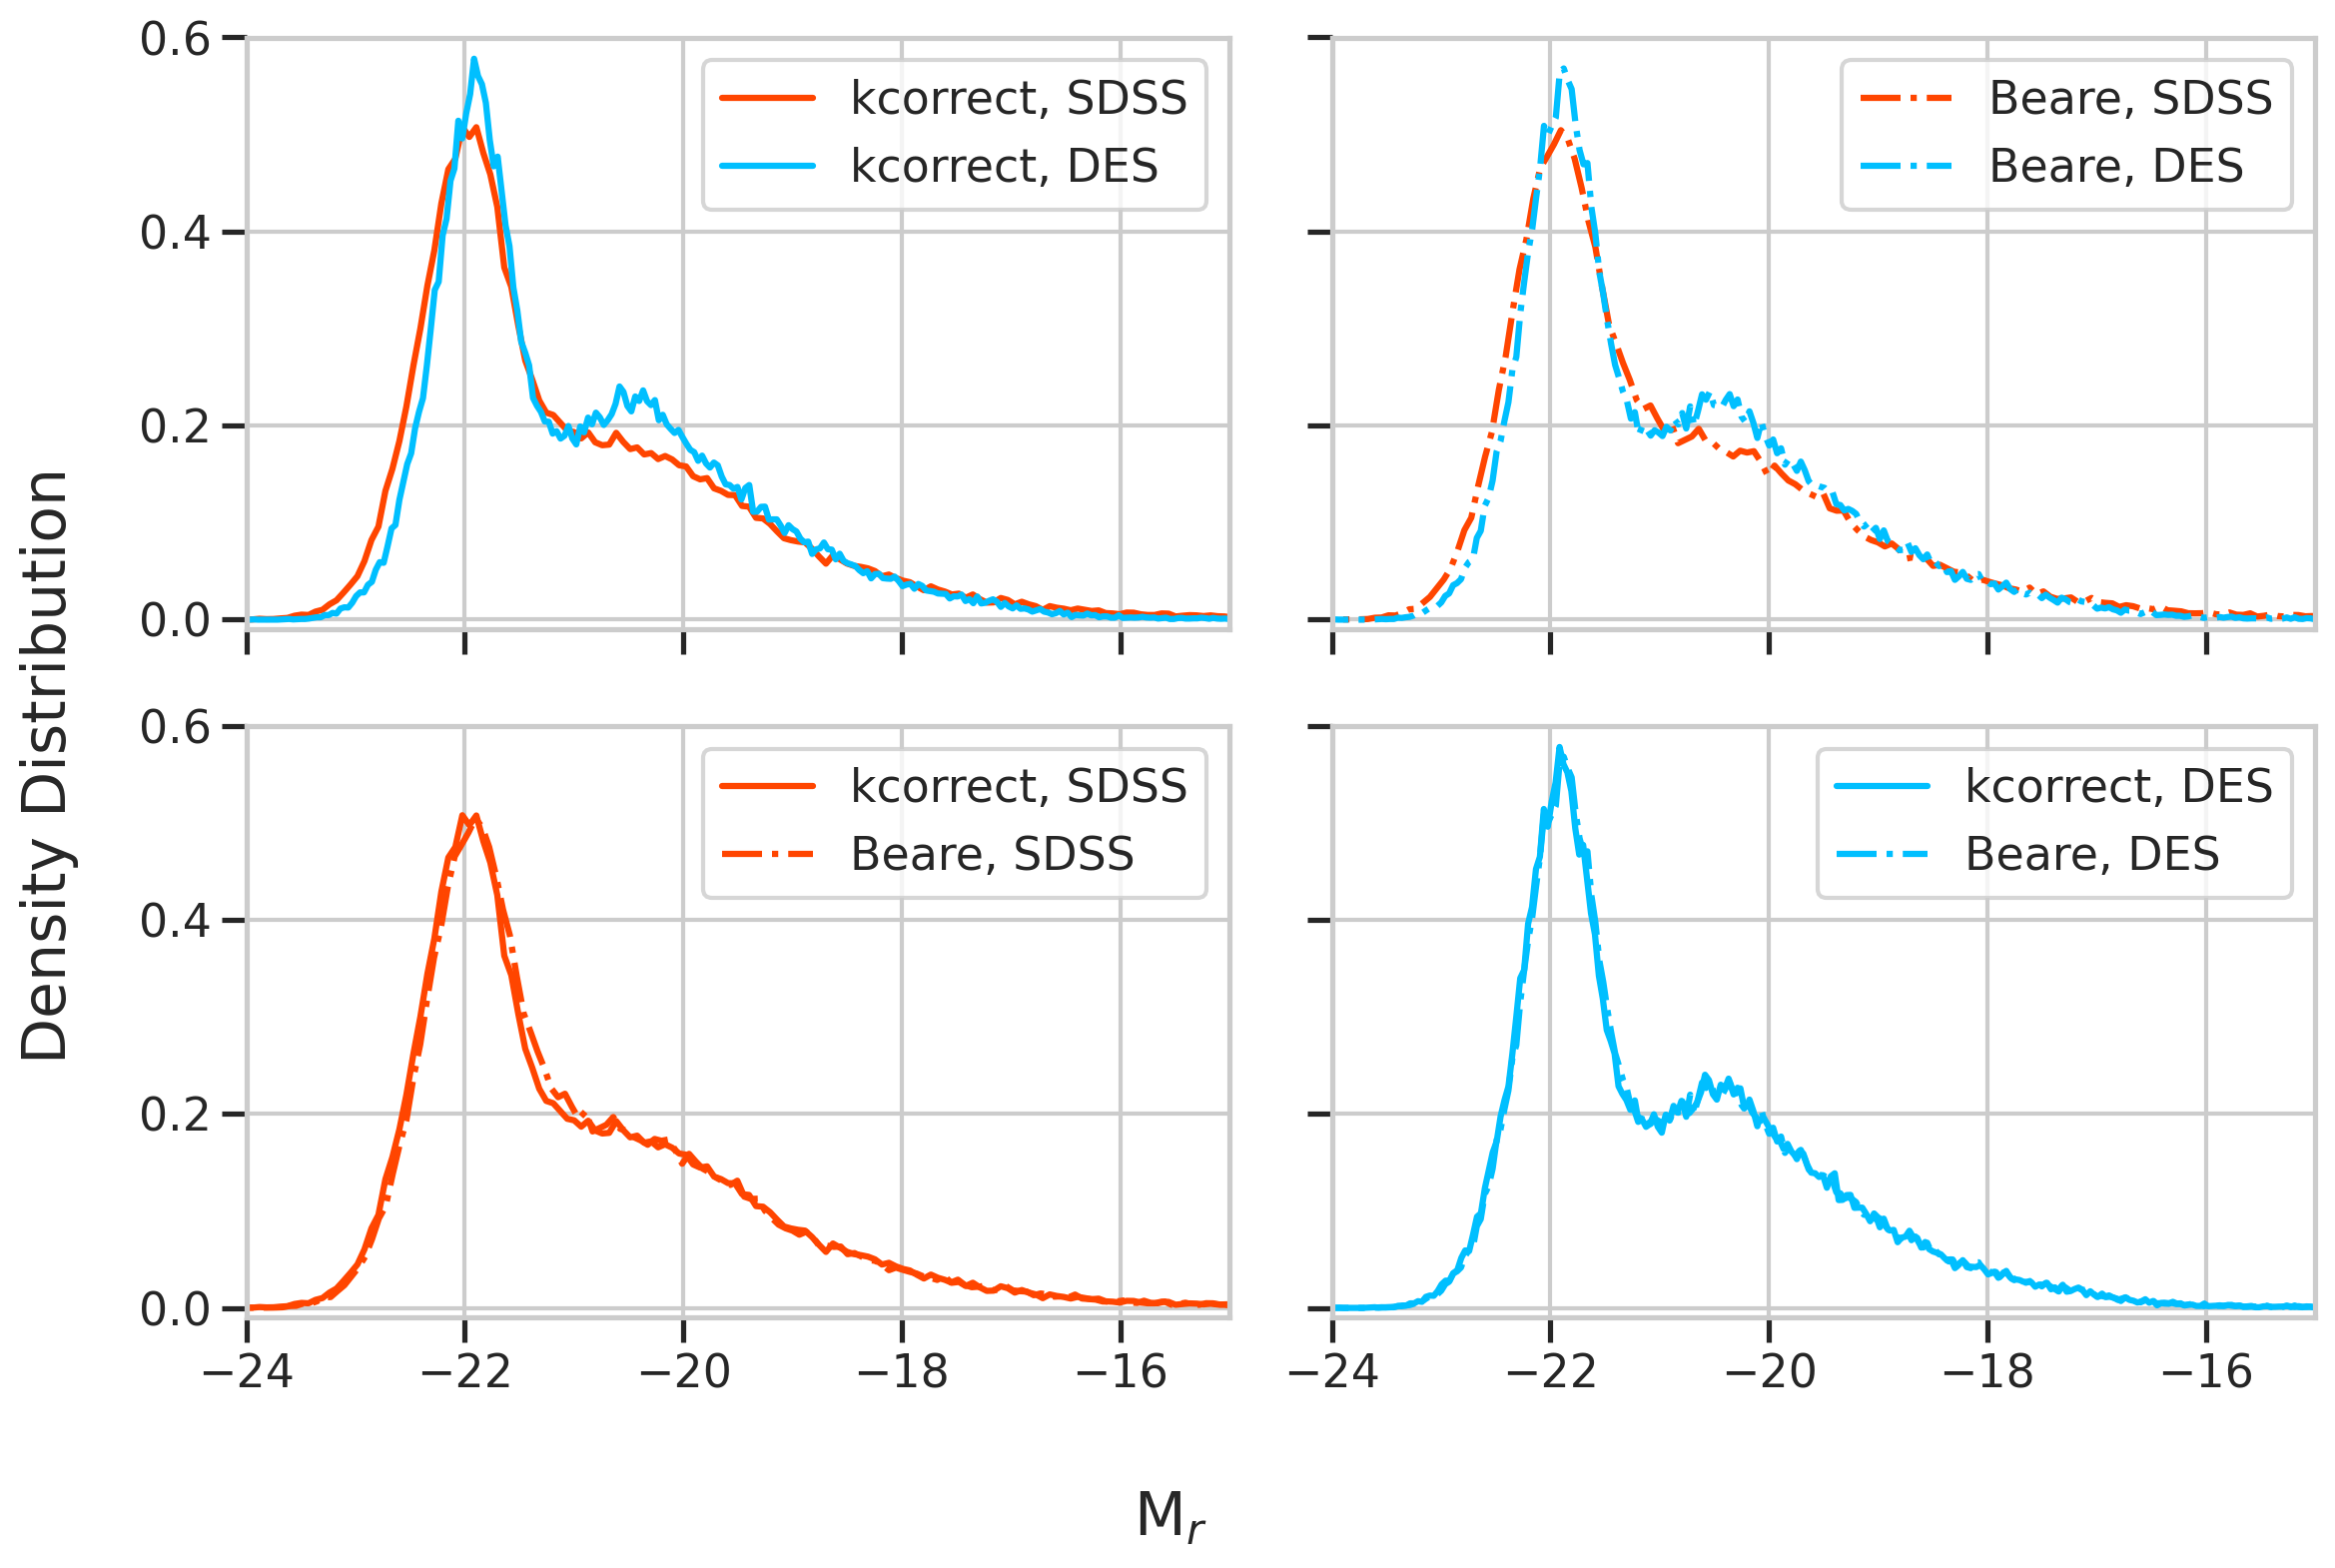

In [123]:
c1,e1 = np.histogram(M_SDSS[:,1],bins=500,density=True)
c2,e2 = np.histogram(M_DES[:,1],bins=500,density=True)
c3,e3 = np.histogram(susmag_SDSS[1],bins=500,density=True)
c4,e4 = np.histogram(susmag_DES[1],bins=500,density=True)

o1 = 0.5*(e1[1:]+e1[:-1])
o2 = 0.5*(e2[1:]+e2[:-1])
o3 = 0.5*(e3[1:]+e3[:-1])
o4 = 0.5*(e4[1:]+e4[:-1])

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12, 8),sharex=True,sharey=True,dpi=200)

ax[0][0].plot(o1,c1,label='kcorrect, SDSS',color='orangered',ls='-')
ax[0][0].plot(o2,c2,label='kcorrect, DES',color='deepskyblue',ls='-')
ax[0][1].plot(o3,c3,label='Beare, SDSS',color='orangered',ls='-.')
ax[0][1].plot(o4,c4,label='Beare, DES',color='deepskyblue',ls='-.')
ax[1][0].plot(o1,c1,color='orangered',label='kcorrect, SDSS')
ax[1][1].plot(o2,c2,color='deepskyblue',label='kcorrect, DES')
ax[1][0].plot(o3,c3,color='orangered',label='Beare, SDSS',ls='-.')
ax[1][1].plot(o4,c4,color='deepskyblue',label='Beare, DES',ls='-.')
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
ax[0][0].set_xbound(-24,-15)
ax[0][0].set_ybound(-0.01,0.6)

fig.supxlabel('M$_{r}$')
fig.supylabel('Density Distribution')
fig.tight_layout()
fig.savefig('figures/quadplot.png')
plt.show()

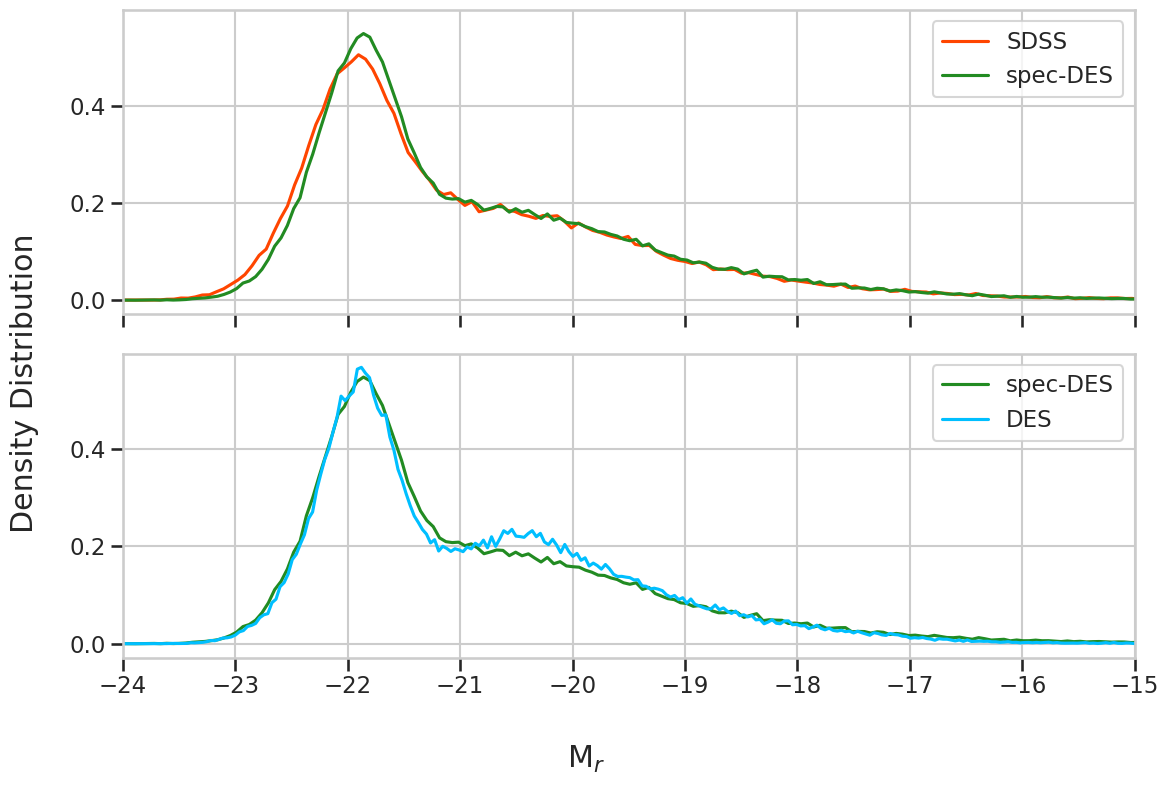

In [145]:
v=1
c1,e1 = np.histogram(susmag_SDSS[v],bins=500,density=True)
c2,e2 = np.histogram(susmag_SDES[v],bins=500,density=True)
c3,e3 = np.histogram(susmag_DES[v],bins=500,density=True)

o1 = 0.5*(e1[1:]+e1[:-1])
o2 = 0.5*(e2[1:]+e2[:-1])
o3 = 0.5*(e3[1:]+e3[:-1])

fig,ax = plt.subplots(nrows=2,figsize=(12, 8),sharex=True,sharey=True,dpi=100)

ax[0].plot(o1,c1,label='SDSS',color='orangered')
ax[0].plot(o2,c2,label='spec-DES',color='forestgreen')
ax[0].legend()
ax[0].set_xbound(-24,-15)


ax[1].plot(o2,c2,label='spec-DES',color='forestgreen')
ax[1].plot(o3,c3,label='DES',color='deepskyblue')
ax[1].legend()
ax[1].set_xbound(-24,-15)

fig.supxlabel('M$_{r}$')
fig.supylabel('Density Distribution')

fig.tight_layout()
fig.savefig('figures/quadplot_sdes.png')
plt.show()

(-25.0, -14.0)

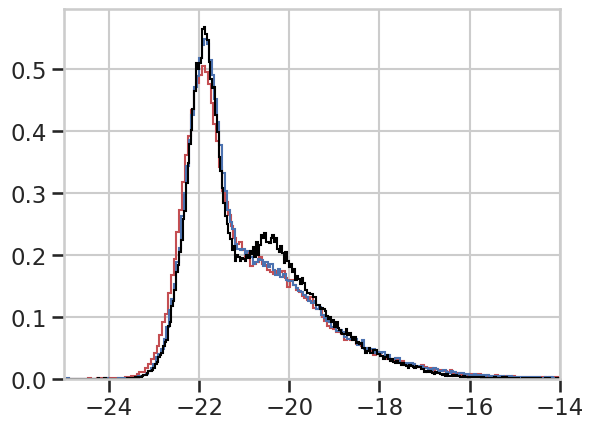

In [24]:
rrrrrr = plt.hist(susmag_SDSS[1],bins=500,histtype='step',density=True,color='r')
tttttt = plt.hist(susmag_SDES[1],bins=500,histtype='step',density=True,color='b')
pppppp = plt.hist(susmag_DES[1],bins=500,histtype='step',density=True,color='black')
plt.xlim(-25,-14)

In [25]:
from scipy.interpolate import CubicSpline
O_m = 0.3065
O_l = 1-O_m

def comoving_distance(z_array, n_points=10):
    x = z_array[:, None] * np.linspace(0, 1, n_points)
    dx = z_array * 1./(n_points-1)
    y = (O_m*((1+x)**3)+O_l)**-0.5
    avg_y = (y[:,:-1]+y[:,1:])/2
    return np.sum(dx[:, np.newaxis]*avg_y, axis=1) * 299792.458 / H0

def comoving_volume(z, n_points=10):
    return 4.18879 * (comoving_distance(z, n_points)**3)

z_table = np.linspace(0, 2, 100000)
dc_table = comoving_distance(z_table, 1000)
vc_table = 4.18879 * (dc_table**3)
z_to_vc = CubicSpline(z_table, vc_table)
vc_to_z = CubicSpline(vc_table, z_table)

vc_max = z_to_vc(0.7)
choices = np.random.random(int(1e7)) * vc_max
uniform_gal_z = vc_to_z(choices)
hist, bin_edges = np.histogram(uniform_gal_z, bins=200, range=[0, 0.7])
interp_dn = CubicSpline(bin_edges[1:]-(bin_edges[1]-bin_edges[0]), hist/np.sum(hist))

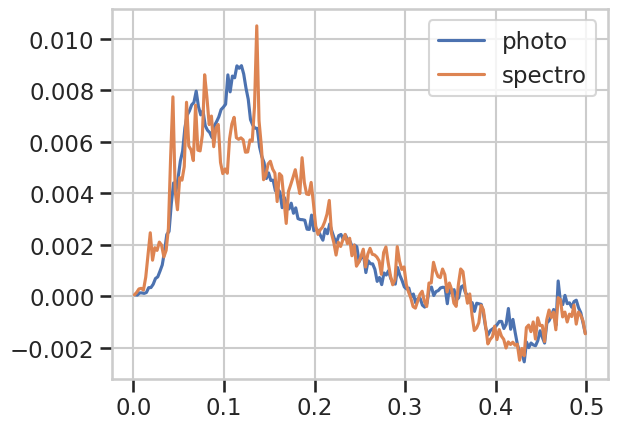

In [26]:
a,b = np.histogram(phot_z,bins=200)
edges = 0.5*(b[1:]+b[:-1])
plt.plot(edges,a/np.sum(a) - interp_dn(edges),label='photo')
a,b = np.histogram(spec_z,bins=200)
edges = 0.5*(b[1:]+b[:-1])
plt.plot(edges,a/np.sum(a) - interp_dn(edges),label='spectro')
plt.legend()

/tmp/ipykernel_20062/885416583.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = float(opt[np.where(c==c.max())])


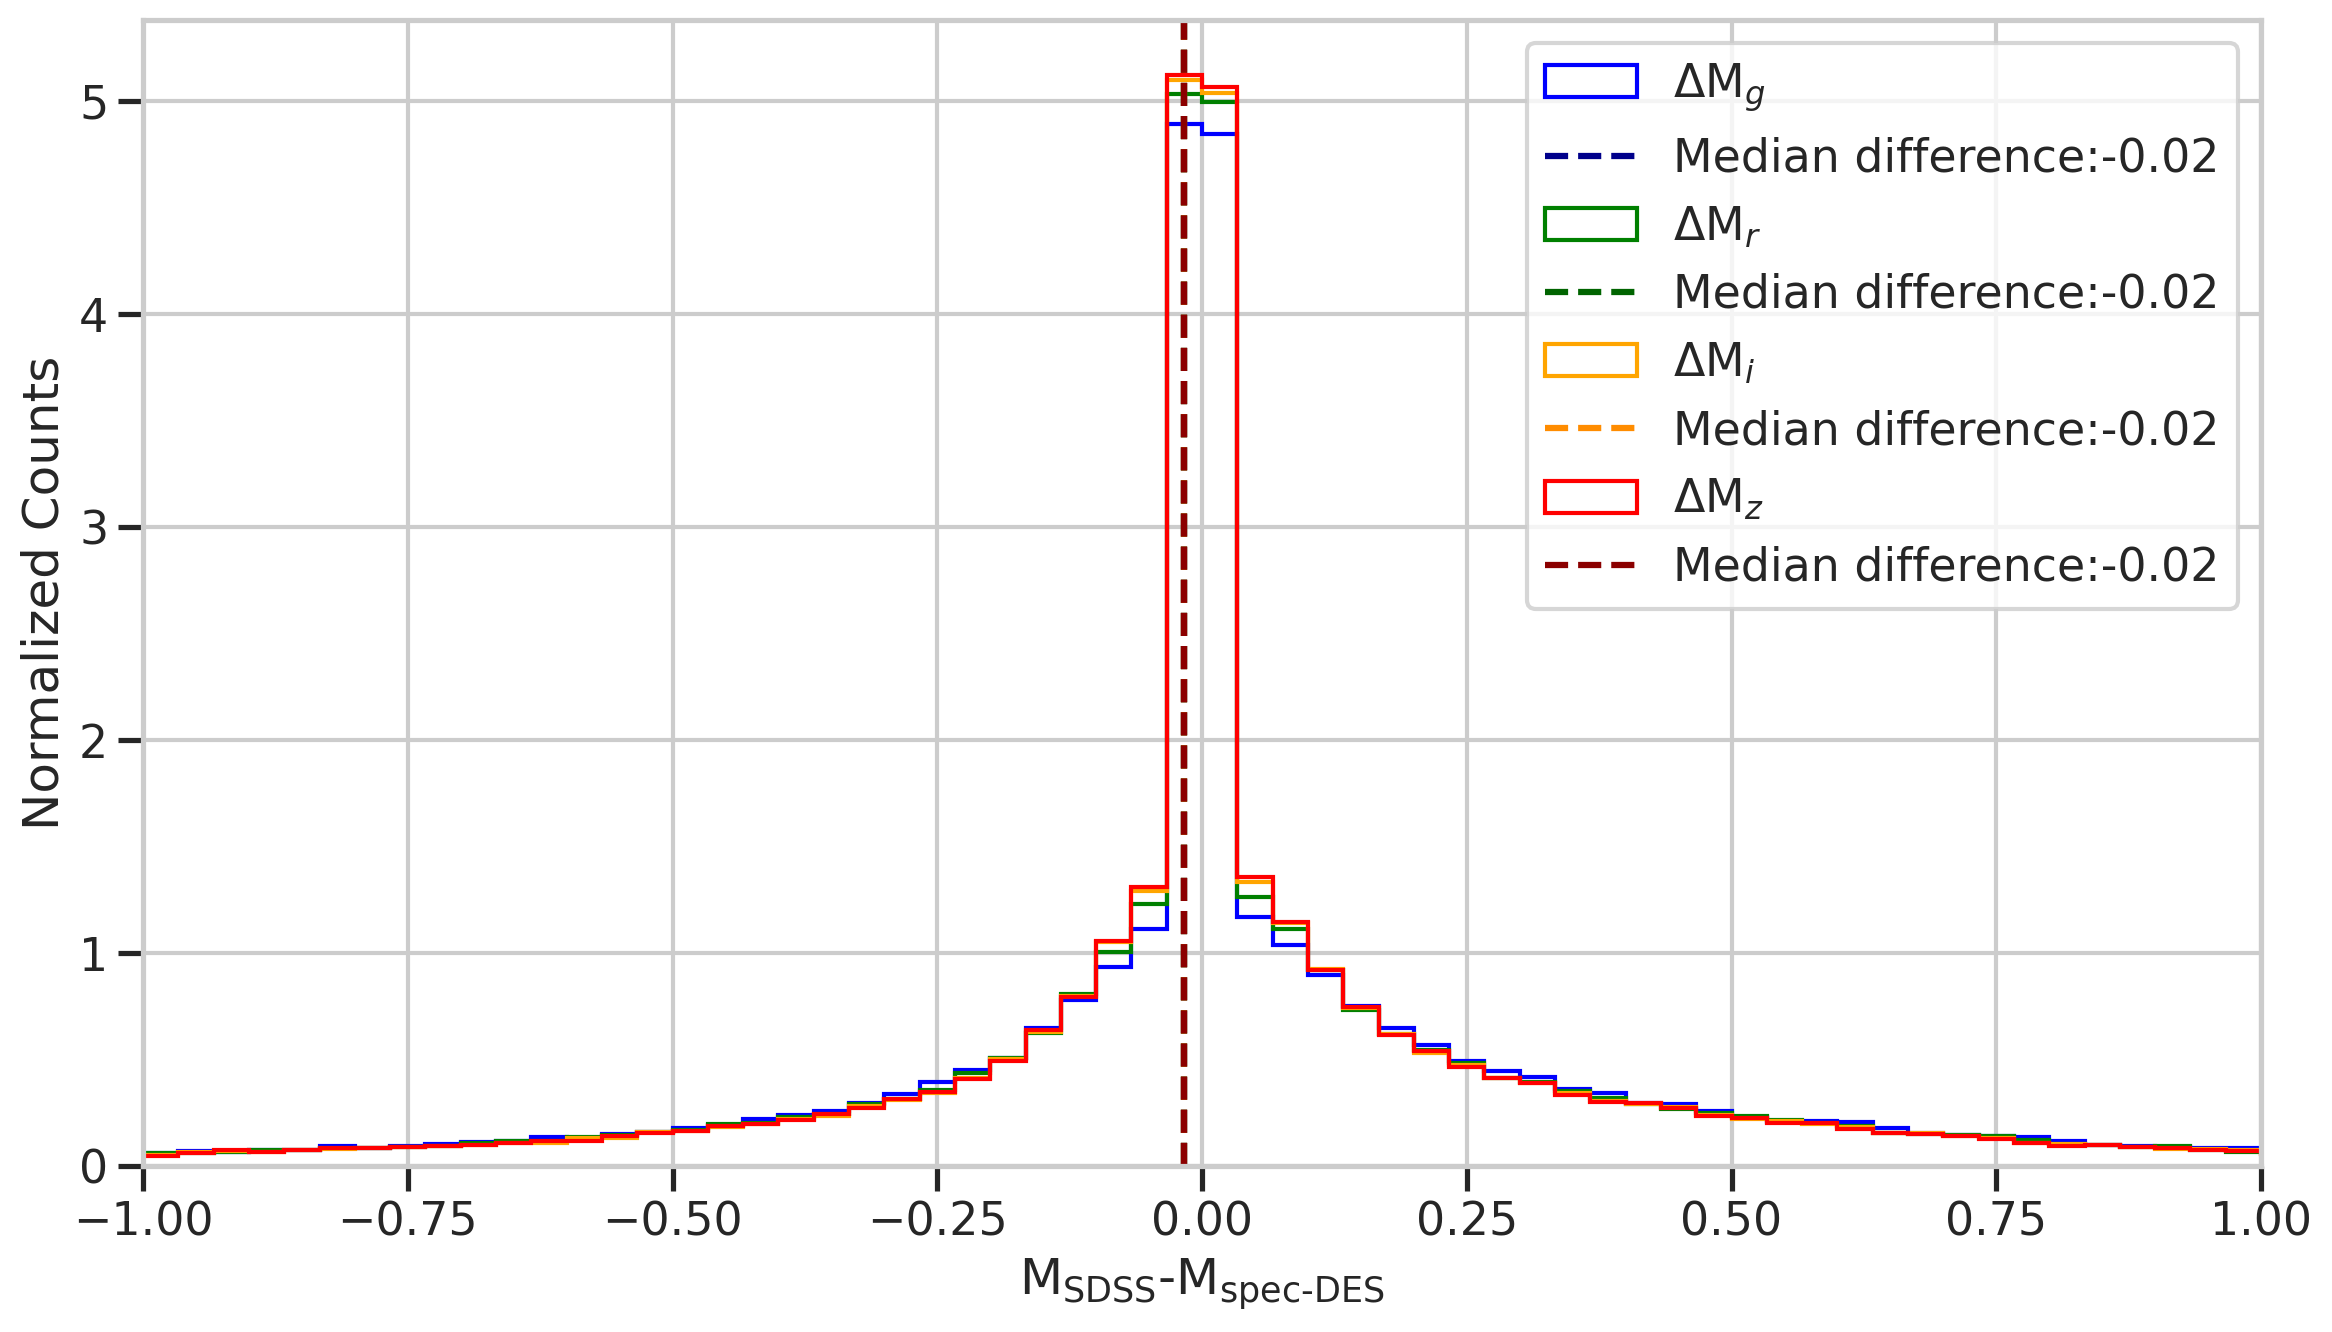

In [144]:
fig, ax = plt.subplots(figsize=(12, 7),dpi=200)
bands = ['g','r','i','z']
colors = ['blue','green','orange','red']
dcolors = ['darkblue','darkgreen','darkorange','darkred']
for i in range(4):
    sloansdes = (susmag_SDSS[i] - susmag_SDES[i])
    dessdes = (susmag_DES[i] - susmag_SDES[i])
    
    sloanmean = np.mean(sloansdes)
    sloanstd = np.std(sloansdes)
    desmean = np.mean(dessdes)
    desstd = np.std(dessdes)
    
    #c,e,b = ax.hist(sloansdes,bins=150,density=True,histtype='step',label=f'$\Delta$M$_{bands[i]}$',color=colors[i],range=[-2.5,2.5]) 
    c,e,b = ax.hist(dessdes,bins=150,density=True,histtype='step',label=f'$\Delta$M$_{bands[i]}$',color=colors[i],range=[-2.5,2.5])

    opt= 0.5*(e[1:]+e[:-1])
    val = float(opt[np.where(c==c.max())])
    ax.axvline(opt[np.where(c==c.max())],color=dcolors[i],ls='--',label=f'Median difference:{val:.2f}')
    
    ax.legend(loc='upper right')
ax.set_xbound(-1,1)
ax.set_xlabel(r'M$_{\text{SDSS}}$-M$_{\text{spec-DES}}$')
ax.set_ylabel('Normalized Counts')
fig.tight_layout()
#fig.savefig('delta_sdes_sdss.png')
plt.show()

In [141]:
import seaborn as sns

sns.set_theme('talk')
sns.set_style('whitegrid', {'xtick.bottom':True, 'ytick.left':True})
sns.plotting_context('talk')

{'axes.linewidth': 1.875,
 'grid.linewidth': 1.5,
 'lines.linewidth': 2.25,
 'lines.markersize': 9.0,
 'patch.linewidth': 1.5,
 'xtick.major.width': 1.875,
 'ytick.major.width': 1.875,
 'xtick.minor.width': 1.5,
 'ytick.minor.width': 1.5,
 'xtick.major.size': 9.0,
 'ytick.major.size': 9.0,
 'xtick.minor.size': 6.0,
 'ytick.minor.size': 6.0,
 'font.size': 18.0,
 'axes.labelsize': 18.0,
 'axes.titlesize': 18.0,
 'xtick.labelsize': 16.5,
 'ytick.labelsize': 16.5,
 'legend.fontsize': 16.5,
 'legend.title_fontsize': 18.0}

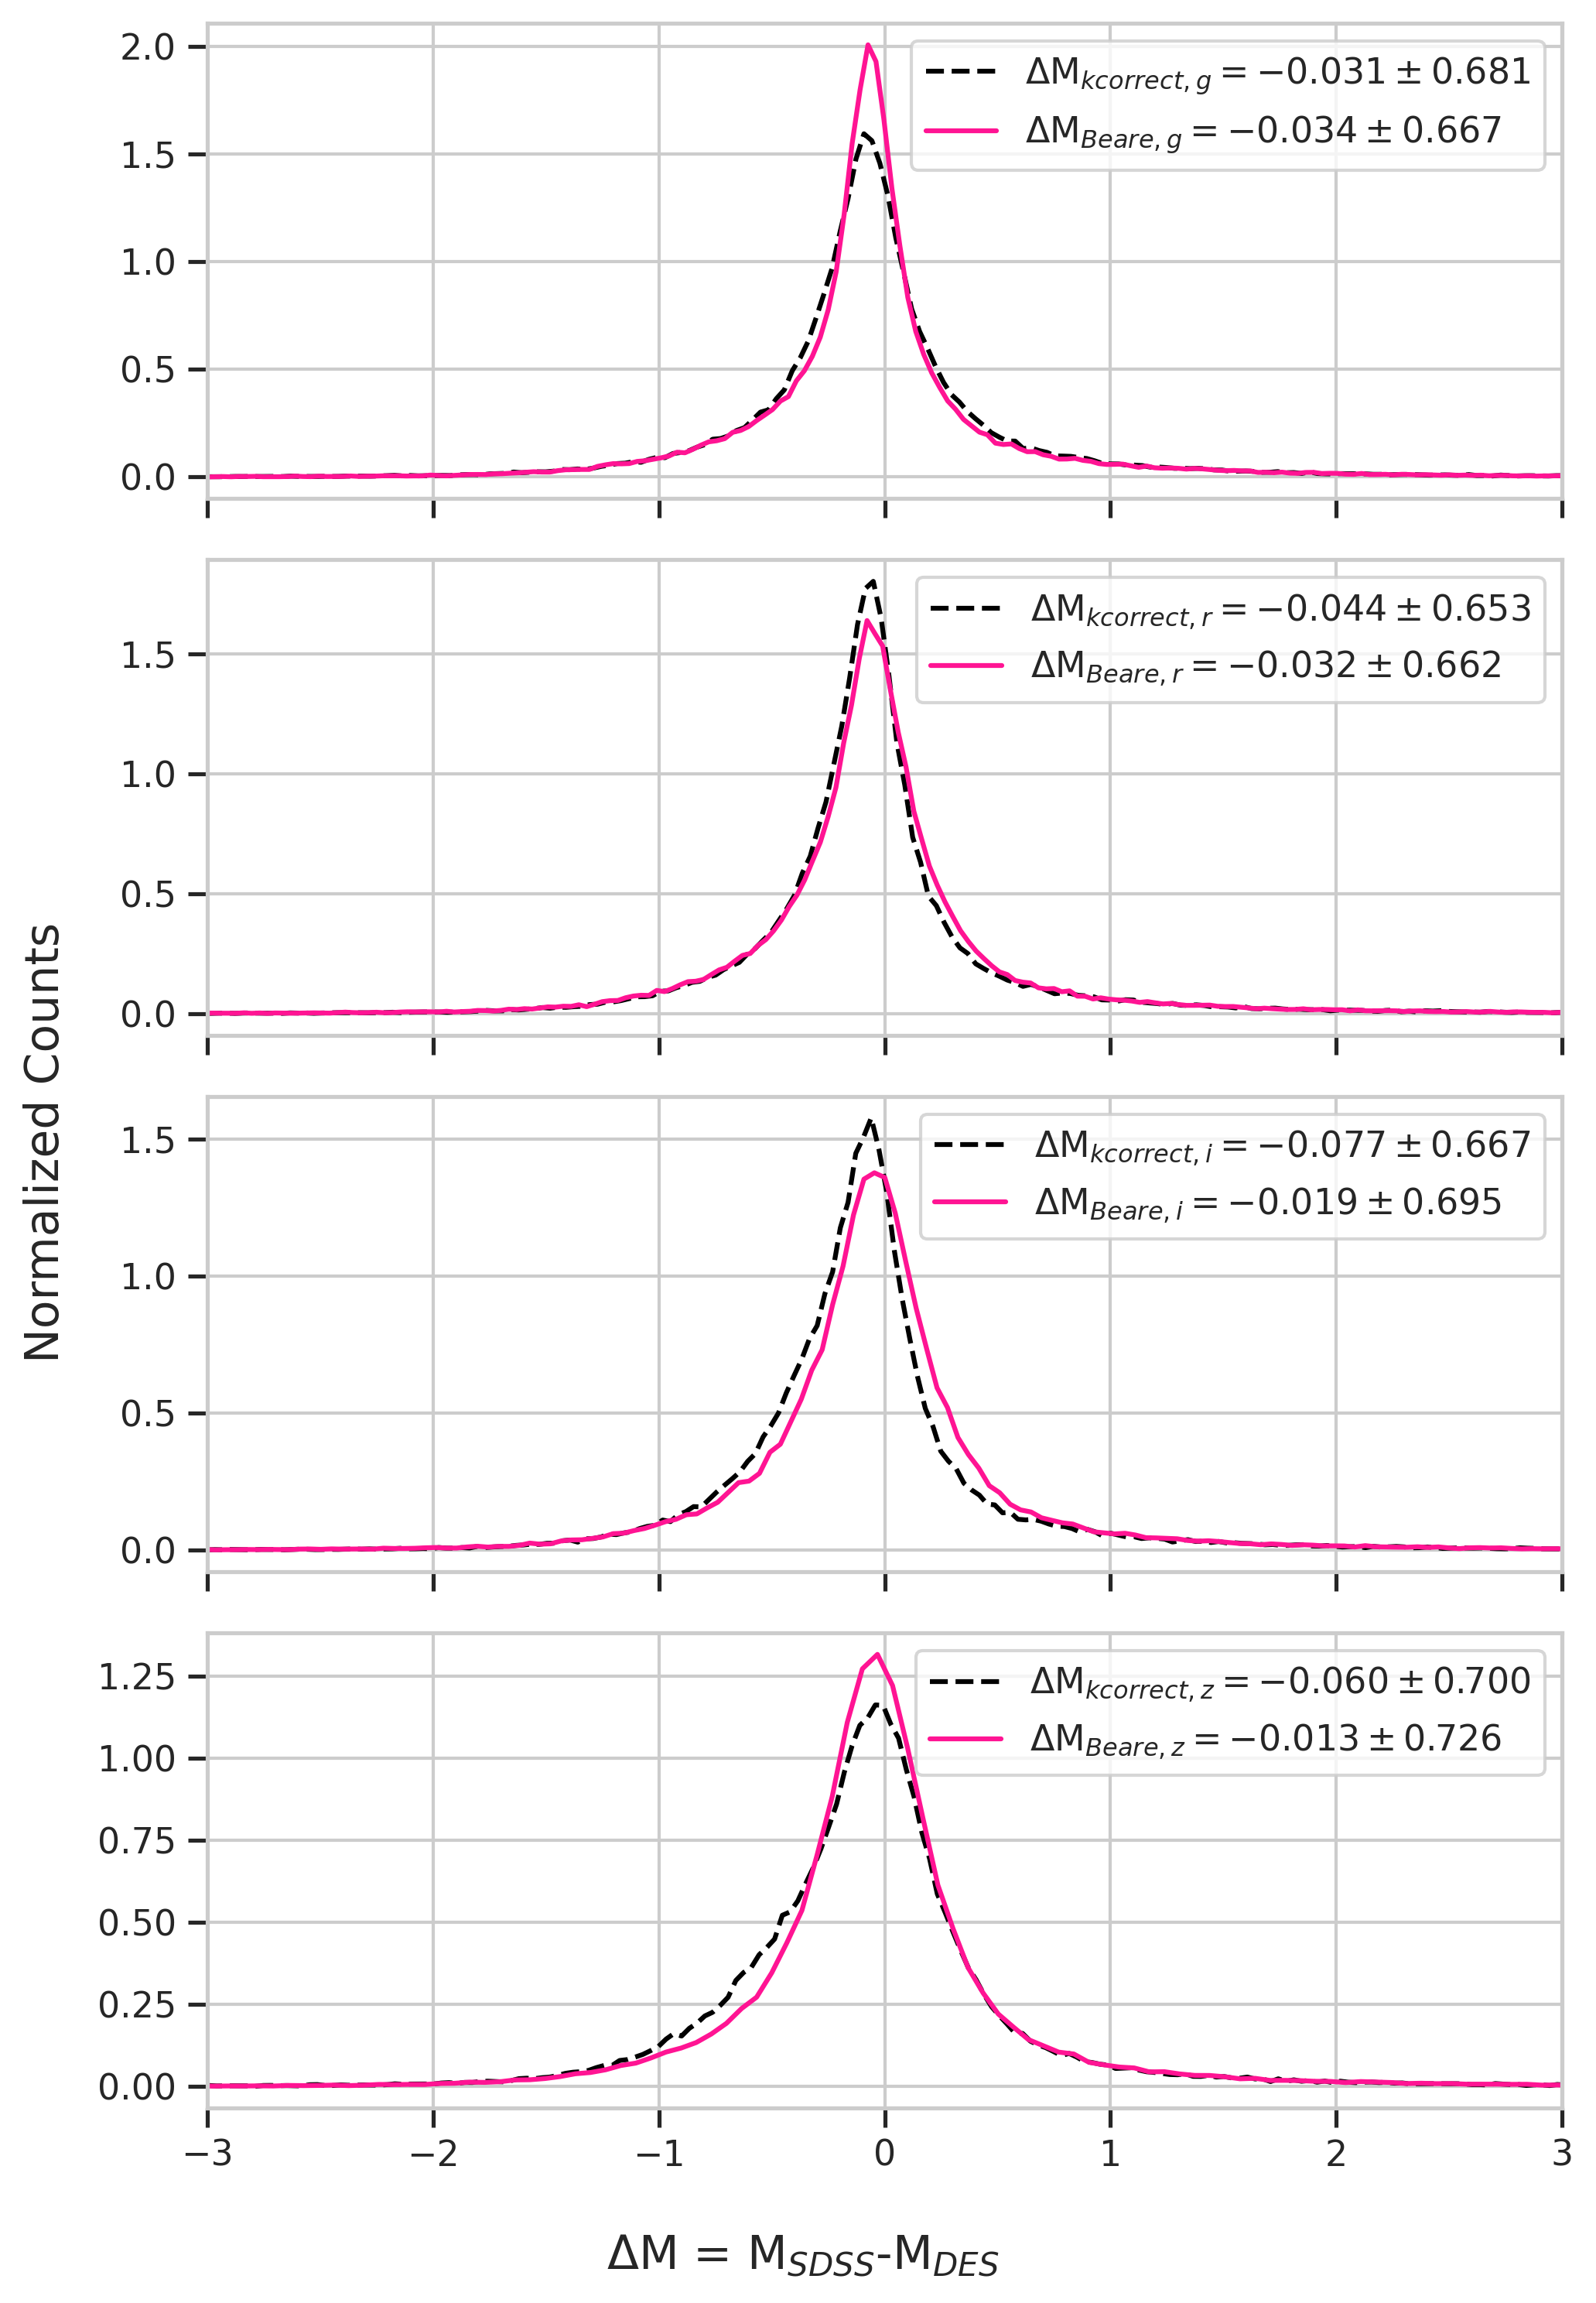

In [132]:
fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    kdiff = (M_SDSS[:,i] - M_DES[:,i])
    bdiff = (susmag_SDSS[i] - susmag_DES[i])
    
    kmean = np.mean(kdiff)
    kstd = np.std(kdiff)
    
    bmean = np.mean(bdiff)
    bstd = np.std(bdiff)
    
    counts, edges = np.histogram(kdiff,bins=1000,density=True)
    opte = 0.5*(edges[1:]+edges[:-1])

    countsa, edgesa = np.histogram(bdiff, bins=1000,density=True)
    optea = 0.5*(edgesa[1:]+edgesa[:-1])

    ax[i].plot(opte,counts,color='black',ls='--',label=f'$\Delta$M$_{{kcorrect, {bands[i]}}} = {kmean:.3f}\pm{kstd:.3f}$')
    ax[i].plot(optea,countsa,color='deeppink',ls='-',label=f'$\Delta$M$_{{Beare, {bands[i]}}} = {bmean:.3f}\pm{bstd:.3f}$')

    ax[i].legend(loc='upper right')
ax[0].set_xbound(-3,3)
fig.supxlabel('$\Delta$M = M$_{SDSS}$-M$_{DES}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_kcorr_vs_beare_allbands.png')
plt.show()

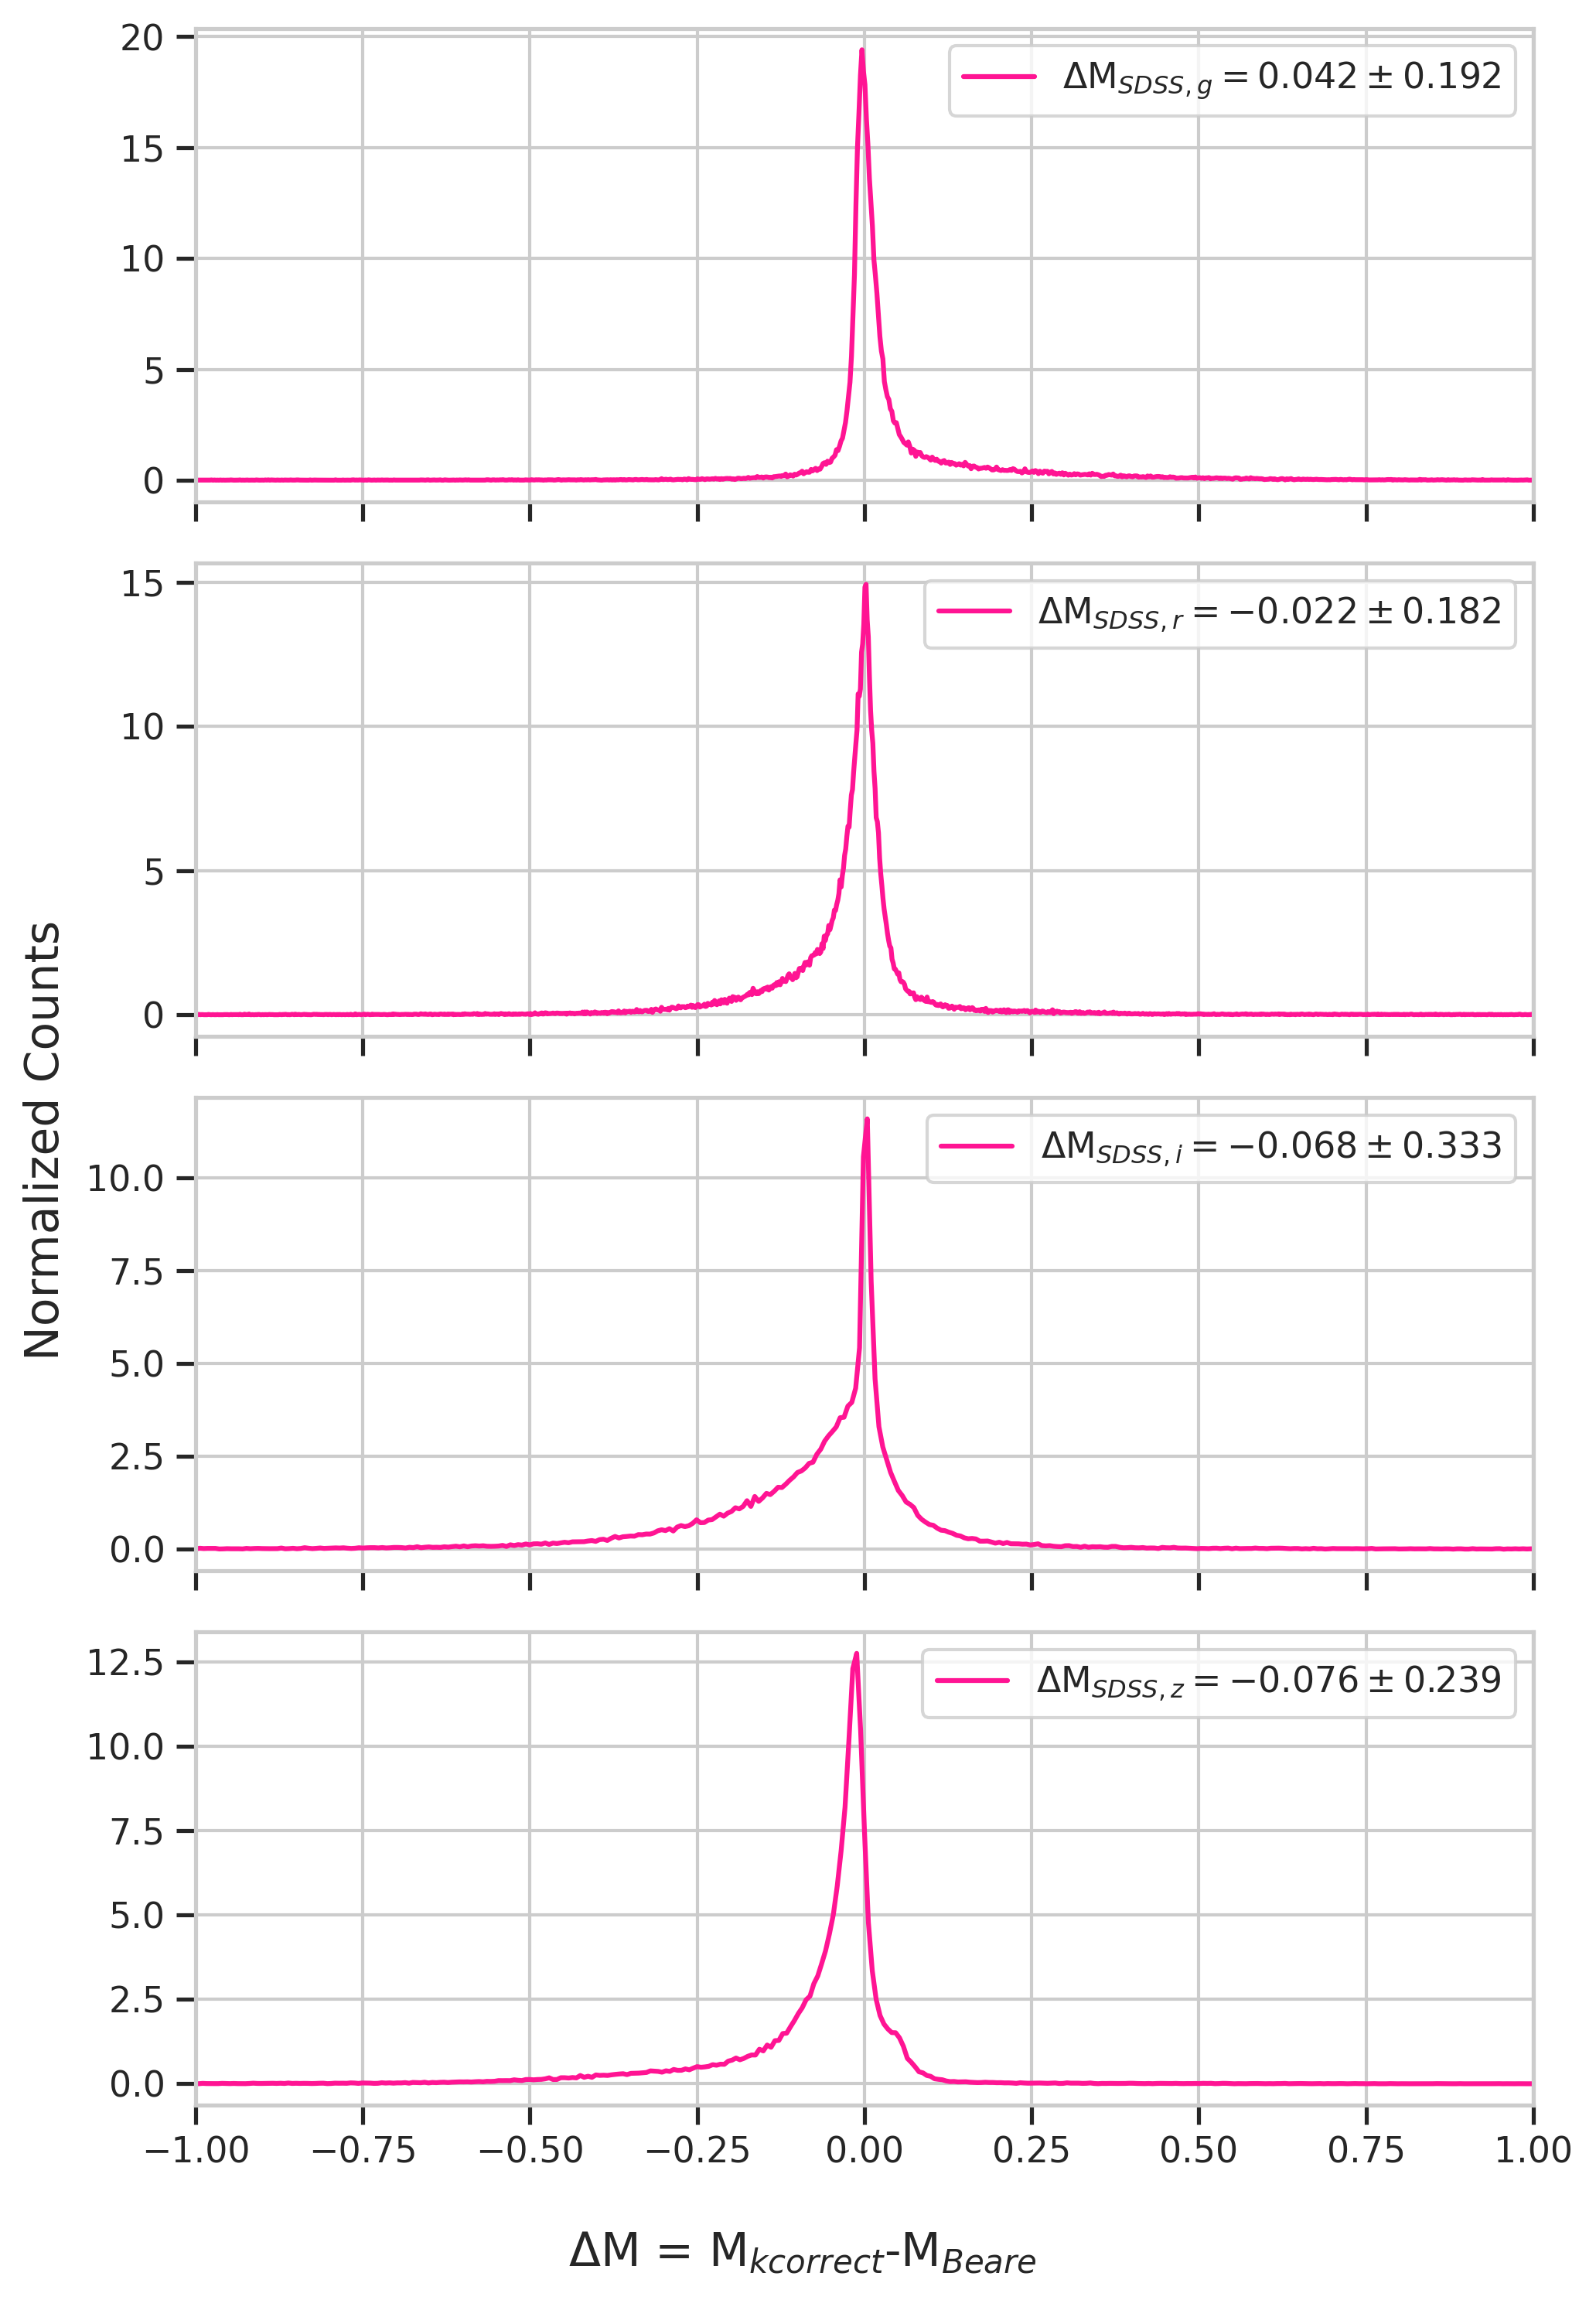

In [131]:
fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    counts, edges = np.histogram((M_SDSS[:,i] - susmag_SDSS[i]),bins=8000,density=True)
    opte = 0.5*(edges[1:]+edges[:-1])

    sdssmean = np.mean(M_SDSS[:,i] - susmag_SDSS[i])
    sdssstd = np.std(M_SDSS[:,i] - susmag_SDSS[i])
    
    ax[i].plot(opte,counts,color='deeppink',ls='-',label=f'$\Delta$M$_{{SDSS, {bands[i]}}} = {sdssmean:.3f}\pm{sdssstd:.3f}$')

    ax[i].legend(loc='upper right')

ax[0].set_xbound(-1,1)
fig.supxlabel('$\Delta$M = M$_{kcorrect}$-M$_{Beare}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_sdss.png')
plt.show()

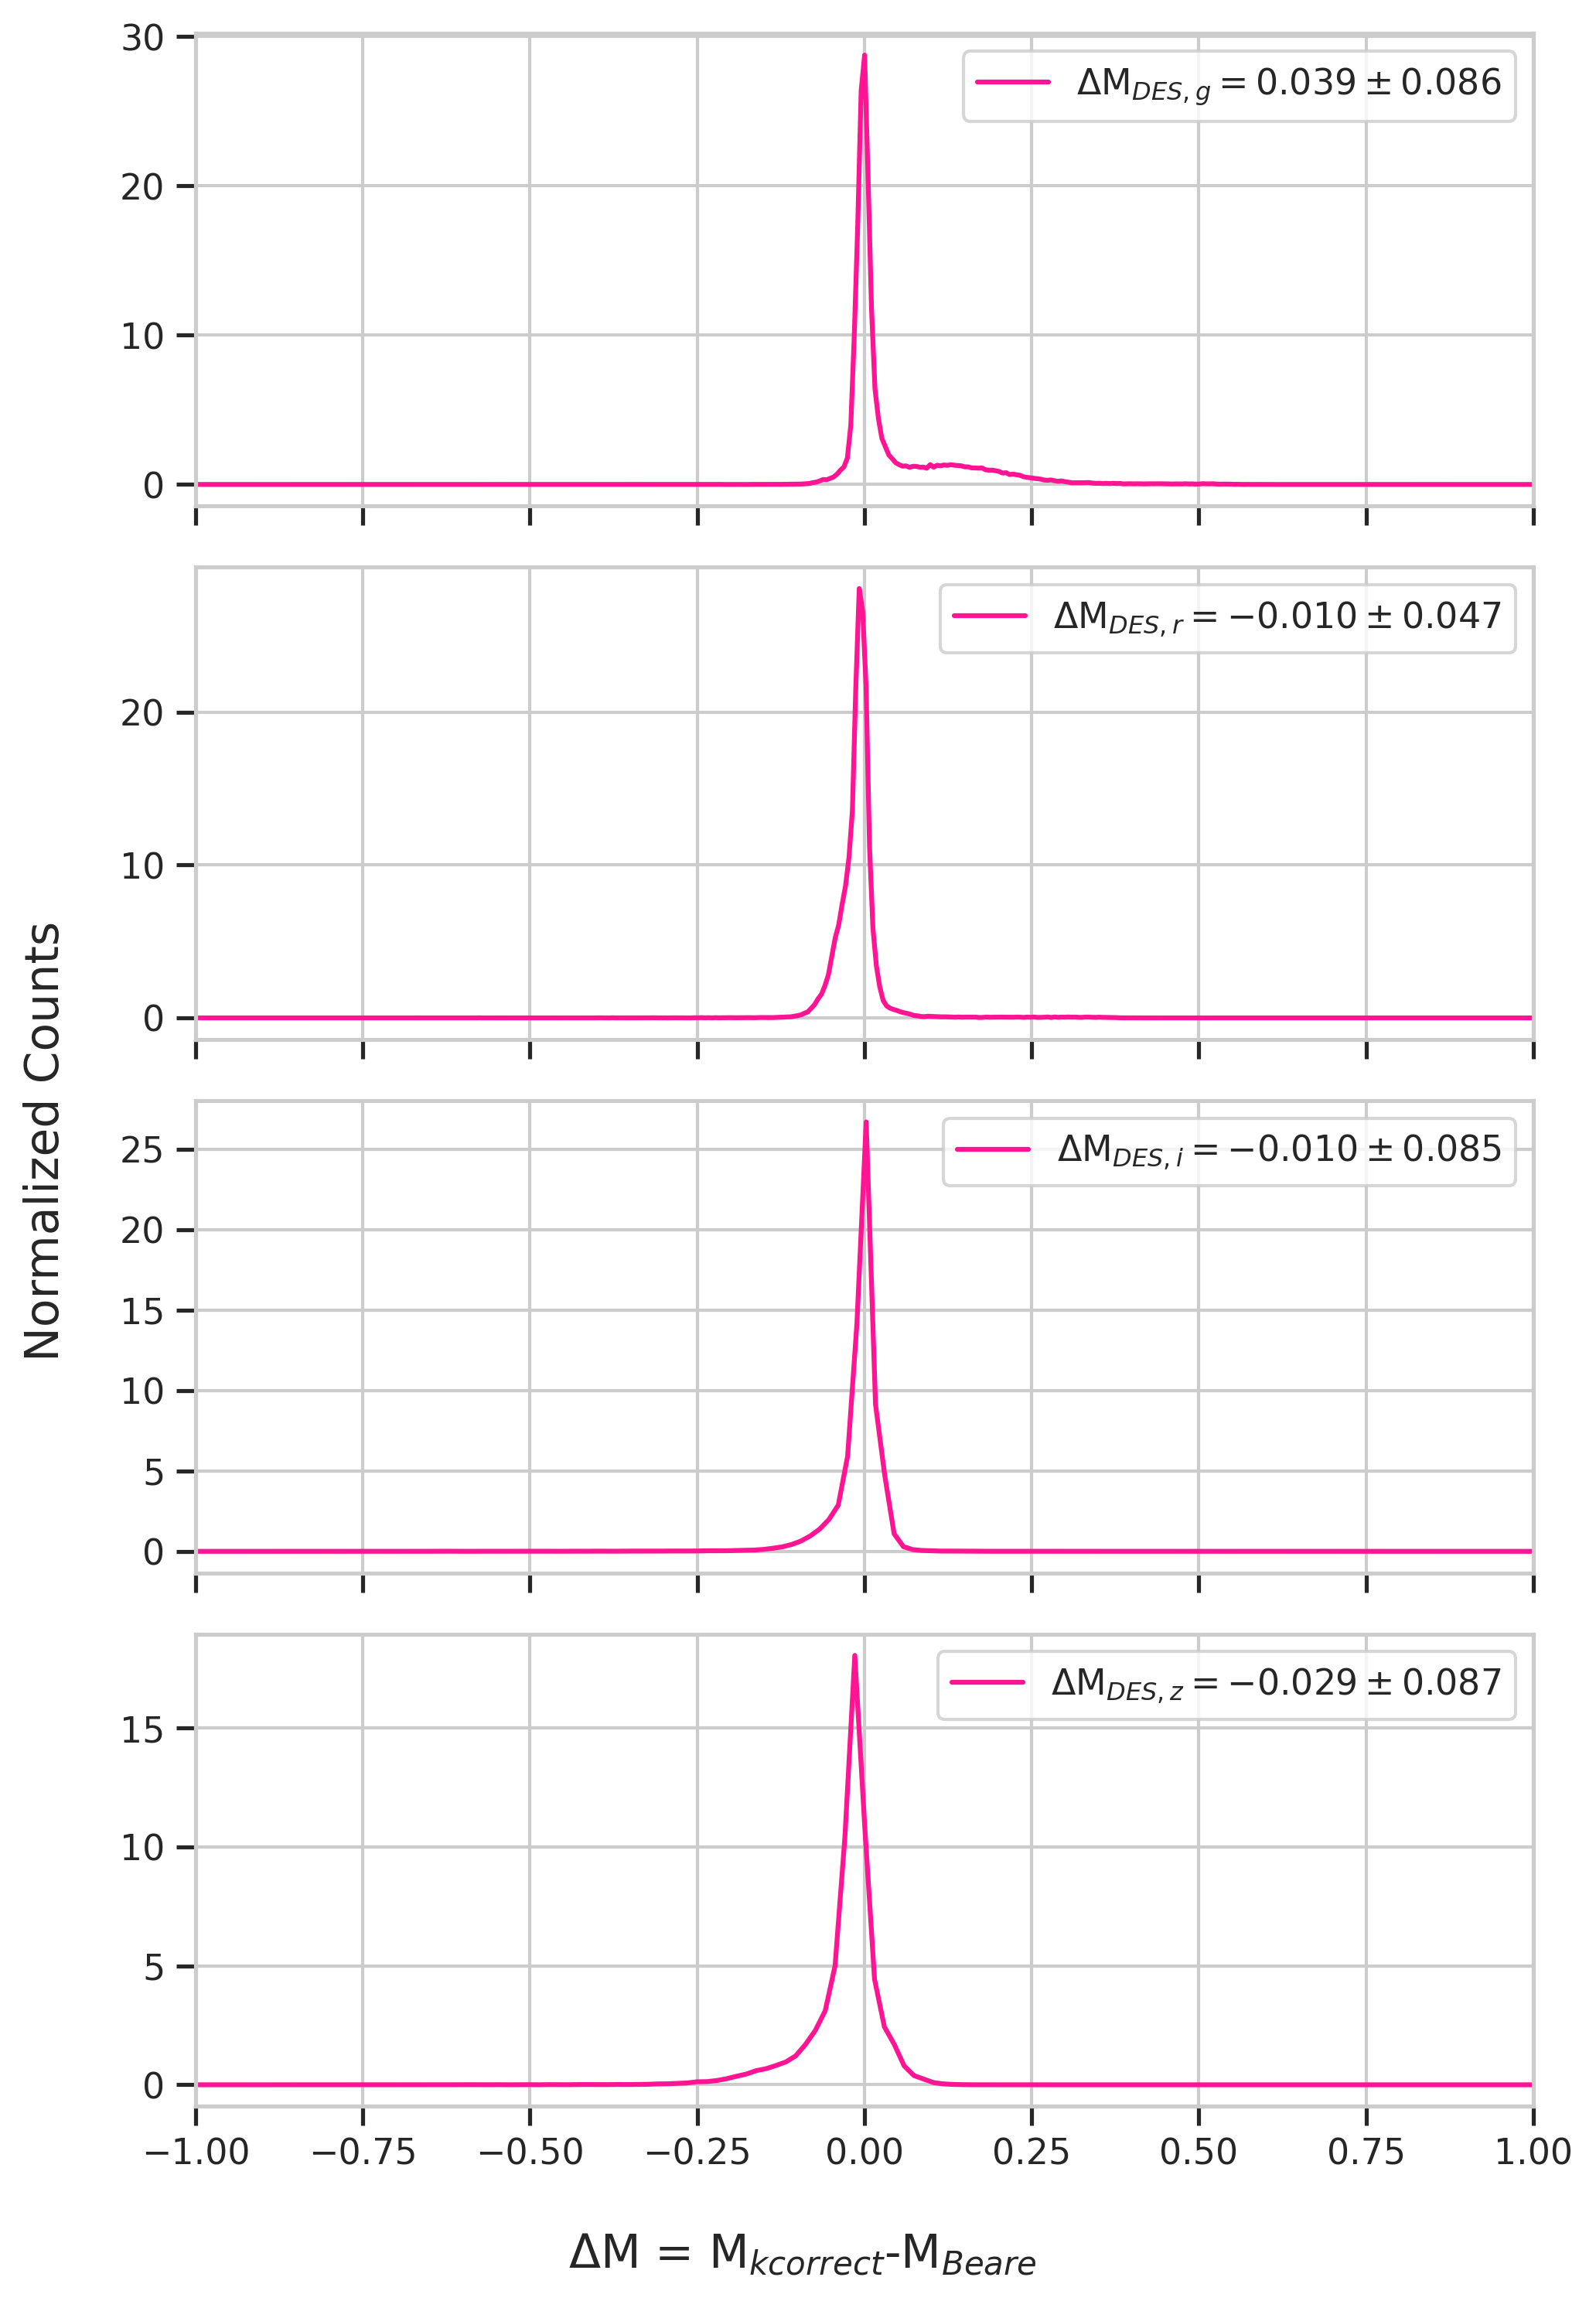

In [130]:
fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    diff = (M_DES[:,i] - susmag_DES[i])
    countsa, edgesa = np.histogram(diff, bins=1000,density=True)
    optea = 0.5*(edgesa[1:]+edgesa[:-1])
    
    desmean = np.mean(diff)
    desstd = np.std(diff)

    ax[i].plot(optea,countsa,color='deeppink',ls='-',label=f'$\Delta$M$_{{DES, {bands[i]}}} = {desmean:.3f}\pm{desstd:.3f}$')
    
    ax[i].legend(loc='upper right')
ax[0].set_xbound(-1,1)
fig.supxlabel('$\Delta$M = M$_{kcorrect}$-M$_{Beare}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_des.png')
plt.show()

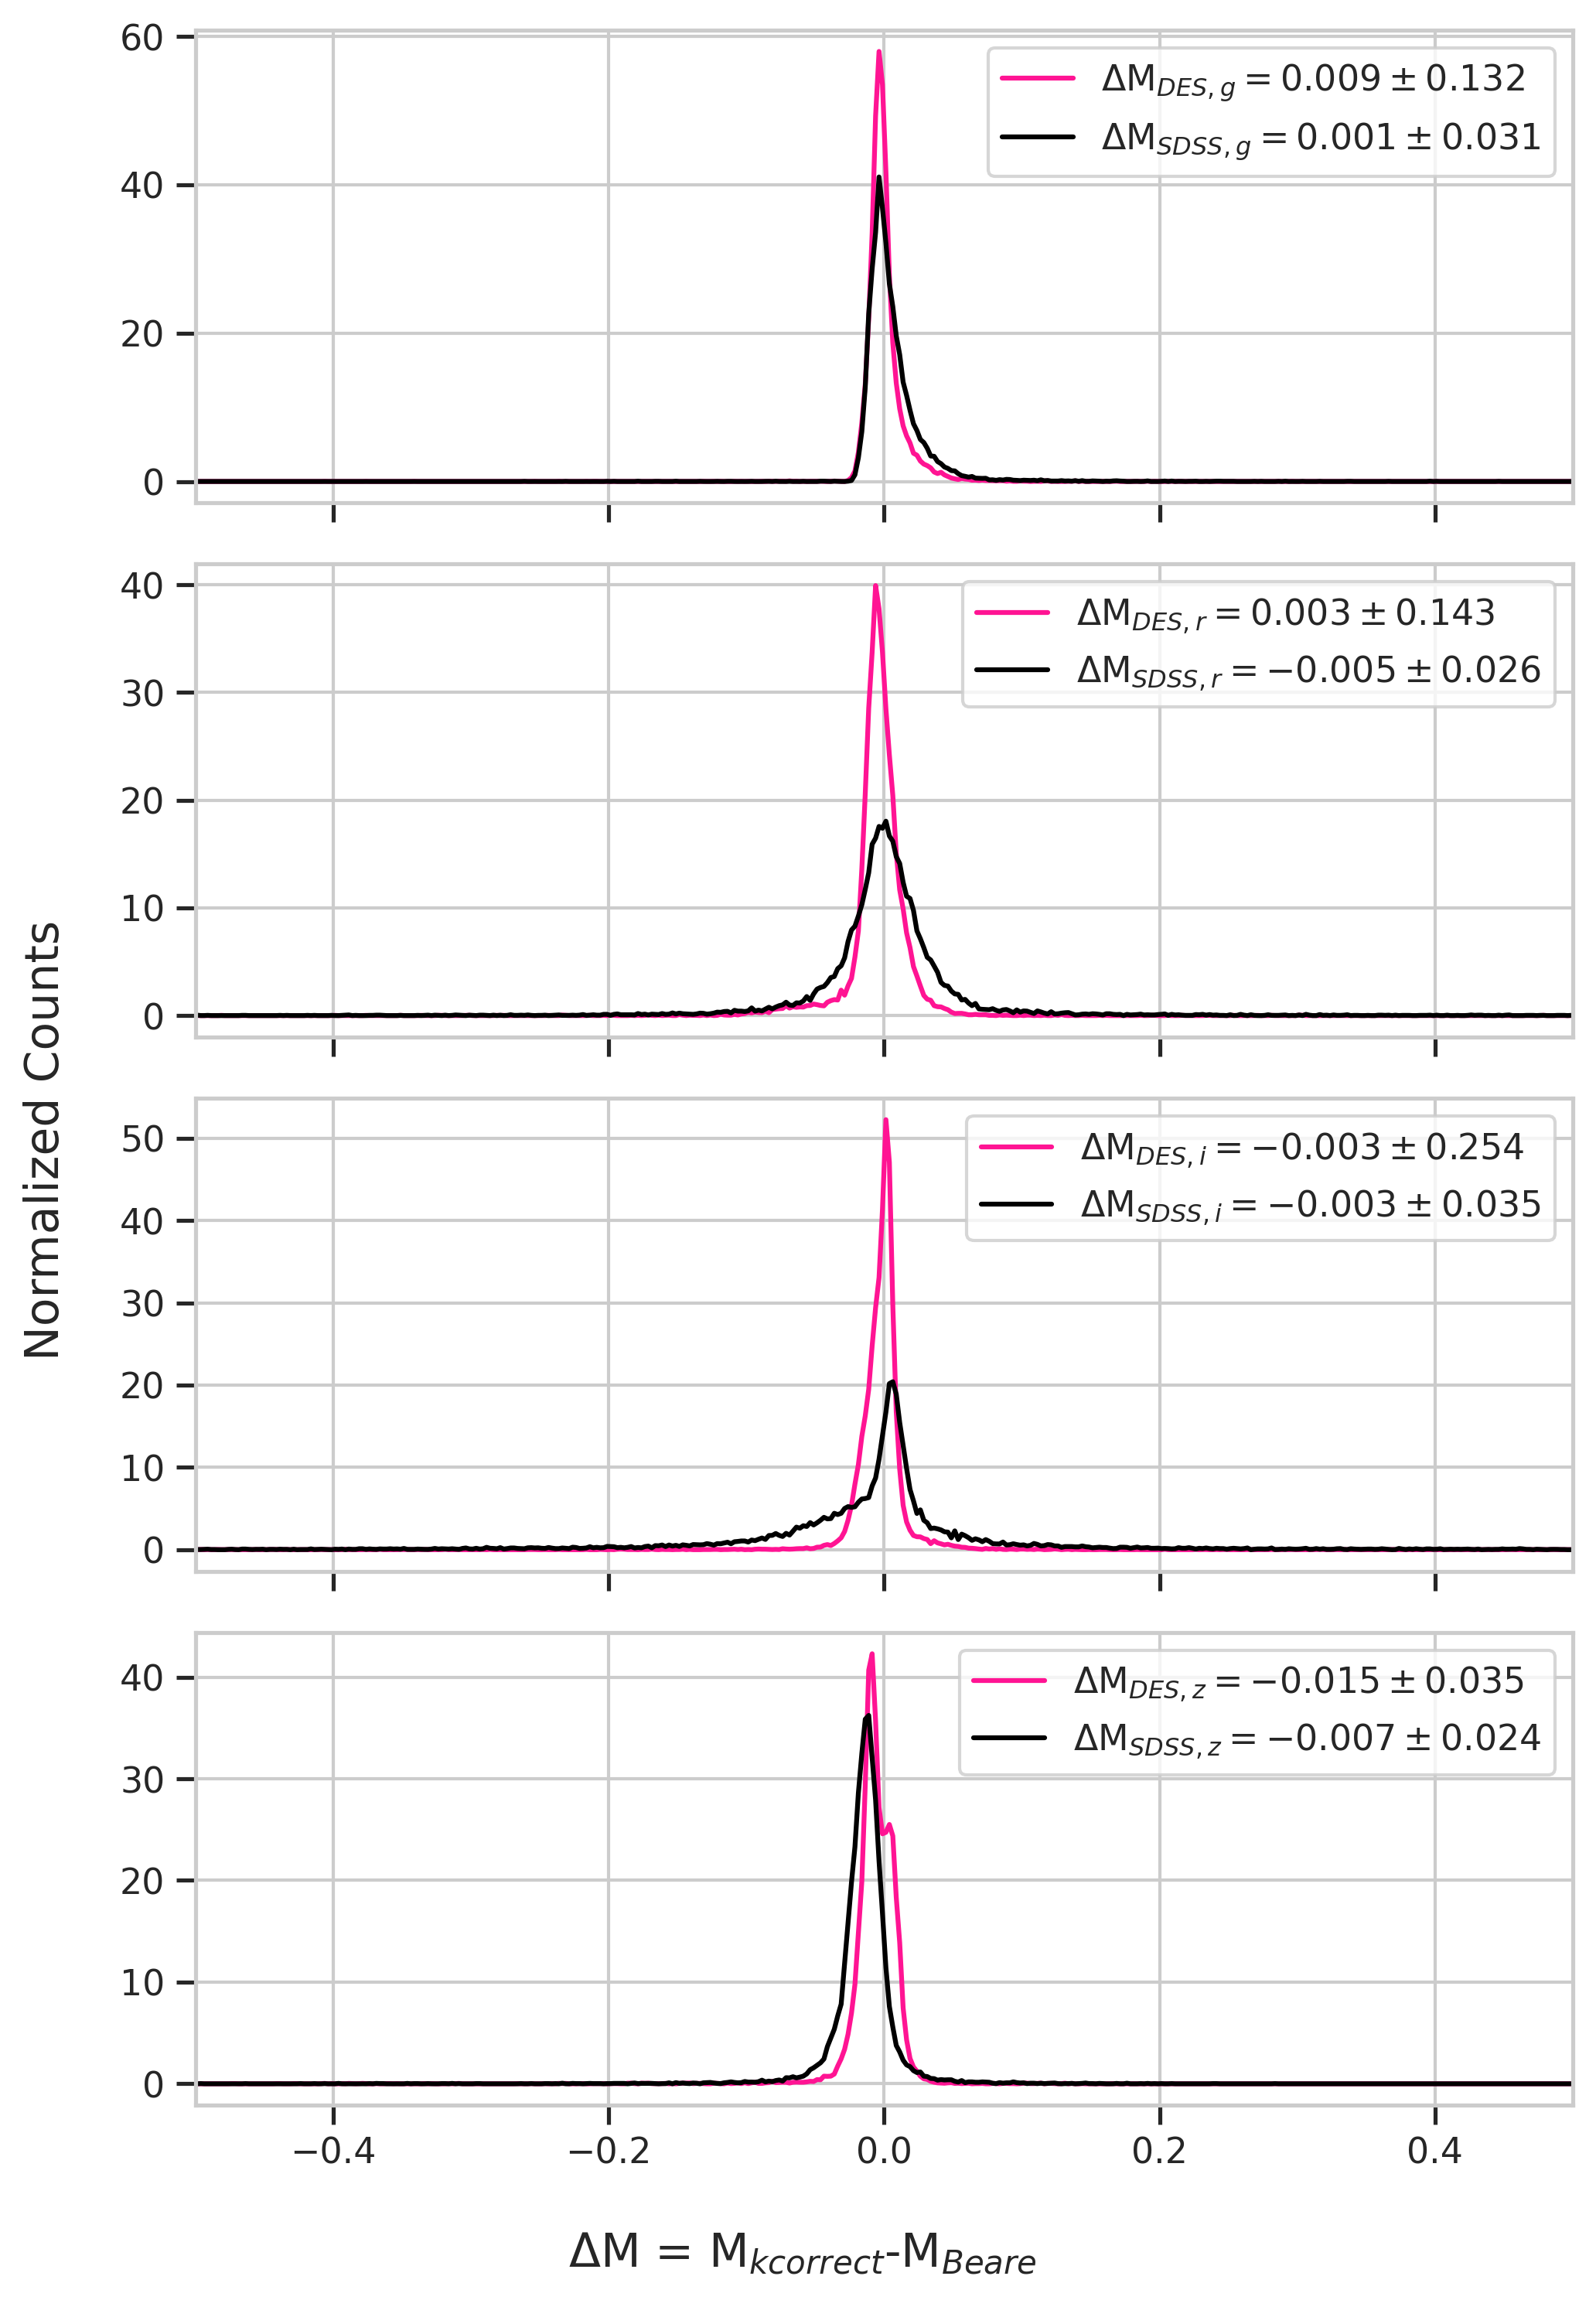

In [133]:
sel = spec_z <= 0.1

fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    sloandiff = (M_SDSS[sel,i] - susmag_SDSS[i][sel])
    desdiff = (M_DES[sel,i] - susmag_DES[i][sel])
    
    sloanmean = np.mean(sloandiff)
    sloanstd = np.std(sloandiff)
    
    desmean = np.mean(desdiff)
    desstd = np.std(desdiff)
    
    counts, edges = np.histogram(sloandiff,bins=800,density=True,range=[-1,1])
    opte = 0.5*(edges[1:]+edges[:-1])

    countsa, edgesa = np.histogram(desdiff, bins=800,density=True,range=[-1,1])
    optea = 0.5*(edgesa[1:]+edgesa[:-1])

    ax[i].plot(optea,countsa,color='deeppink',ls='-',label=f'$\Delta$M$_{{DES,{bands[i]}}} = {sloanmean:.3f}\pm{sloanstd:.3f}$')
    ax[i].plot(opte,counts,color='black',ls='-',label=f'$\Delta$M$_{{SDSS,{bands[i]}}} = {desmean:.3f}\pm{desstd:.3f}$')

    ax[i].legend(loc='upper right')
ax[0].set_xbound(-.5,.5)
fig.supxlabel('$\Delta$M = M$_{kcorrect}$-M$_{Beare}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_01.png')
plt.show()

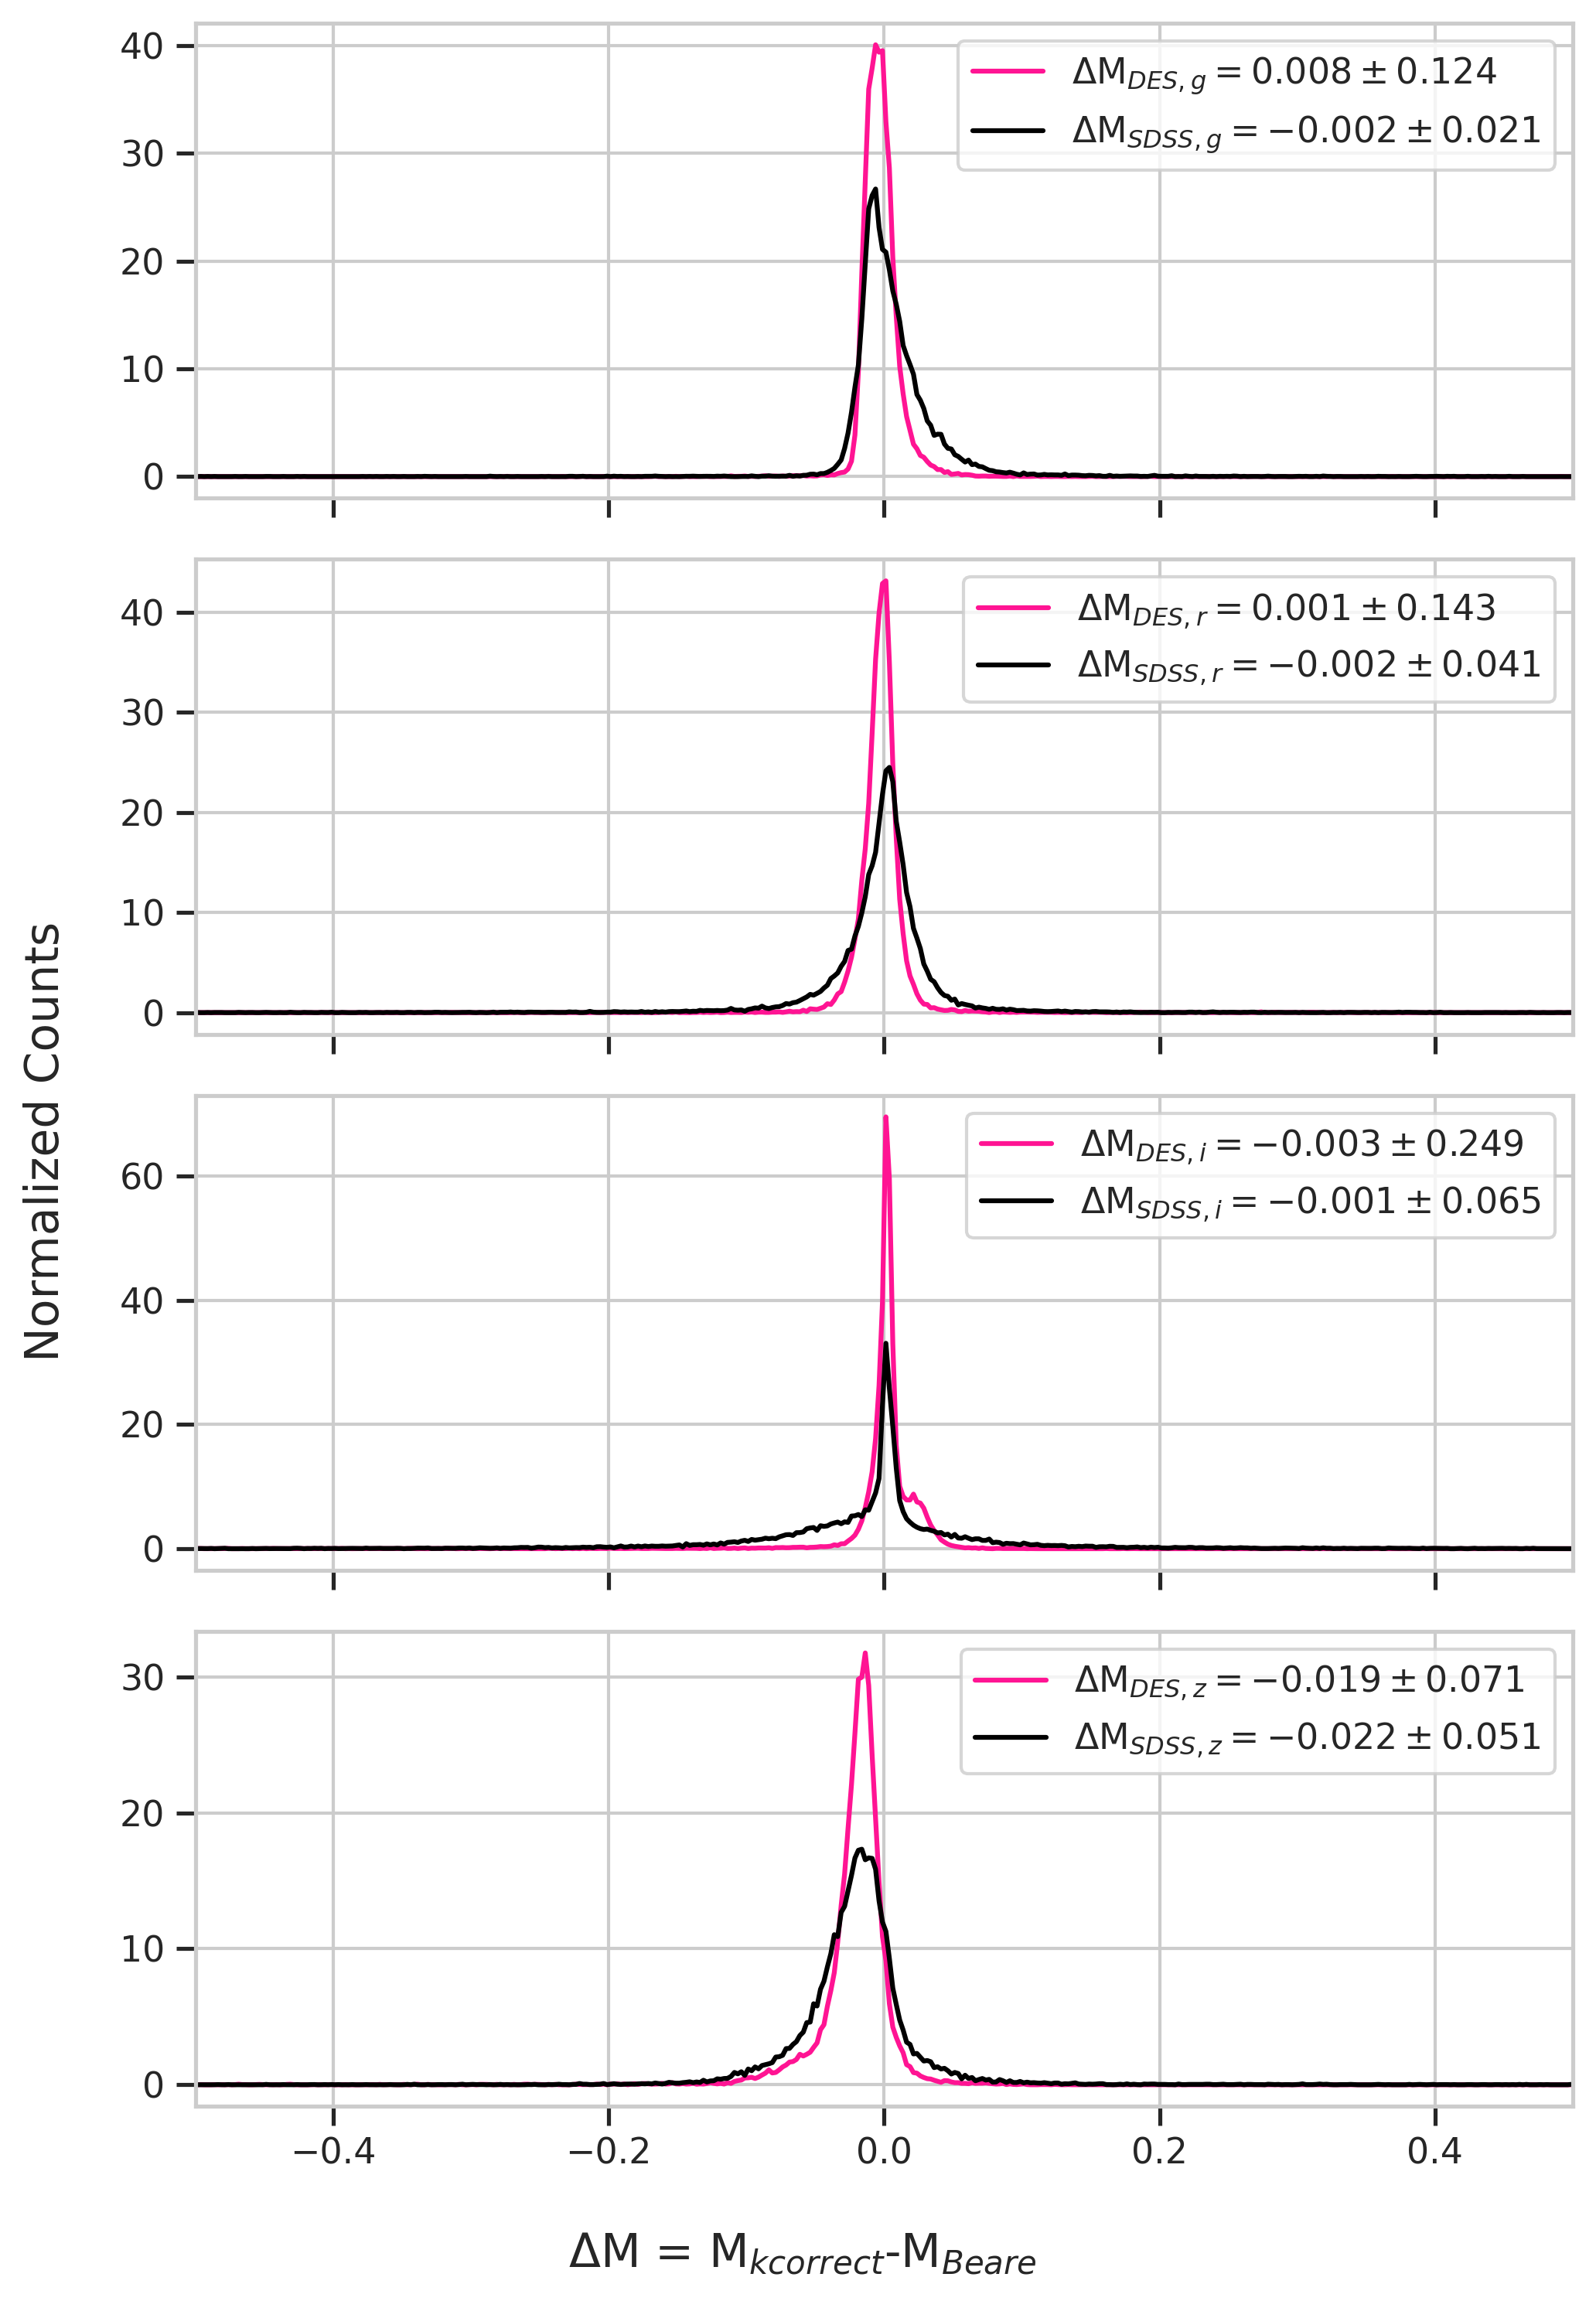

In [134]:
sel = (spec_z > 0.1) & (spec_z <= 0.2)

fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    sloandiff = (M_SDSS[sel,i] - susmag_SDSS[i][sel])
    desdiff = (M_DES[sel,i] - susmag_DES[i][sel])
    
    sloanmean = np.mean(sloandiff)
    sloanstd = np.std(sloandiff)
    
    desmean = np.mean(desdiff)
    desstd = np.std(desdiff)
    
    counts, edges = np.histogram(sloandiff,bins=800,density=True,range=[-1,1])
    opte = 0.5*(edges[1:]+edges[:-1])

    countsa, edgesa = np.histogram(desdiff, bins=800,density=True,range=[-1,1])
    optea = 0.5*(edgesa[1:]+edgesa[:-1])

    ax[i].plot(optea,countsa,color='deeppink',ls='-',label=f'$\Delta$M$_{{DES,{bands[i]}}} = {sloanmean:.3f}\pm{sloanstd:.3f}$')
    ax[i].plot(opte,counts,color='black',ls='-',label=f'$\Delta$M$_{{SDSS,{bands[i]}}} = {desmean:.3f}\pm{desstd:.3f}$')

    ax[i].legend(loc='upper right')
ax[0].set_xbound(-.5,.5)
fig.supxlabel('$\Delta$M = M$_{kcorrect}$-M$_{Beare}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_02.png')
plt.show()

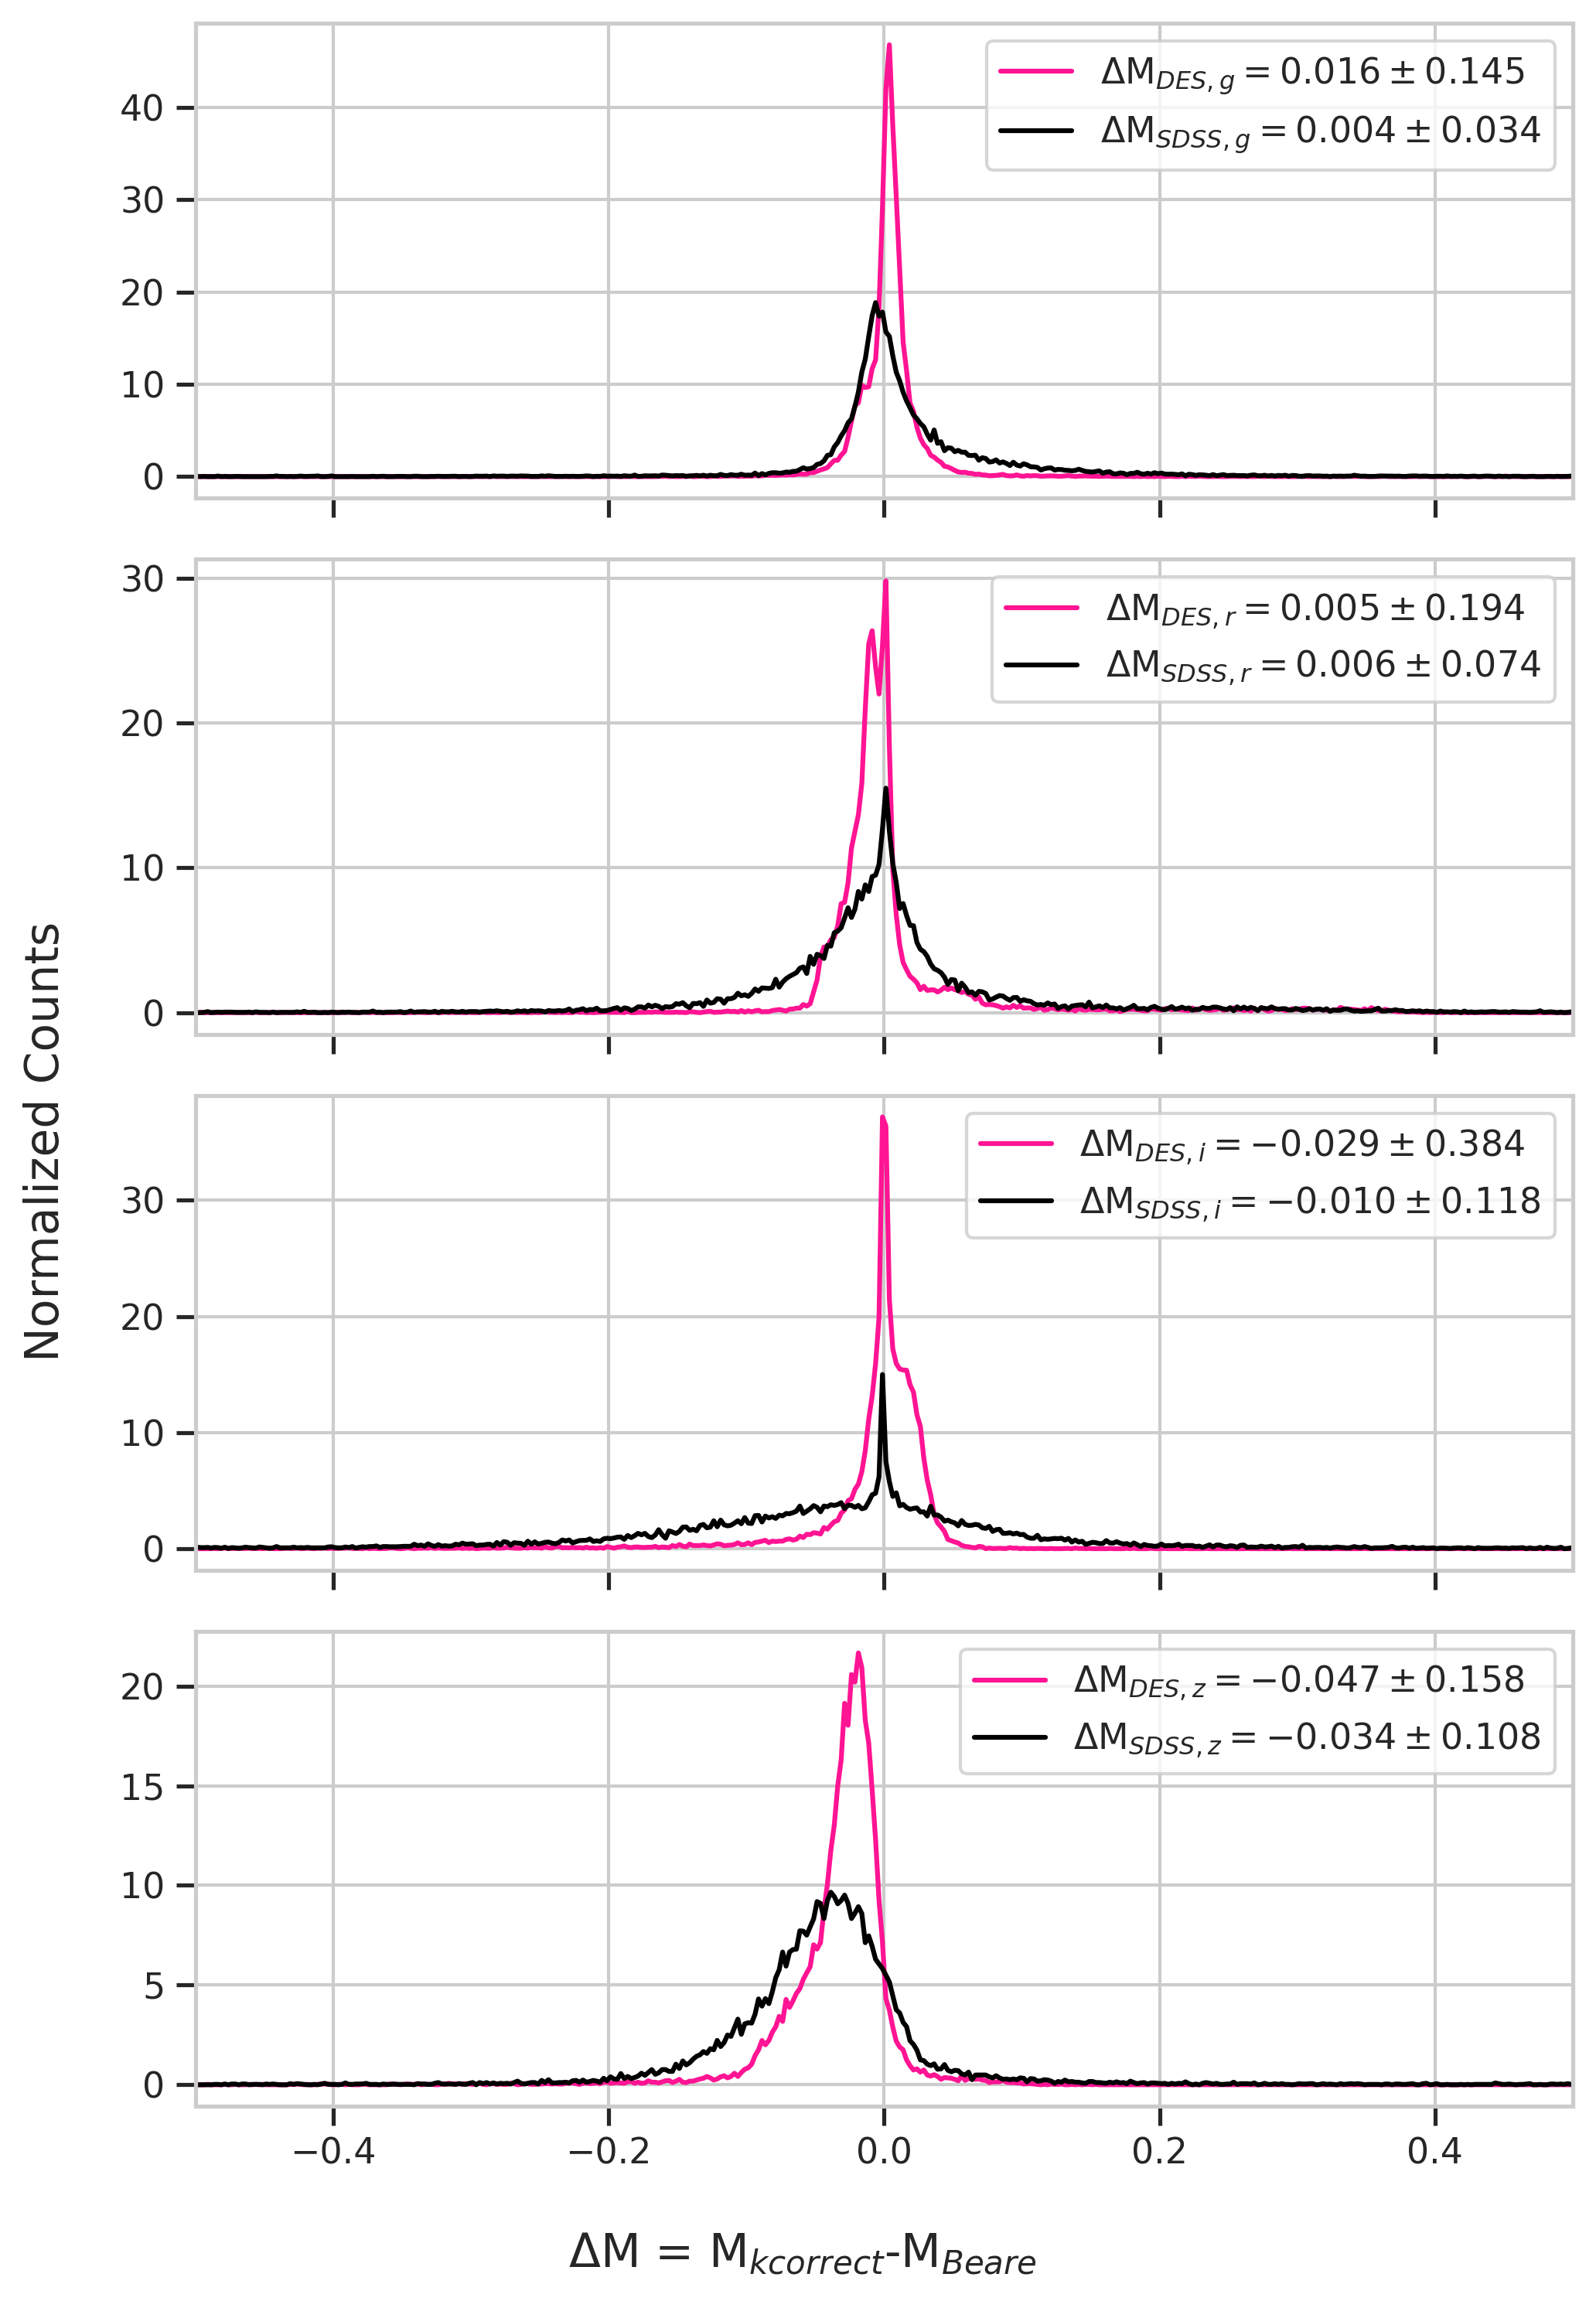

In [135]:
sel = (spec_z > 0.2) & (spec_z <= 0.3)

fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    sloandiff = (M_SDSS[sel,i] - susmag_SDSS[i][sel])
    desdiff = (M_DES[sel,i] - susmag_DES[i][sel])
    
    sloanmean = np.mean(sloandiff)
    sloanstd = np.std(sloandiff)
    
    desmean = np.mean(desdiff)
    desstd = np.std(desdiff)
    
    counts, edges = np.histogram(sloandiff,bins=800,density=True,range=[-1,1])
    opte = 0.5*(edges[1:]+edges[:-1])

    countsa, edgesa = np.histogram(desdiff, bins=800,density=True,range=[-1,1])
    optea = 0.5*(edgesa[1:]+edgesa[:-1])

    ax[i].plot(optea,countsa,color='deeppink',ls='-',label=f'$\Delta$M$_{{DES,{bands[i]}}} = {sloanmean:.3f}\pm{sloanstd:.3f}$')
    ax[i].plot(opte,counts,color='black',ls='-',label=f'$\Delta$M$_{{SDSS,{bands[i]}}} = {desmean:.3f}\pm{desstd:.3f}$')

    ax[i].legend(loc='upper right')
ax[0].set_xbound(-.5,.5)
fig.supxlabel('$\Delta$M = M$_{kcorrect}$-M$_{Beare}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_03.png')
plt.show()

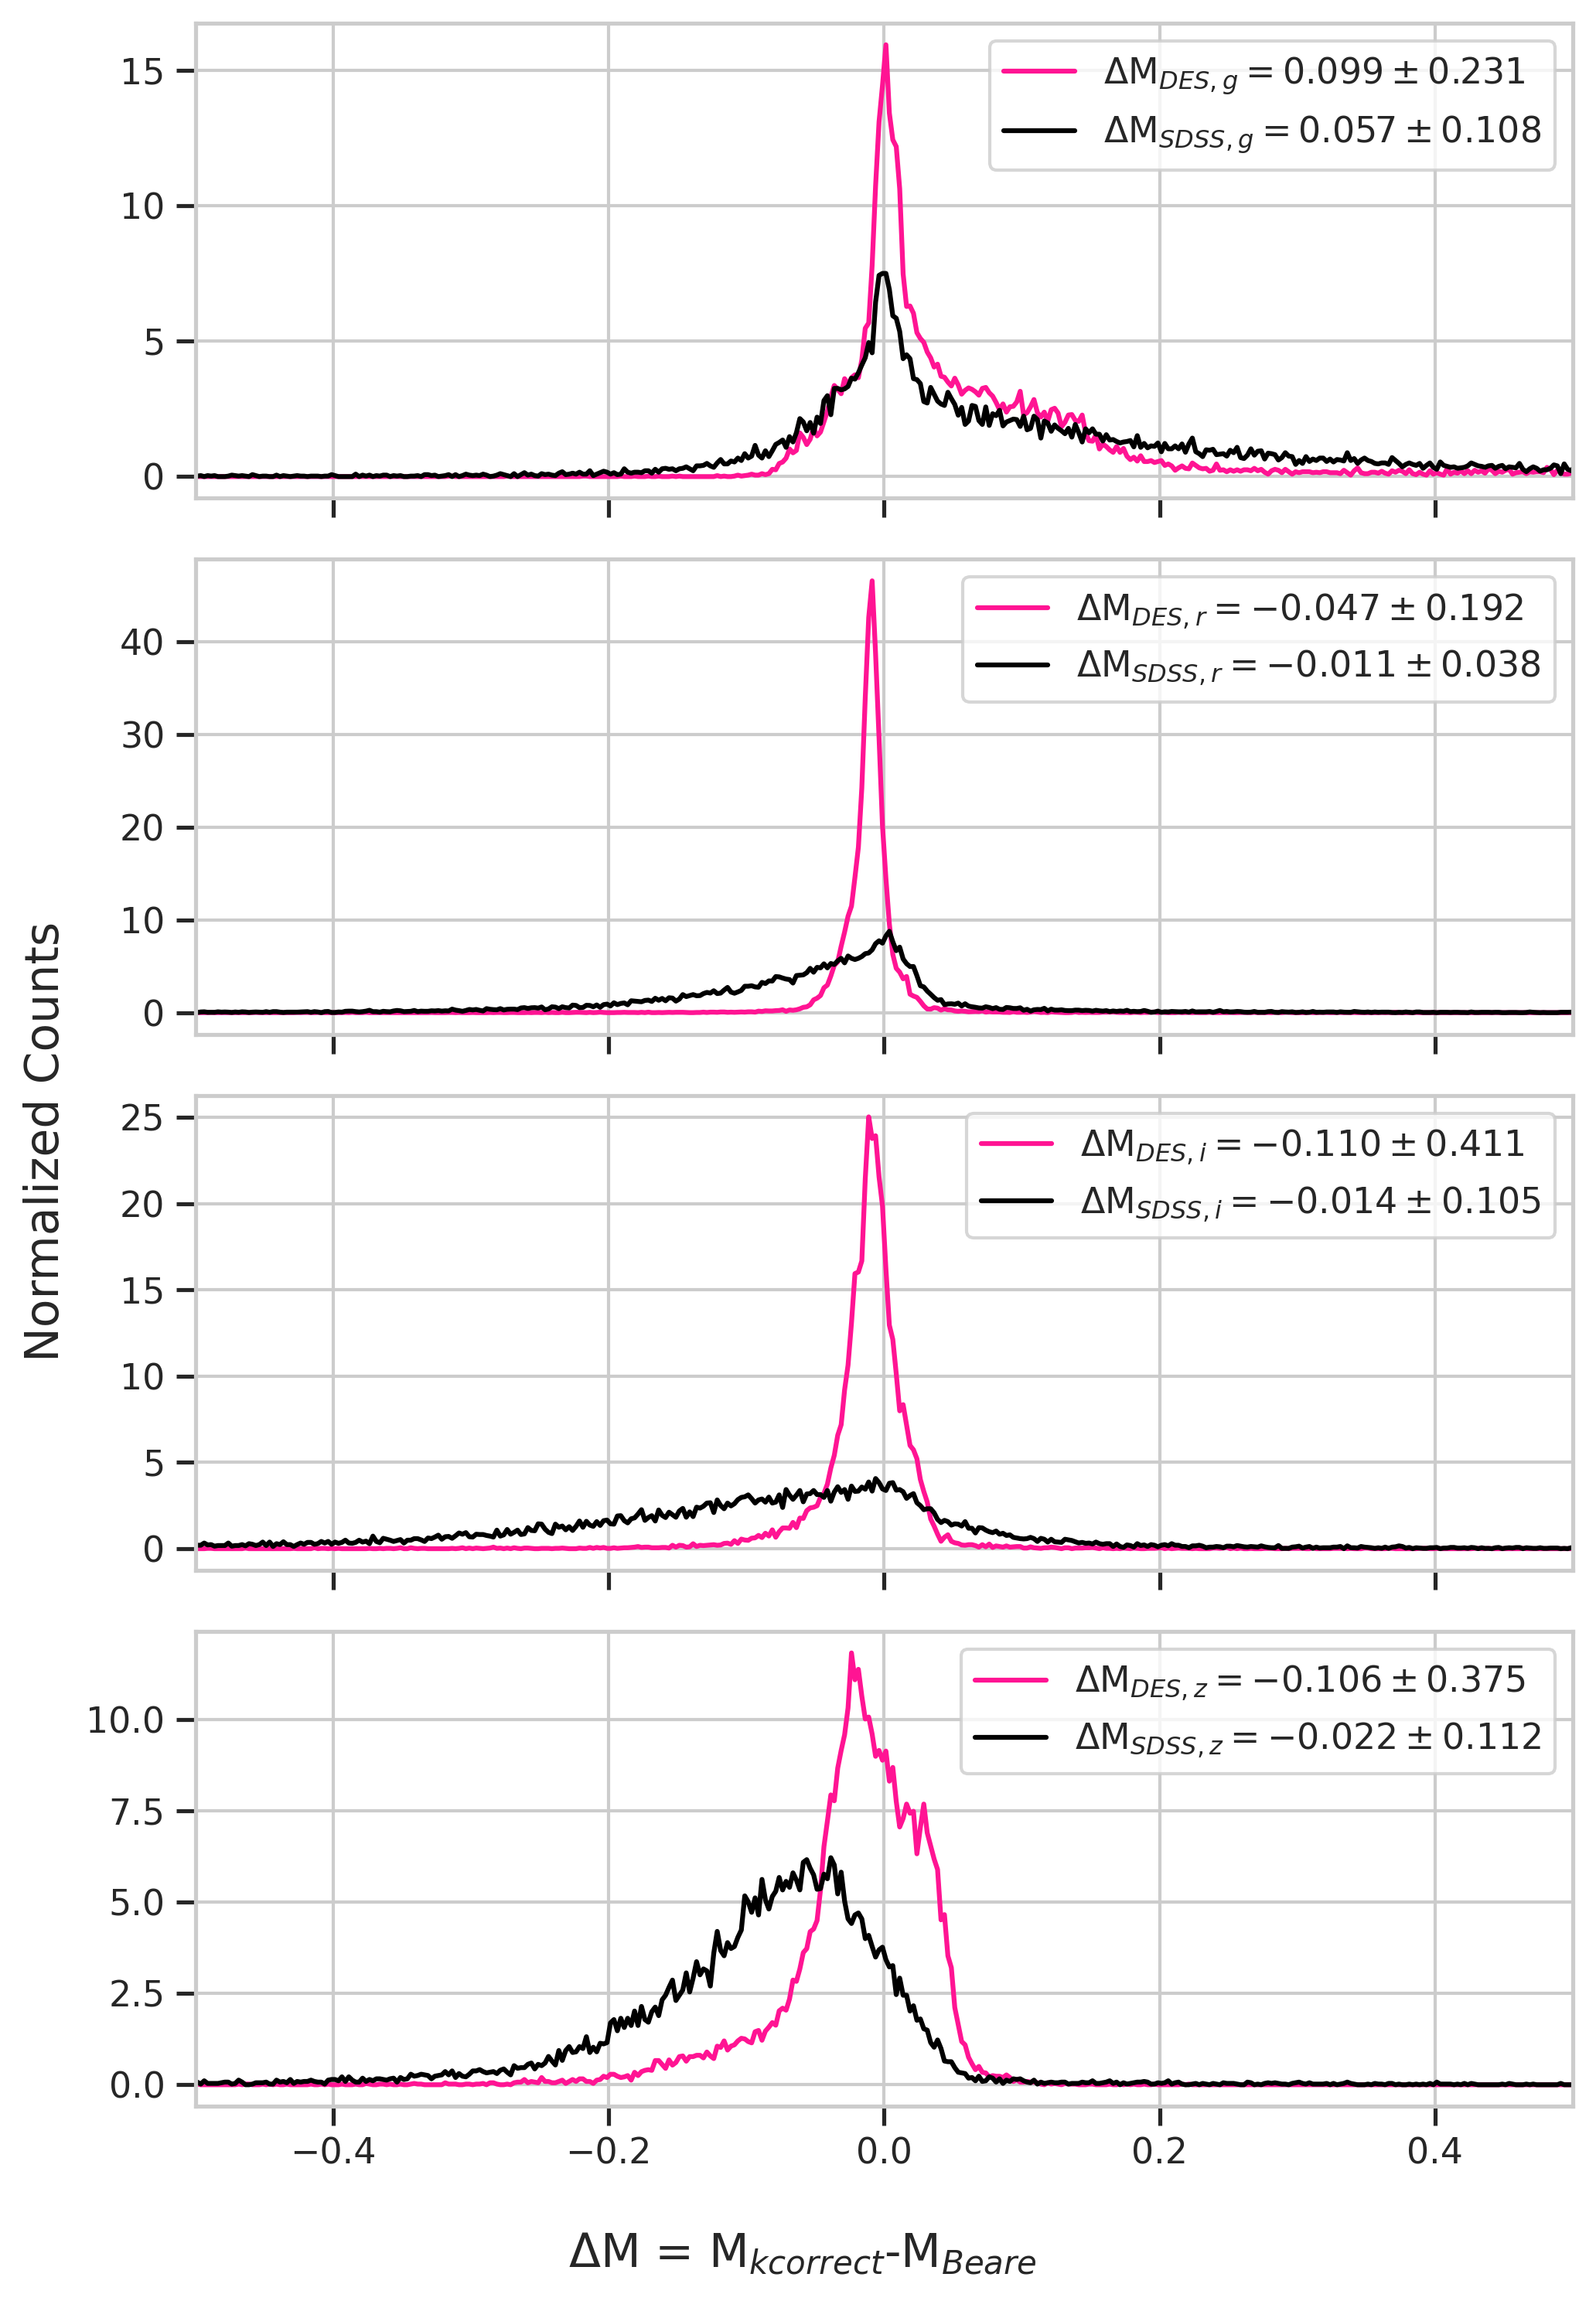

In [136]:
sel = (spec_z > 0.3) & (spec_z <= 0.4)

fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    sloandiff = (M_SDSS[sel,i] - susmag_SDSS[i][sel])
    desdiff = (M_DES[sel,i] - susmag_DES[i][sel])
    
    sloanmean = np.mean(sloandiff)
    sloanstd = np.std(sloandiff)
    
    desmean = np.mean(desdiff)
    desstd = np.std(desdiff)
    
    counts, edges = np.histogram(sloandiff,bins=800,density=True,range=[-1,1])
    opte = 0.5*(edges[1:]+edges[:-1])

    countsa, edgesa = np.histogram(desdiff, bins=800,density=True,range=[-1,1])
    optea = 0.5*(edgesa[1:]+edgesa[:-1])

    ax[i].plot(optea,countsa,color='deeppink',ls='-',label=f'$\Delta$M$_{{DES,{bands[i]}}} = {sloanmean:.3f}\pm{sloanstd:.3f}$')
    ax[i].plot(opte,counts,color='black',ls='-',label=f'$\Delta$M$_{{SDSS,{bands[i]}}} = {desmean:.3f}\pm{desstd:.3f}$')

    ax[i].legend(loc='upper right')
ax[0].set_xbound(-.5,.5)
fig.supxlabel('$\Delta$M = M$_{kcorrect}$-M$_{Beare}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_04.png')
plt.show()

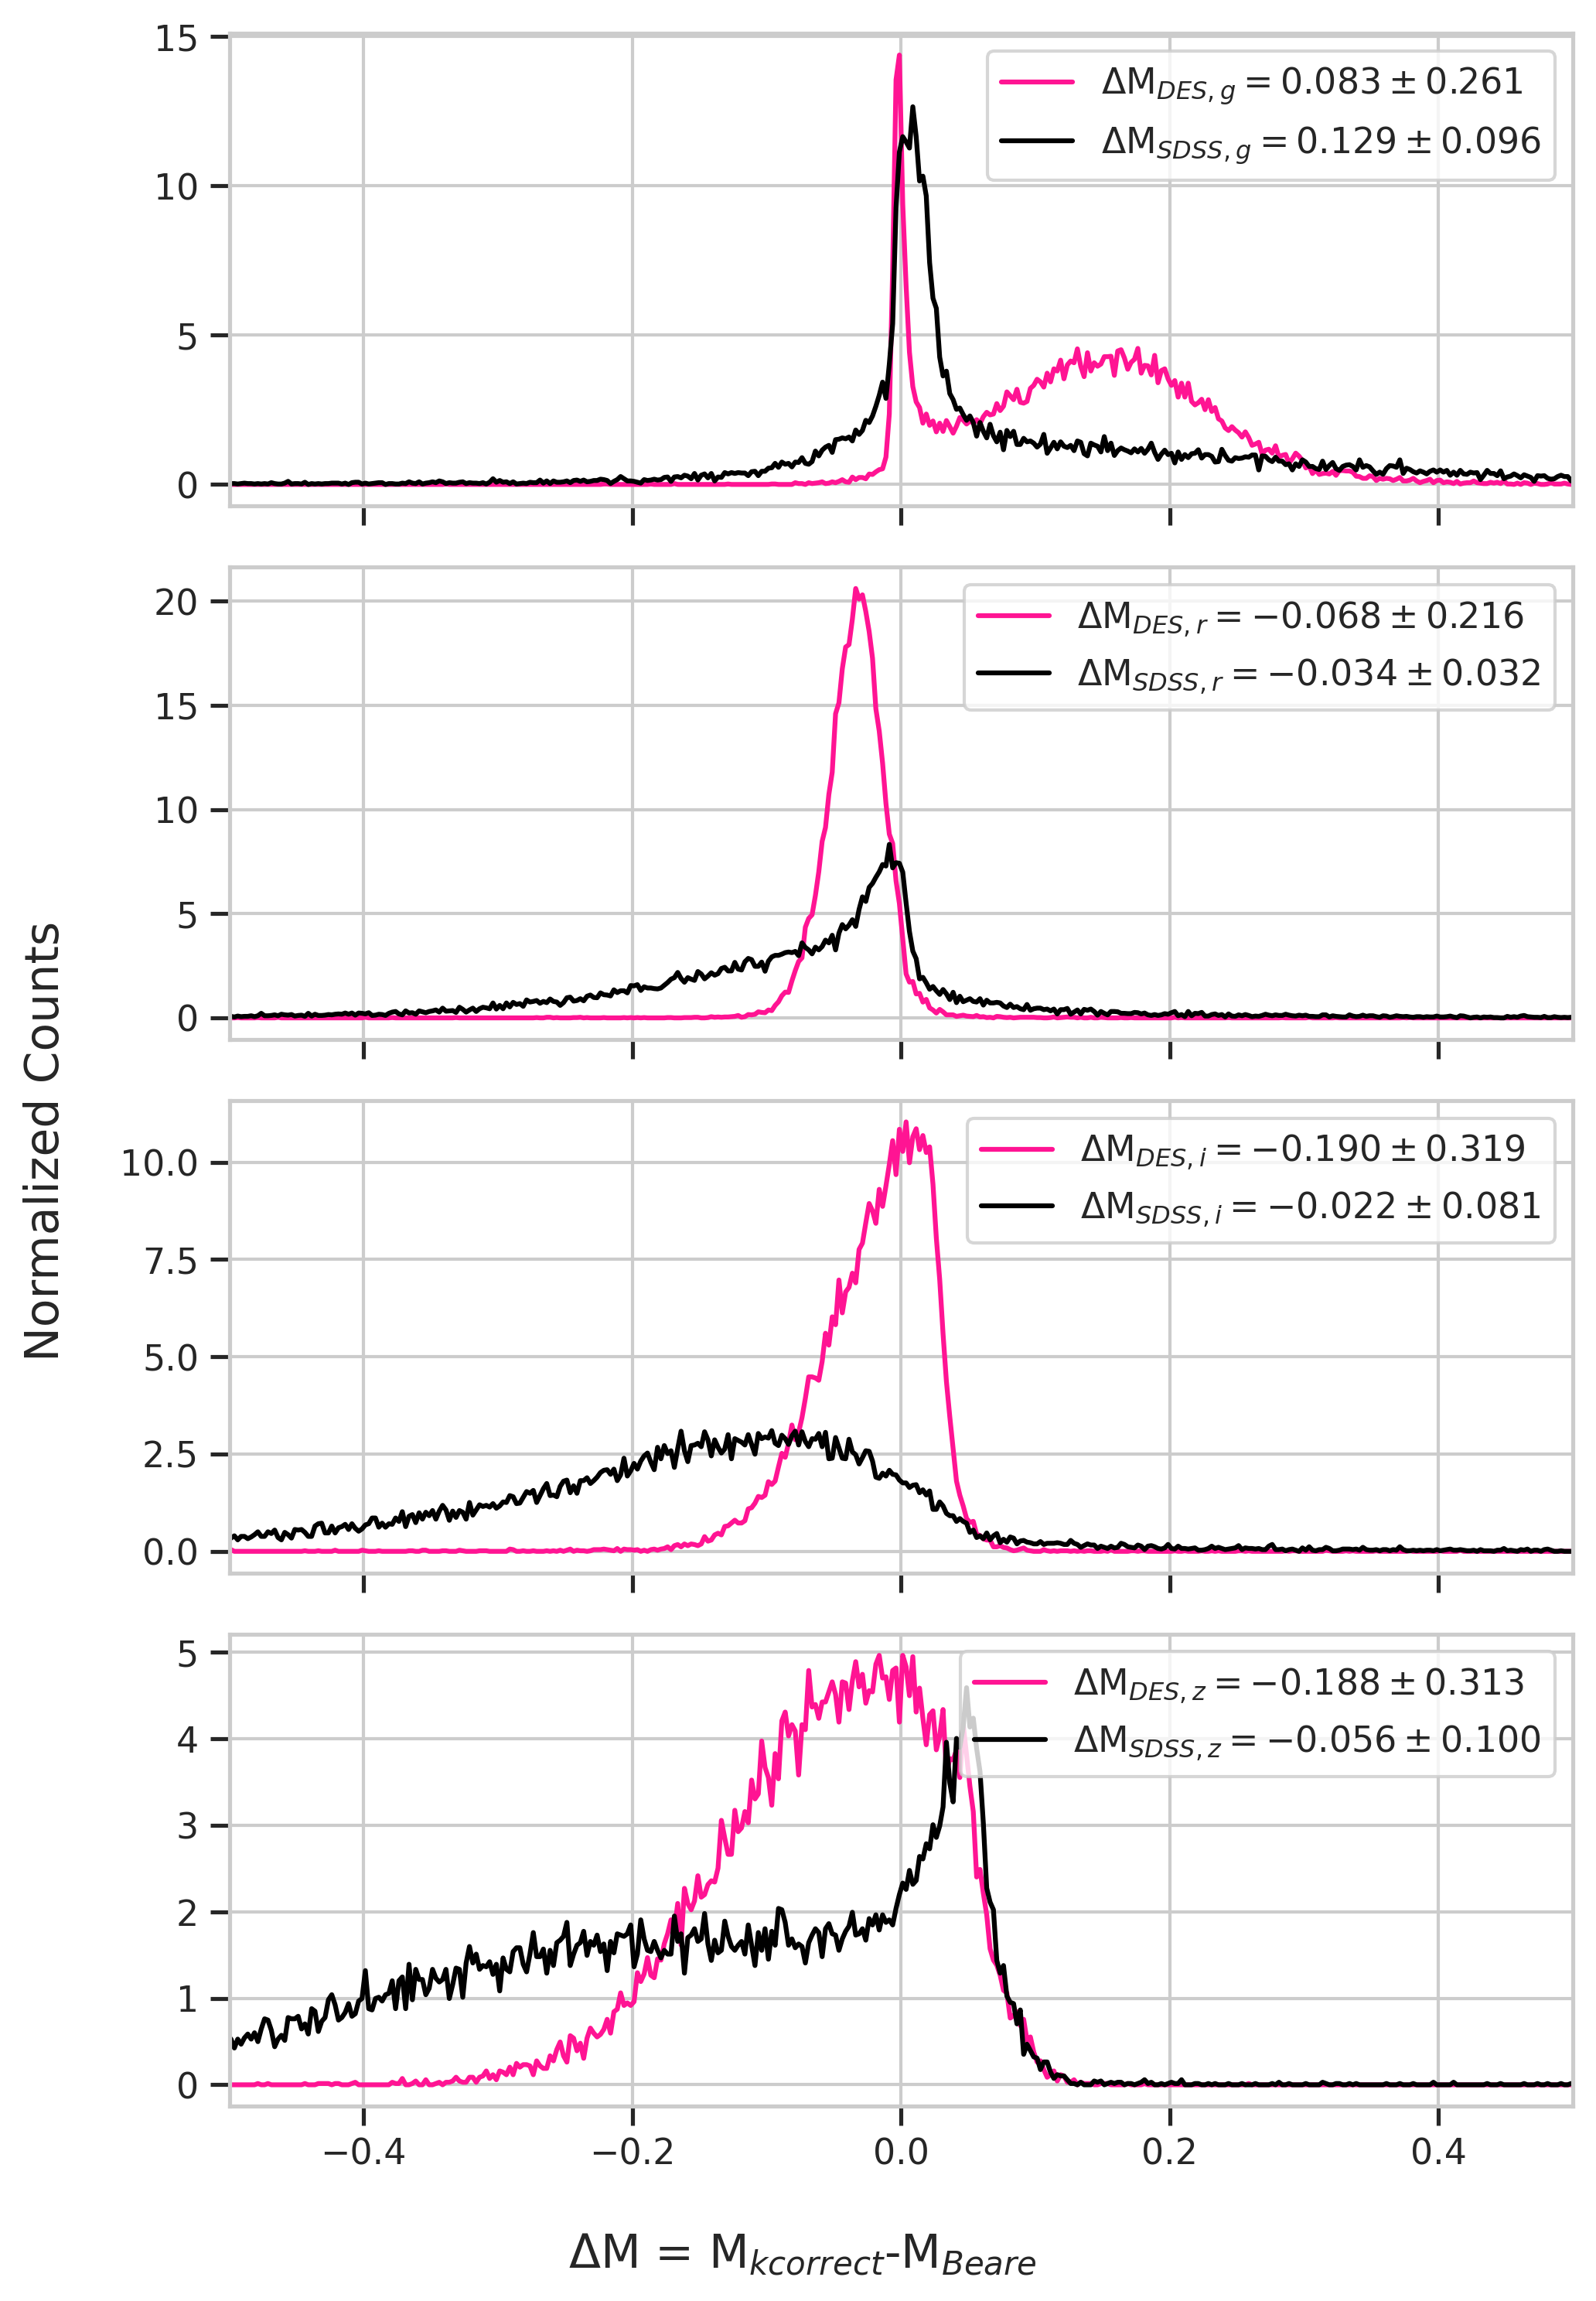

In [140]:
sel = (spec_z > 0.4) & (spec_z <= 0.5)

fig, ax = plt.subplots(figsize=(7, 10),nrows=4,sharex=True,dpi=300)
bands = ['g','r','i','z']
for i in range(4):
    sloandiff = (M_SDSS[sel,i] - susmag_SDSS[i][sel])
    desdiff = (M_DES[sel,i] - susmag_DES[i][sel])
    
    sloanmean = np.mean(sloandiff)
    sloanstd = np.std(sloandiff)
    
    desmean = np.mean(desdiff)
    desstd = np.std(desdiff)
    
    counts, edges = np.histogram(sloandiff,bins=800,density=True,range=[-1,1])
    opte = 0.5*(edges[1:]+edges[:-1])

    countsa, edgesa = np.histogram(desdiff, bins=800,density=True,range=[-1,1])
    optea = 0.5*(edgesa[1:]+edgesa[:-1])

    ax[i].plot(optea,countsa,color='deeppink',ls='-',label=f'$\Delta$M$_{{DES,{bands[i]}}} = {sloanmean:.3f}\pm{sloanstd:.3f}$')
    ax[i].plot(opte,counts,color='black',ls='-',label=f'$\Delta$M$_{{SDSS,{bands[i]}}} = {desmean:.3f}\pm{desstd:.3f}$')

    ax[i].legend(loc='upper right')
ax[0].set_xbound(-.5,.5)
fig.supxlabel('$\Delta$M = M$_{kcorrect}$-M$_{Beare}$')
fig.supylabel('Normalized Counts')
fig.tight_layout()
fig.savefig('deltaM_05.png')
plt.show()

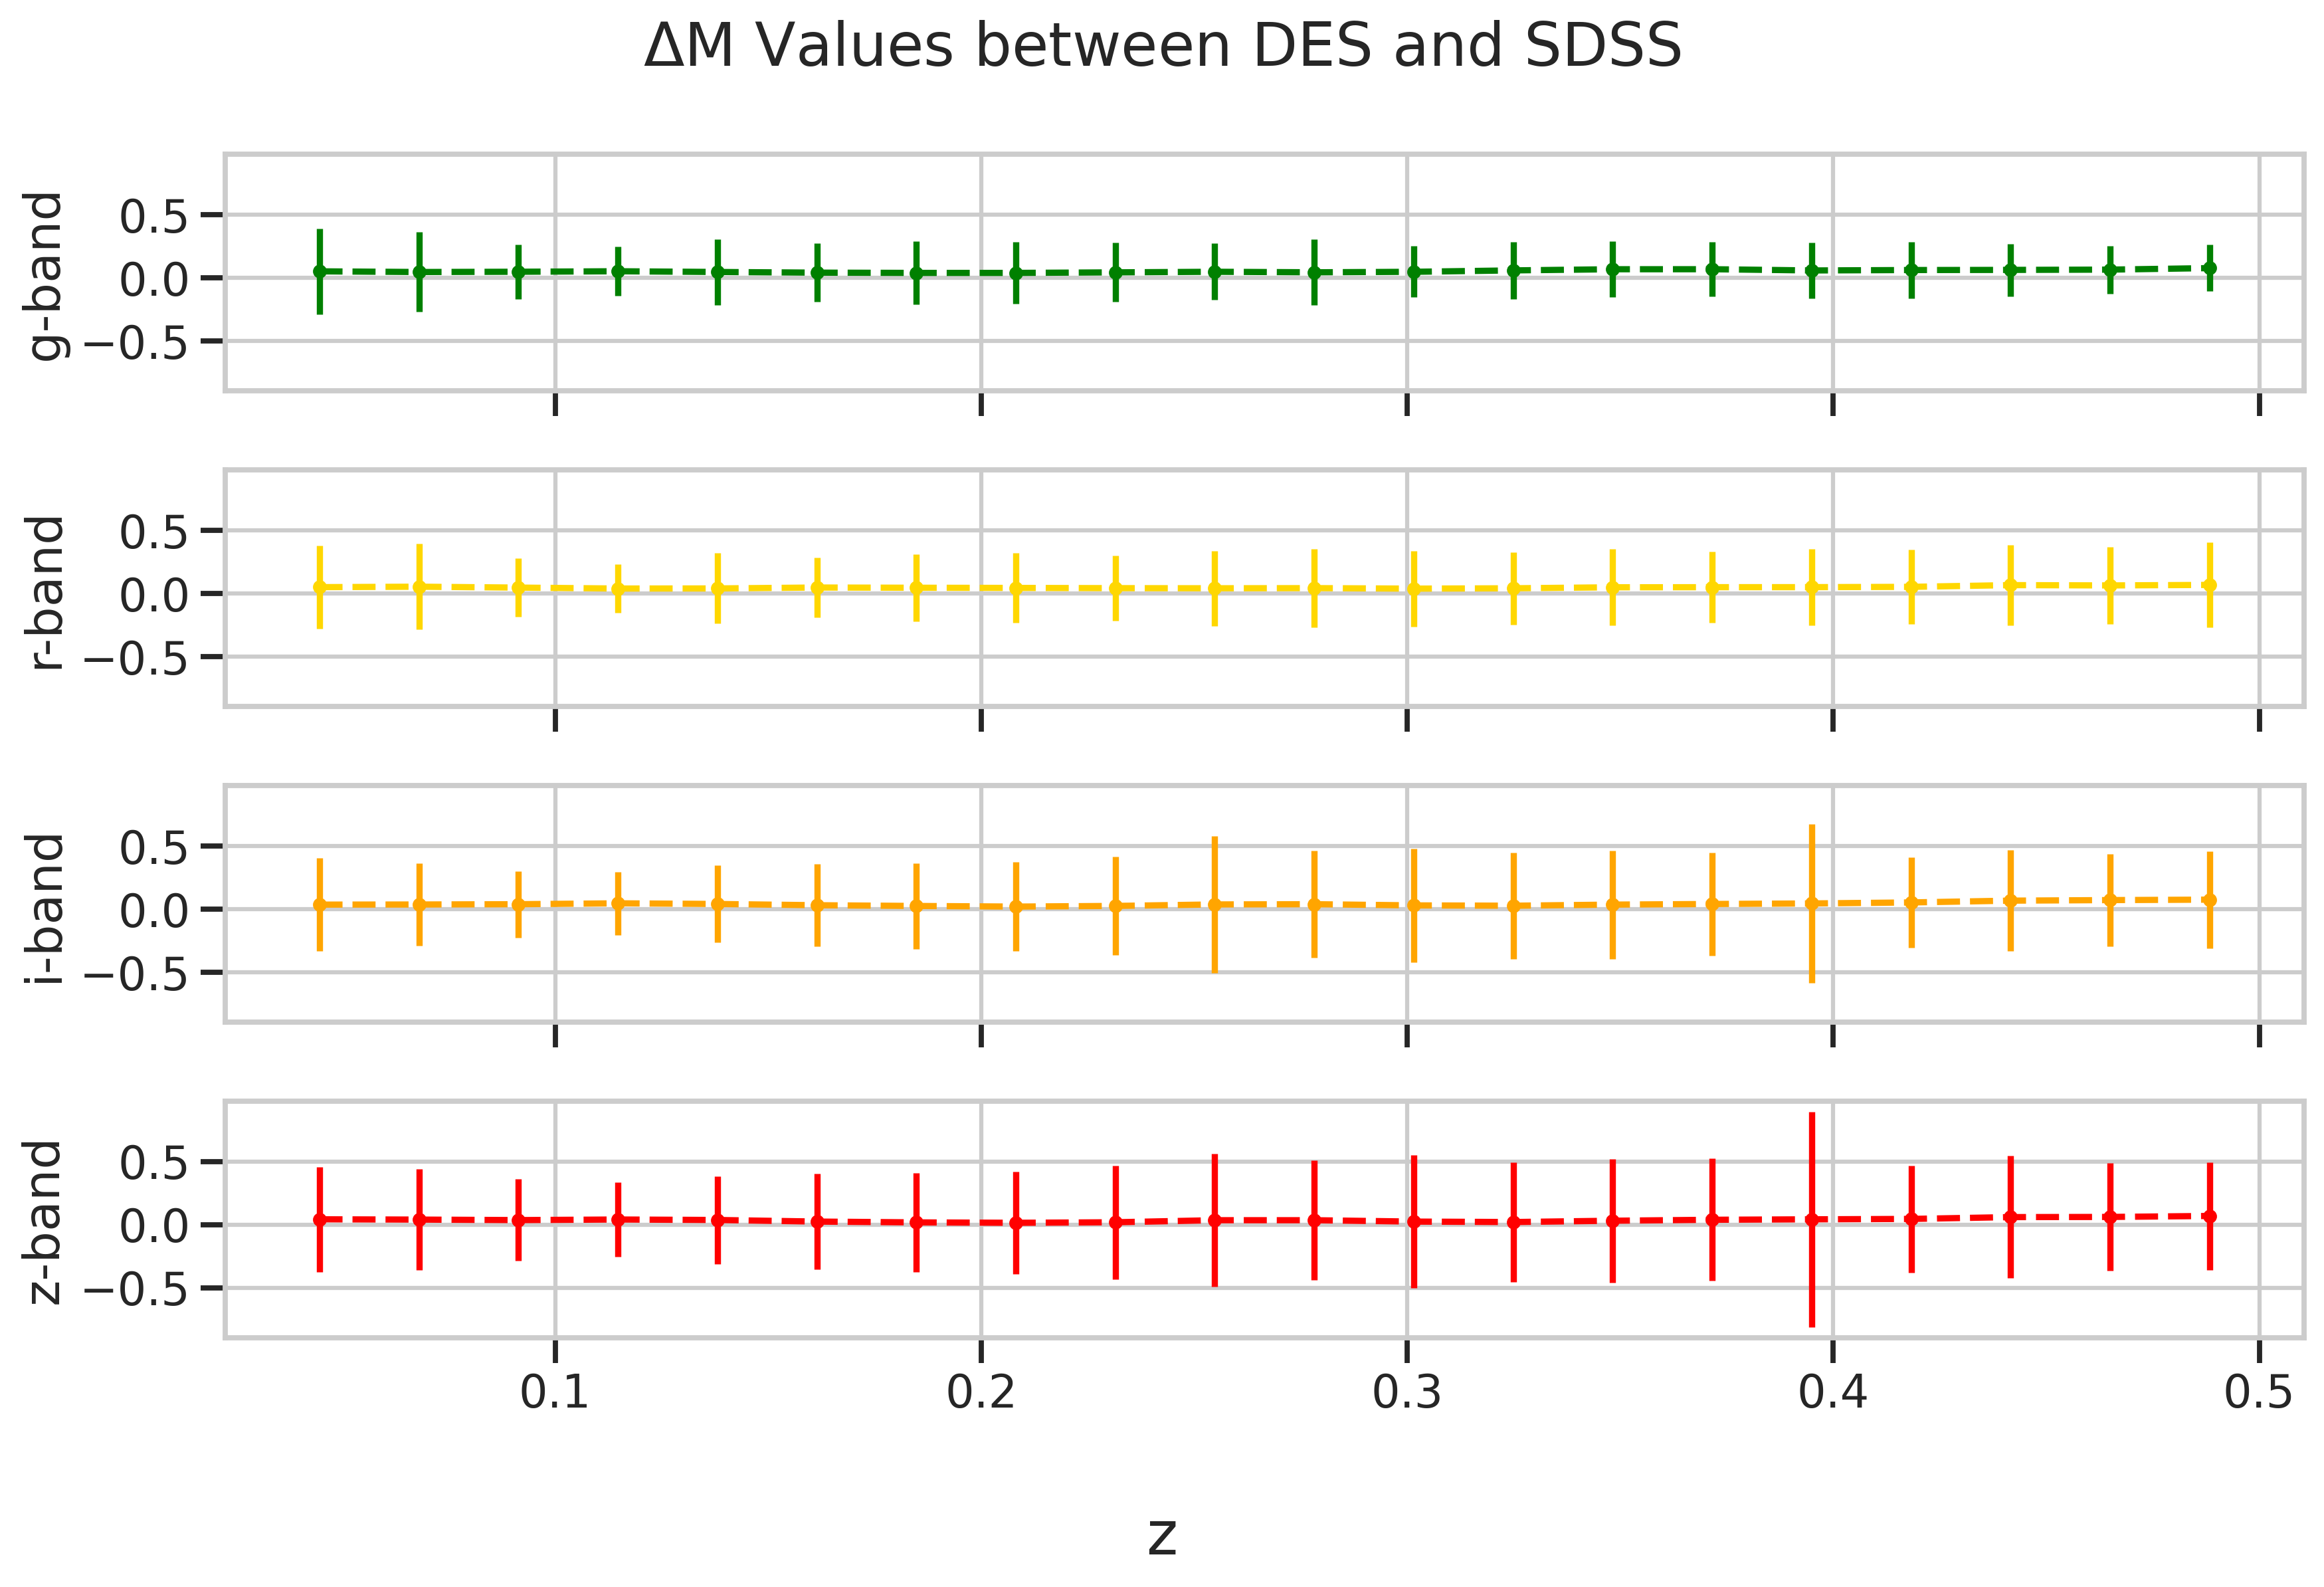

In [36]:
gedges = np.linspace(0.033,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,8),dpi=300,nrows=4,sharey=True,sharex=True)
longmed = []
longstd = []
names = ['g','r','i','z']
colors = ['green','gold','orange','red']
for j in range(4):
    med=[]
    std=[]
    for i in range(20):
        ranger = (spec_z > gedges[i]) & (spec_z <= gedges[i+1])
        med.append(np.median(susmag_SDES[j][ranger]-susmag_SDSS[j][ranger]))
        std.append(np.std(susmag_SDES[j][ranger]-susmag_SDSS[j][ranger]))
    longmed.append(med)
    longstd.append(std)

    ax[j].errorbar(hedges,med,yerr=std,c=colors[j],marker='o',markersize=4,label=f'{names[j]}-band',ls='--')
    ax[j].set_ylabel(f'{names[j]}-band')

fig.supxlabel('z')
fig.suptitle('$\Delta$M Values between DES and SDSS')
fig.tight_layout()
plt.show()

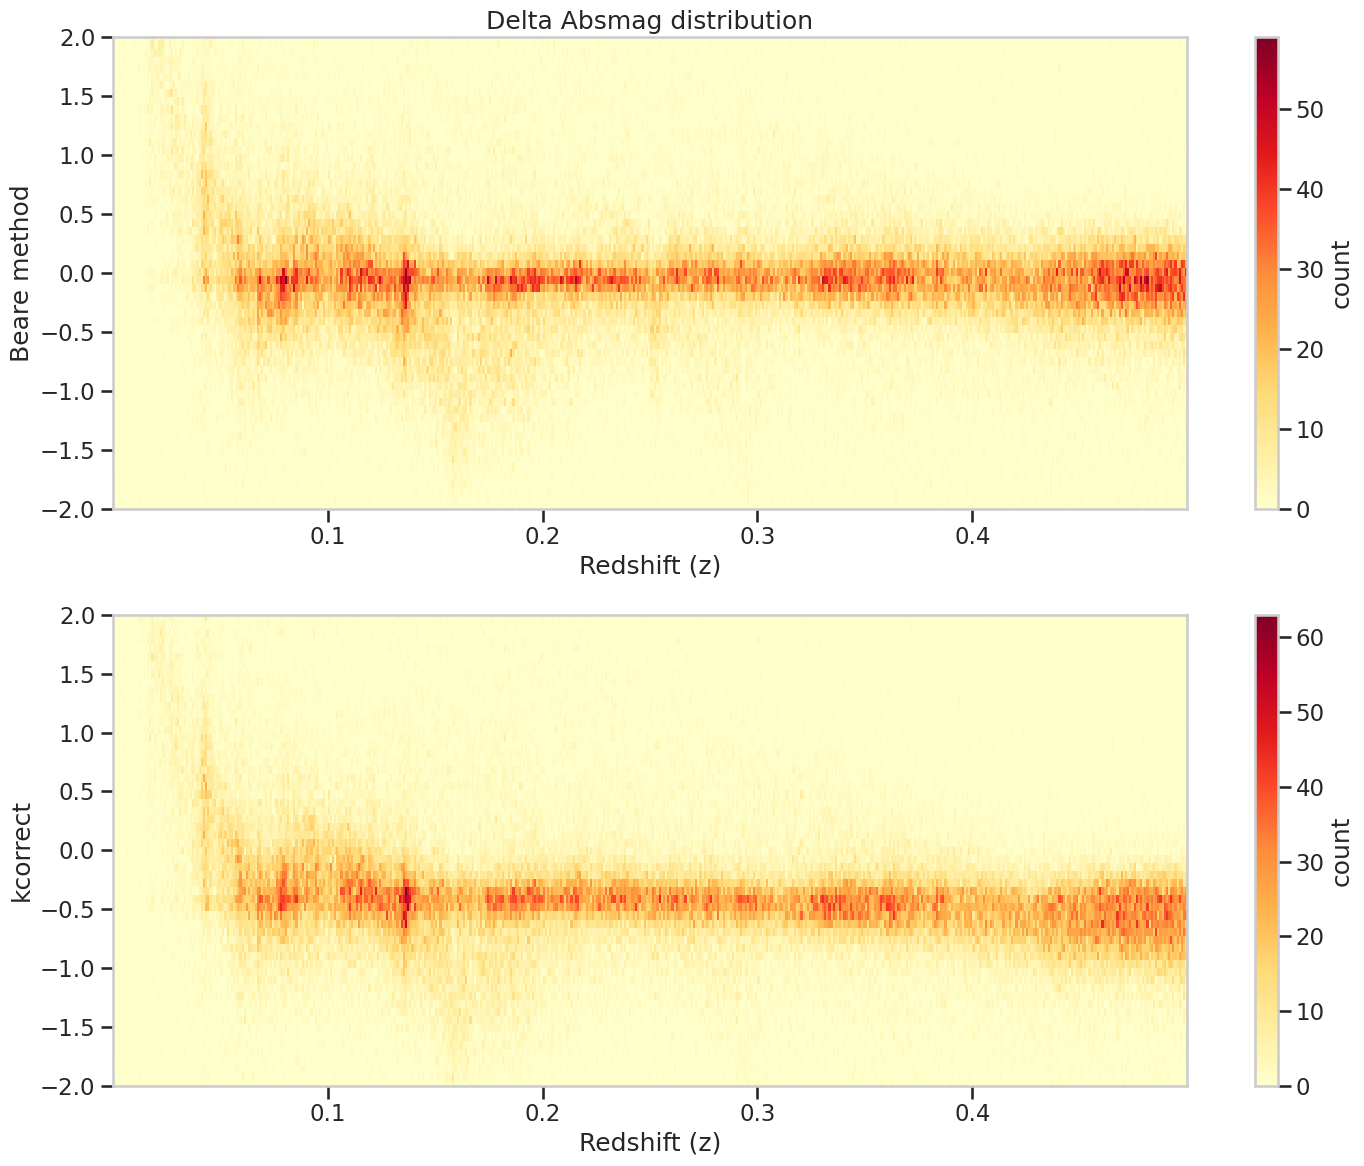

In [37]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(15,12))

ax_1= ax[0].hist2d(spec_z, susmag_SDSS[1]-susmag_DES[1],bins=(500,500),cmap='YlOrRd')
ax_2= ax[1].hist2d(spec_z, M_SDSS[:,2]-M_DES[:,1],bins=(500,500),cmap='YlOrRd')

for i in range(2):
    ax[i].set_xlabel('Redshift (z)')
    ax[i].set_ybound(-2,2)
    
ax[0].set_ylabel('Beare method')
ax[1].set_ylabel('kcorrect')

fig.colorbar(ax_1[3],ax=ax[0],label='count')
fig.colorbar(ax_2[3],ax=ax[1],label='count')
ax[0].set_title('Delta Absmag distribution')

fig.tight_layout()
plt.show()

In [38]:
x = spec_z - phot_z
y = susmag_SDSS[1] - susmag_DES[1]
# 1. Create a grid
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# 2. Evaluate KDE on grid
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# 3. Convert density values to probability levels
# Flatten and sort PDF values
pdf_values = Z.flatten()
idx = np.argsort(pdf_values)
pdf_sorted = pdf_values[idx]

# Compute cumulative probability
cumsum = np.cumsum(pdf_sorted)
cumsum /= cumsum[-1]  # normalize to [0,1]

# Map back cumulative probs to density thresholds
levels = []
for alpha in [0.5, 0.9]:  # 50% and 90%
    cutoff_index = np.searchsorted(cumsum, alpha)
    levels.append(pdf_sorted[cutoff_index])

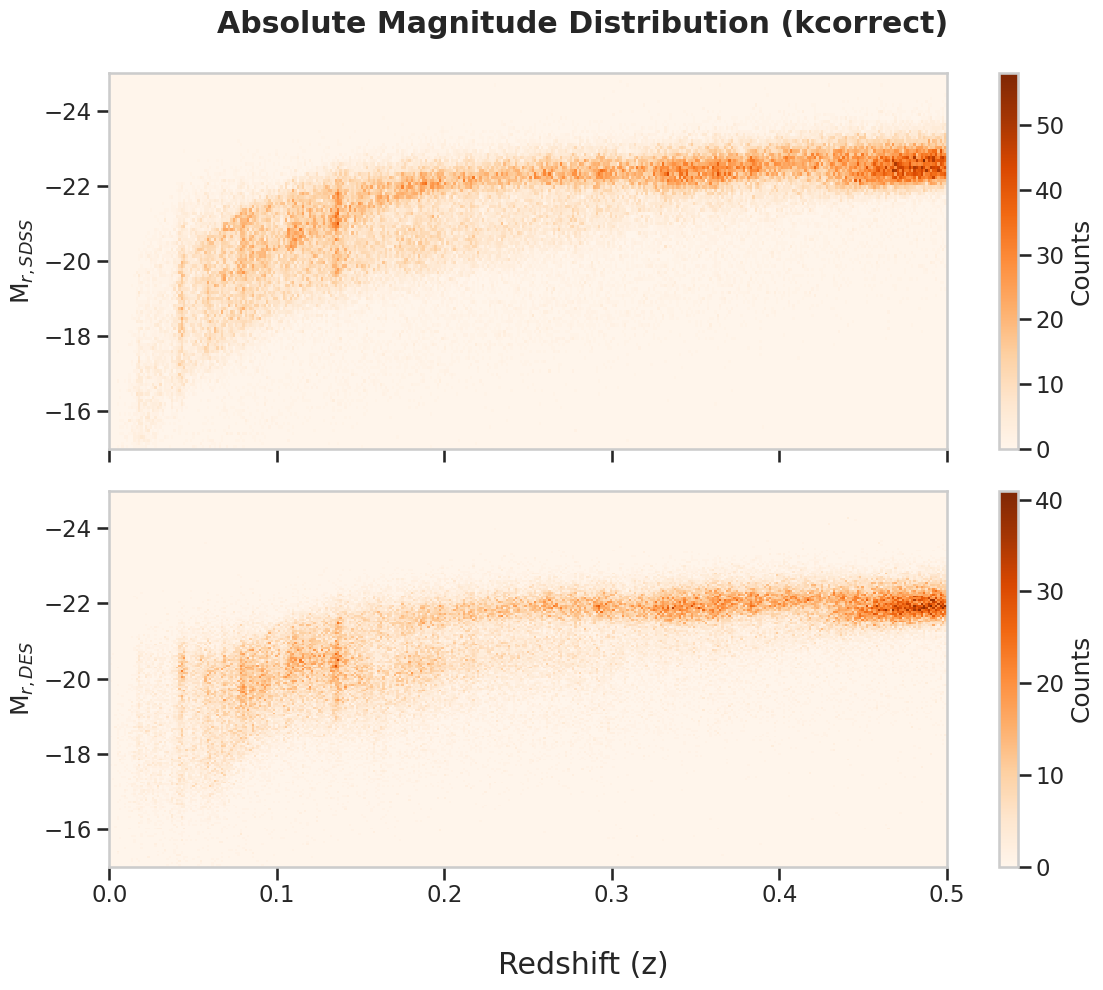

In [88]:
fig, ax = plt.subplots(nrows=2,figsize=(12,10),sharex=True)

ax3 = ax[0].hist2d(spec_z, M_SDSS[:,2], bins=int(np.sqrt(len(M_SDSS[:,2]))) ,cmap='Oranges')
ax4 = ax[1].hist2d(spec_z, M_DES[:,1], bins=int(np.sqrt(len(M_DES[:,1]))) ,cmap='Oranges')

fig.colorbar(ax3[3],ax=ax[0],label='Counts')
fig.colorbar(ax4[3],ax=ax[1],label='Counts')

ax[0].set_xlim(0,0.5)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ybound(-25,-15)
ax[1].set_ybound(-25,-15)
ax[0].set_ylabel(r'M$_{r,SDSS}$')
ax[1].set_ylabel(r'M$_{r,DES}$')

fig.suptitle('Absolute Magnitude Distribution (kcorrect)',weight=600)
fig.supxlabel('Redshift (z)')
fig.tight_layout()
fig.savefig('figures/absmag_kcorr_r.png')
plt.show()

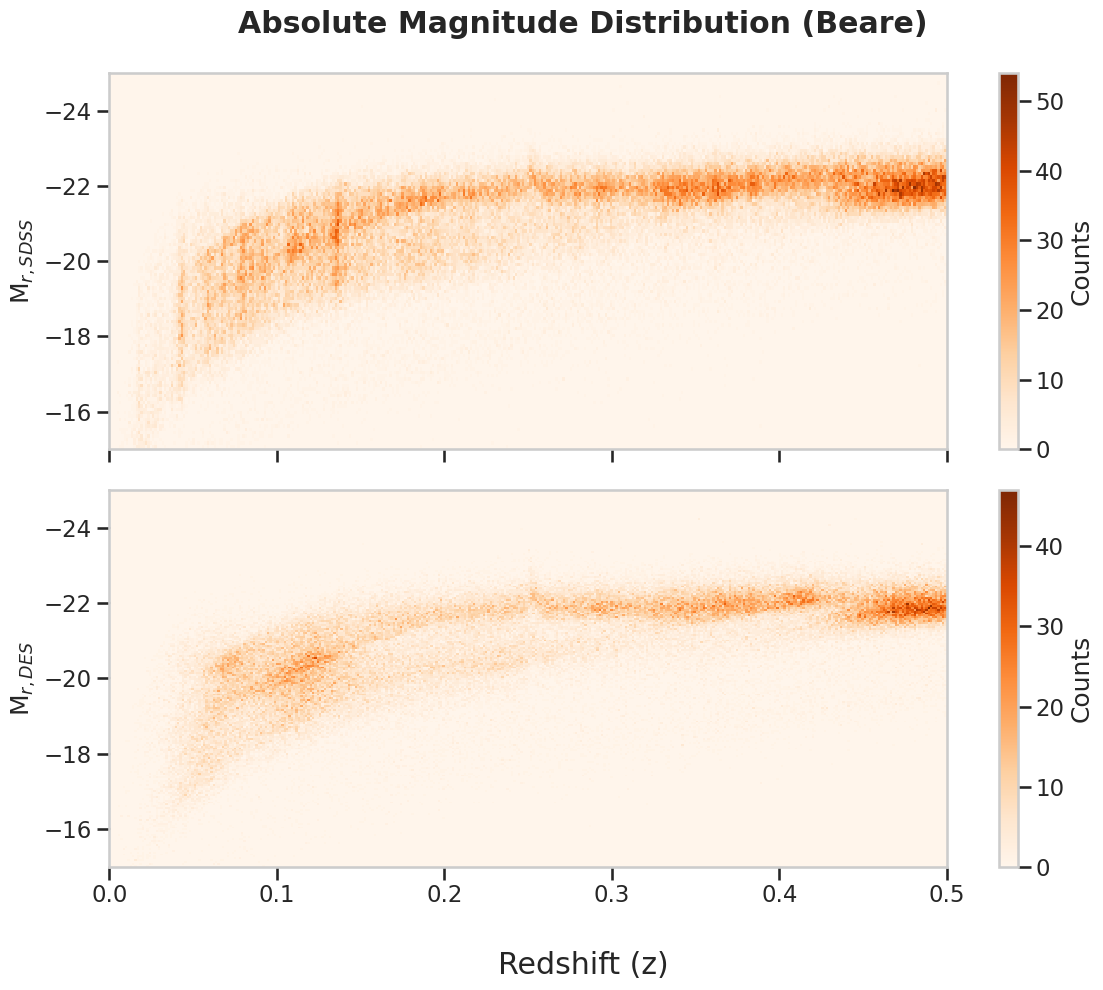

In [89]:
fig, ax = plt.subplots(nrows=2,figsize=(12,10),sharex=True)

ax1 = ax[0].hist2d(spec_z, susmag_SDSS[1], bins=int(np.sqrt(len(susmag_SDSS[1]))) ,cmap='Oranges')
ax2 = ax[1].hist2d(phot_z, susmag_DES[1], bins=int(np.sqrt(len(susmag_DES[1]))) ,cmap='Oranges')

fig.colorbar(ax1[3],ax=ax[0],label='Counts')
fig.colorbar(ax2[3],ax=ax[1],label='Counts')

ax[0].set_xlim(0,0.5)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ybound(-25,-15)
ax[1].set_ybound(-25,-15)
ax[0].set_ylabel(r'M$_{r,SDSS}$')
ax[1].set_ylabel(r'M$_{r,DES}$')

fig.suptitle('Absolute Magnitude Distribution (Beare)',weight=600)
fig.supxlabel('Redshift (z)')
fig.tight_layout()
fig.savefig('figures/absmag_beare_r.png')
plt.show()

/tmp/ipykernel_20062/1505340444.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.axvline(opt[np.where(c==c.max())],color=dcolors[i],ls='--',label=f'Median difference:{float(opt[np.where(c==c.max())]):.2f}')


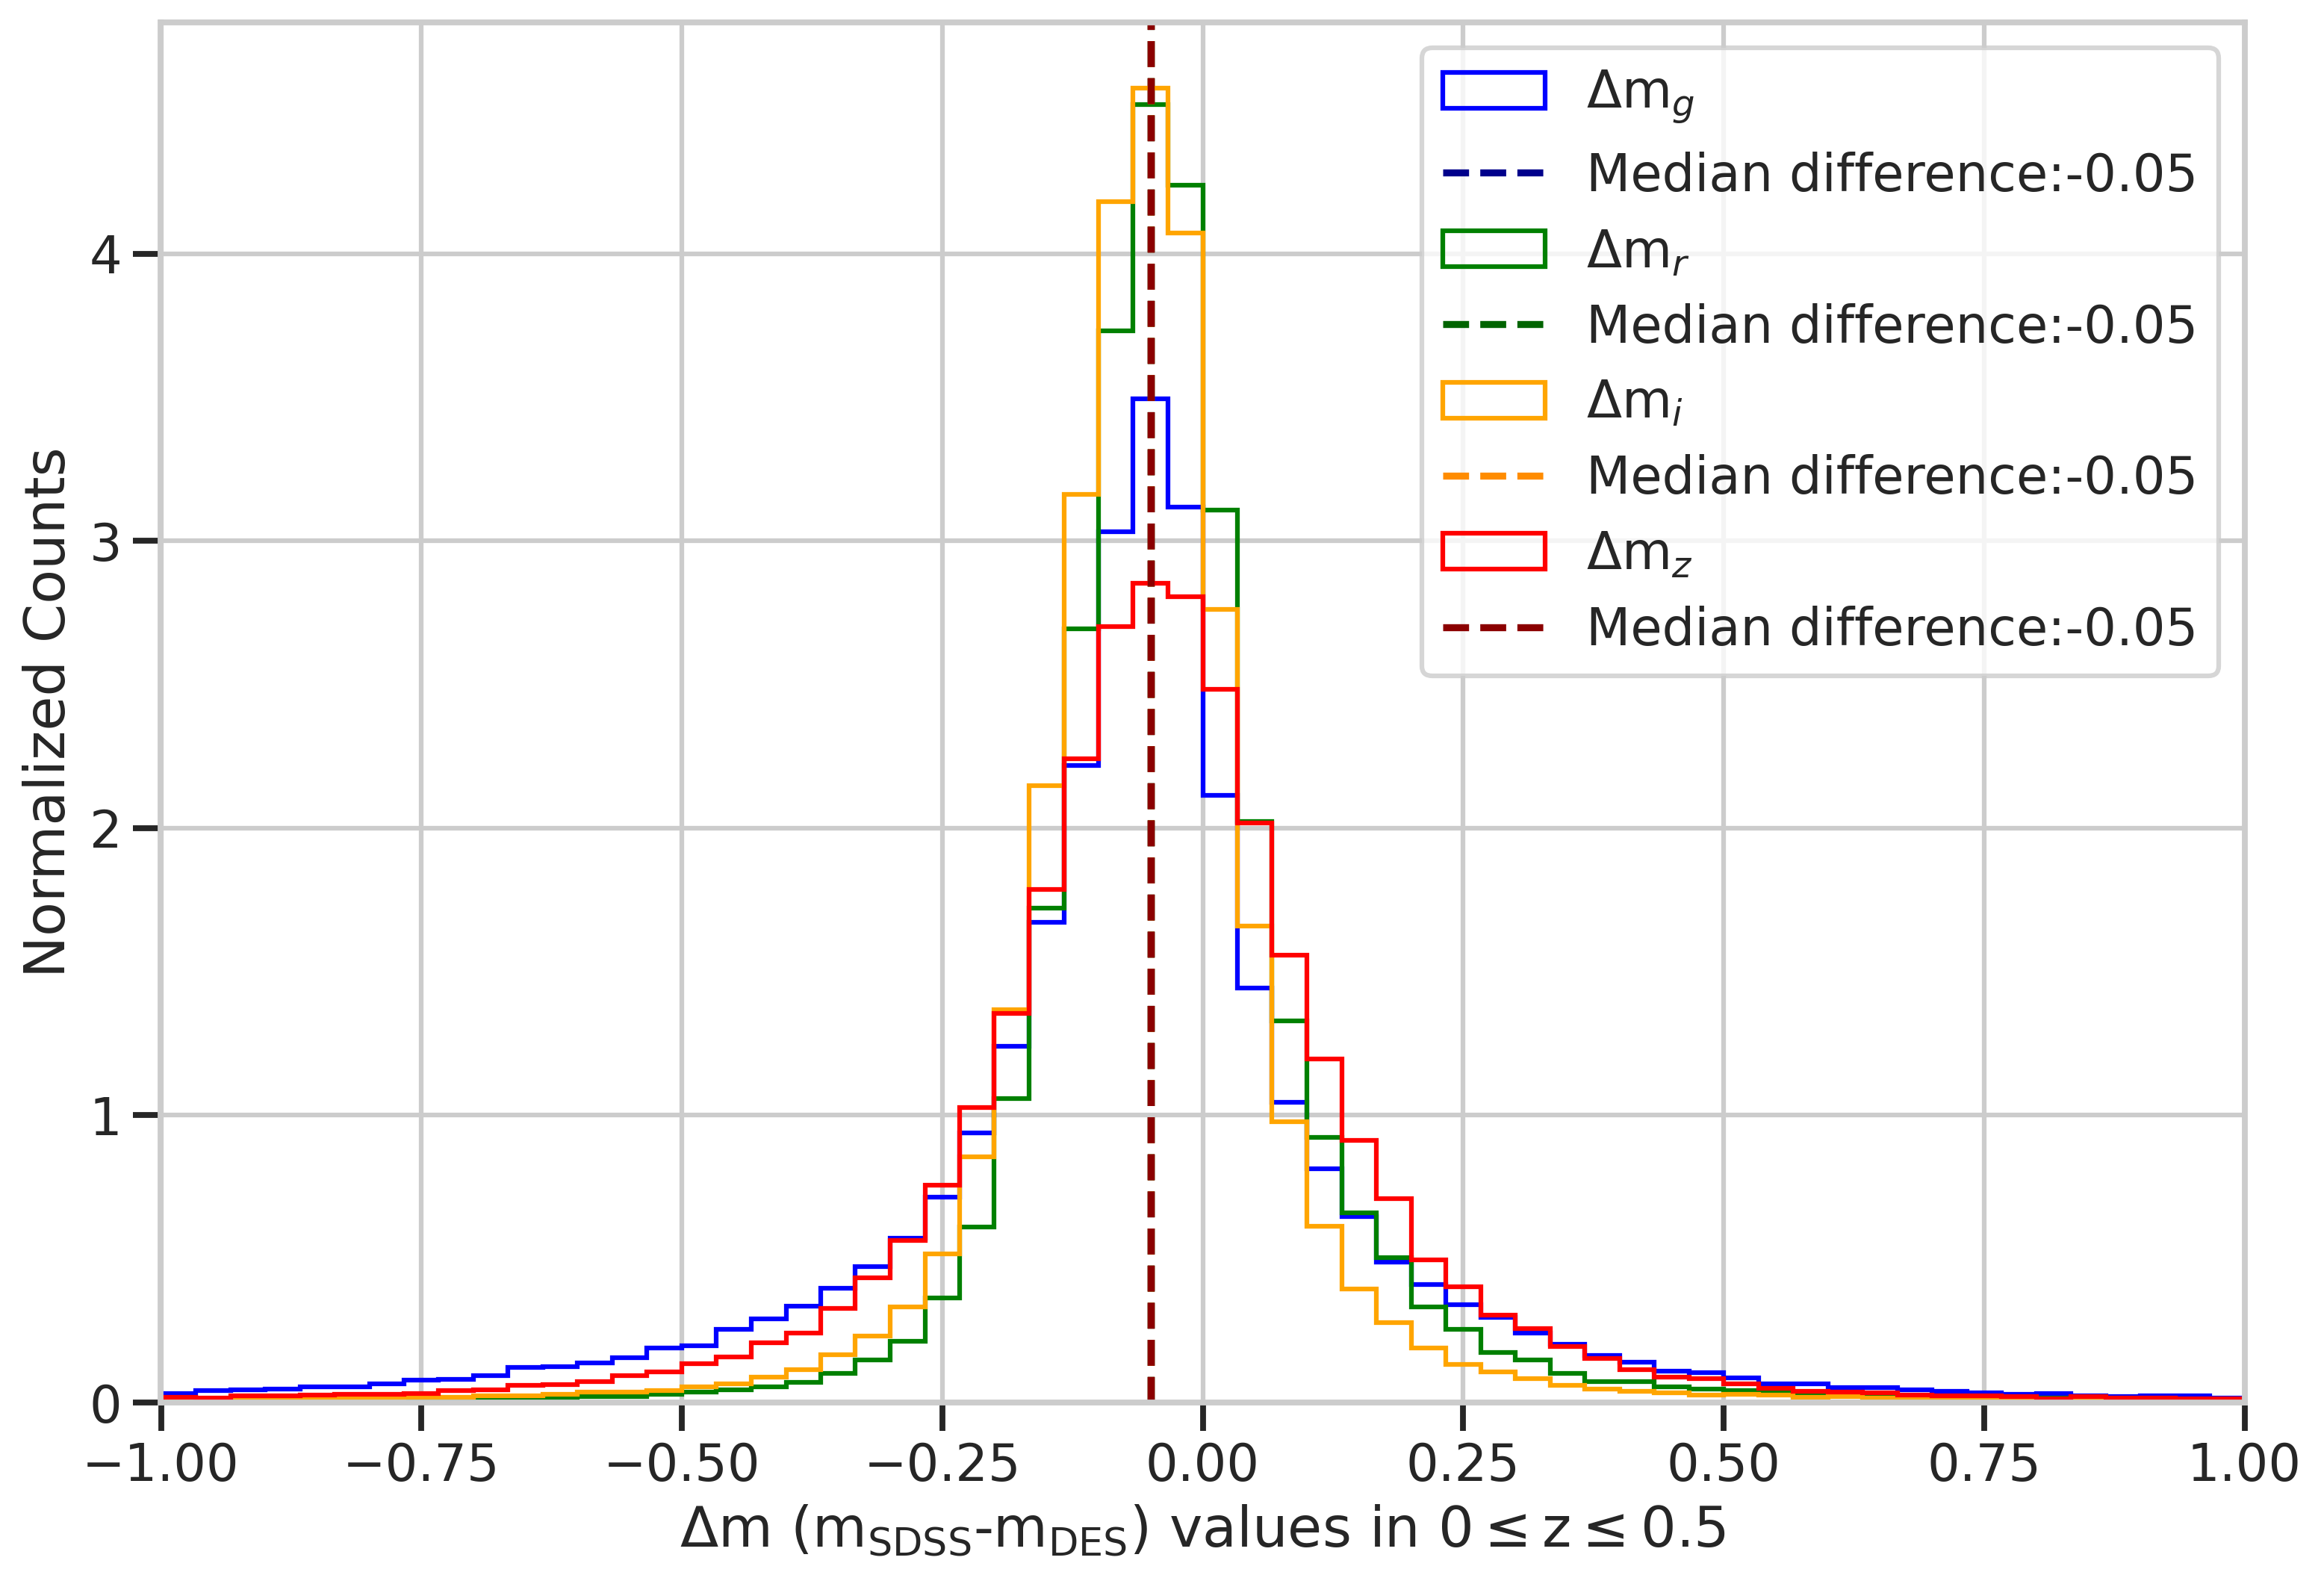

In [41]:
DESS_mag = np.array([m_g,m_r,m_i,m_z])
fig, ax = plt.subplots(figsize=(12,8),dpi=300)
colors = ['blue','green','orange','red']
dcolors = ['darkblue','darkgreen','darkorange','darkred']
for i in range(4):
    c,e,b = ax.hist((SDSS_mag[:,i]-DESS_mag[i]),bins=150,label=f'$\Delta$m$_{bands[i]}$',histtype='step',density=True,color=colors[i],range=[-2.5,2.5])
    opt = 0.5*(e[1:]+e[:-1])
    ax.axvline(opt[np.where(c==c.max())],color=dcolors[i],ls='--',label=f'Median difference:{float(opt[np.where(c==c.max())]):.2f}')
    ax.legend()

ax.set_xlim(-1,1)
ax.set_xlabel(r'$\Delta$m (m$_{\text{SDSS}}$-m$_{\text{DES}}$) values in 0$\leq$z$\leq$0.5')
ax.set_ylabel('Normalized Counts')
fig.savefig('delta_m.png')
plt.show()

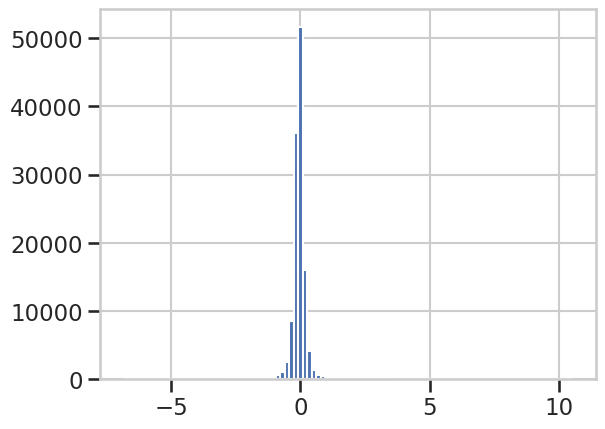

In [42]:
hmmm=plt.hist(df['cmodelmag_z']-m_z,bins=100)

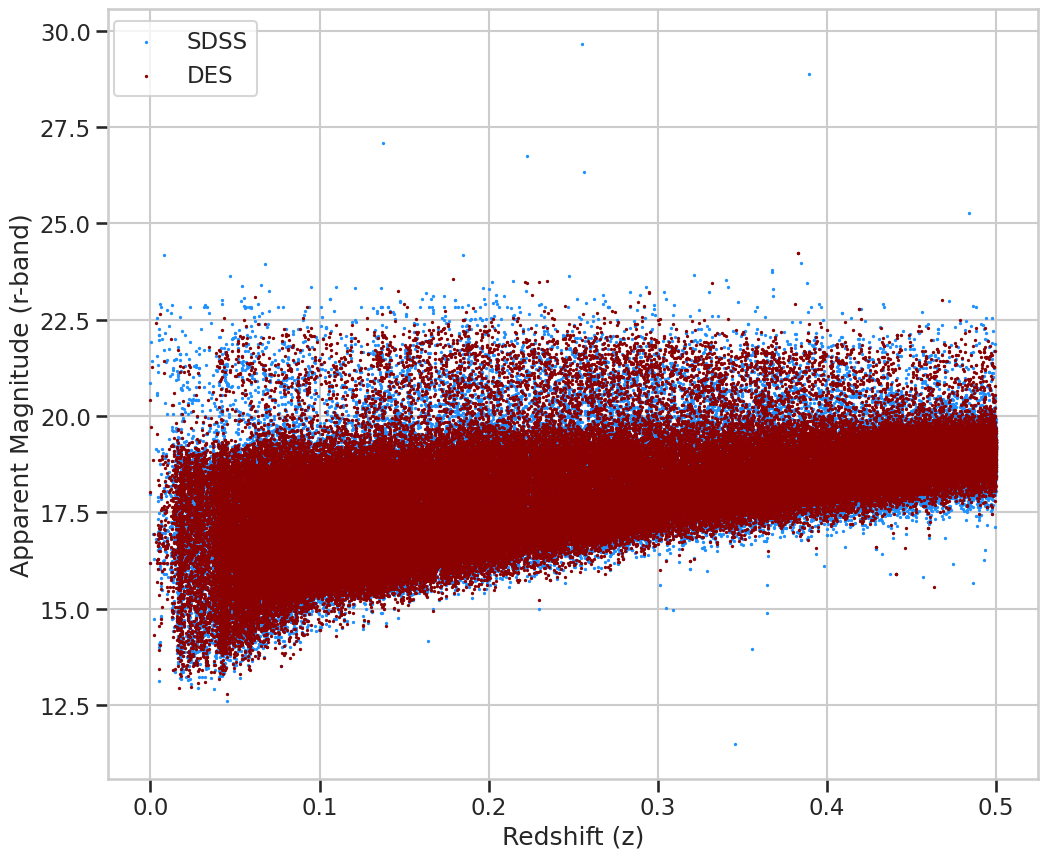

In [43]:
fig, ax = plt.subplots()
plt.scatter(spec_z, df['cmodelmag_z'], marker="o", c='dodgerblue',label='SDSS', s=0.8)
plt.scatter(spec_z, m_z, marker="o", c='darkred',label='DES', s=0.8)

ax.set_yscale('linear')
ax.set_xscale('linear')

ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Apparent Magnitude (r-band)')

fig.legend(loc='upper left', bbox_to_anchor=(0.12,0.88))
fig.set_size_inches(12,10)
plt.show()
plt.close()